In [1]:
from collections import defaultdict, deque
import itertools
import numpy as np
import random
from enum import Enum
from typing import List, Callable, Any, Tuple, Generator
from dataclasses import dataclass
import time
import os
import bisect

In [2]:
def list_files_in_folder(folder_path):
    items = []
    try:
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)

            # Check if it's a file and not a directory (excluding .ipynb_checkpoints)
            if os.path.isfile(item_path) and '.ipynb_checkpoints' not in item and "GVNS" not in item and "VND" not in item and "GRASP" not in item:
                items.append(item_path)
        return items
    except FileNotFoundError:
        print(f"Folder not found: {folder_path}")
        return []

#folder_path = "/content/competition_instances"
test_folder_path_small = "/content/test_instances/small"
test_folder_path_med = "/content/test_instances/medium"
test_folder_path_med_large = "/content/test_instances/medium_large"
test_folder_path_large = "/content/test_instances/large"


#items = list_files_in_folder(folder_path)
items_test_small = list_files_in_folder(test_folder_path_small)
items_test_med = list_files_in_folder(test_folder_path_med)
items_test_med_large = list_files_in_folder(test_folder_path_med_large)
items_test_large = list_files_in_folder(test_folder_path_large)

Folder not found: /content/test_instances/small
Folder not found: /content/test_instances/medium
Folder not found: /content/test_instances/medium_large
Folder not found: /content/test_instances/large


In [3]:
# Utility function for timing
class Timer:
    def __enter__(self):
        self.start = time.perf_counter()
        return self

    def __exit__(self, *args):
        self.end = time.perf_counter()
        self.delta = self.end - self.start

# Assignment 1

In [4]:
class Graph:
    def __init__(self, U_size, V_size):
        self.U = list(range(1, U_size + 1))  # Nodes in fixed layer U
        self.V = list(range(U_size + 1, U_size + V_size + 1))  # Nodes in V
        self.edges = []  # List of edges (u, v, weight)
        self.constraints = defaultdict(list)  # Constraints as adjacency list for V
        self.in_degree = {v: 0 for v in self.V}   # Dictionary to store in-degree of nodes in V
        self.node_edges = defaultdict(list)  # Edges connected to each node
        self.node_edges_prefix_sum = defaultdict(lambda : [0] * U_size)  # Prefix sum of edge weights for each node
        self.node_edges_prefix_counts = defaultdict(lambda : [0] * U_size)  # Prefix count of edge weights for each node
        self.solution_costs = {}  # Store costs for each solution

    def add_node_U(self, node):
        self.U.append(node)

    def add_node_V(self, node):
        self.V.append(node)
        self.in_degree[node] = 0  # Initialize in-degree for nodes in V

    def add_edge(self, u, v, weight):
        self.edges.append((u, v, weight))
        insertion_point = bisect.bisect_left(self.node_edges[v], (u, weight))
        self.node_edges[v].insert(insertion_point, (u, weight))
        um = u - 1
        for i in range(um + 1, len(self.node_edges_prefix_sum[v])):
            self.node_edges_prefix_sum[v][i] += weight
            self.node_edges_prefix_counts[v][i] += 1

    def add_constraint(self, v1, v2):
        self.constraints[v1].append(v2)
        self.in_degree[v2] += 1  # Update in-degree due to precedence constraint

In [5]:
def load_instance(filename):
    with open(filename, 'r') as file:
        U_size, V_size, C_size, E_size = map(int, file.readline().split())
        graph = Graph(U_size, V_size)

        # Read constraints section
        line = file.readline().strip()
        while line != "#constraints":
            line = file.readline().strip()

        for _ in range(C_size):
            v, v_prime = map(int, file.readline().split())
            graph.add_constraint(v, v_prime)

        # Read edges section
        line = file.readline().strip()
        while line != "#edges":
            line = file.readline().strip()

        for _ in range(E_size):
            u, v, weight = file.readline().split()
            graph.add_edge(int(u), int(v), float(weight))

    return graph

In [6]:
#def cost_function(graph, permutation):
#    # Create a dictionary for quick lookup of node positions in the current ordering
#    position = {node: idx for idx, node in enumerate(permutation)}
#    total_cost = 0
#    # Iterate over all pairs of edges to count crossings
#    for (u1, v1, w1), (u2, v2, w2) in itertools.combinations(graph.edges, 2):
#        # Check if edges cross based on their positions
#        if (u1 < u2 and position[v1] > position[v2]) or (u1 > u2 and position[v1] < position[v2]):
#            # Add the sum of weights for the crossing edges to the total cost
#            total_cost += w1 + w2
#
#    return total_cost

In [6]:
from bisect import bisect_left


def cost_function_optimized(graph, permutation):
    """
    Optimized cost function for computing weighted crossings.
    Uses a sweep line approach and processes edges by left endpoint.

    Args:
        graph: Graph object containing edges and weights
        permutation: List representing the ordering of nodes in layer V

    Returns:
        float: Total cost of crossings
    """
    
    tuple_permutation = tuple(permutation)
    
    cost = graph.solution_costs.get(tuple_permutation, None)
    
    if cost is not None:
        return cost
    
    # Create position lookup for the permutation
    position = {node: idx for idx, node in enumerate(permutation)}

    # Sort edges by their source node (u values)
    # Store only relevant information: u, position of v, and weight
    sorted_edges = []
    for u, v, w in graph.edges:
        sorted_edges.append((u, position[v], w))
    sorted_edges.sort()  # Sort by u values

    total_cost = 0
    n = len(sorted_edges)

    # For each edge
    for i in range(n):
        u1, pos_v1, w1 = sorted_edges[i]
        # Compare only with edges that have larger u values
        for j in range(i + 1, n):
            u2, pos_v2, w2 = sorted_edges[j]
            # Since edges are sorted by u, we know u1 < u2
            # Check if they cross by comparing v positions
            if pos_v1 > pos_v2:
                total_cost += w1 + w2
                
    graph.solution_costs[tuple_permutation] = total_cost

    return total_cost

# Alternative implementation using binary indexed tree for even larger graphs
class BinaryIndexedTree:
    def __init__(self, size):
        self.size = size
        self.tree = [0] * (size + 1)

    def update(self, idx, val):
        idx += 1  # Convert to 1-based indexing
        while idx <= self.size:
            self.tree[idx] += val
            idx += idx & (-idx)

    def query(self, idx):
        idx += 1  # Convert to 1-based indexing
        total = 0
        while idx > 0:
            total += self.tree[idx]
            idx -= idx & (-idx)
        return total

def cost_function_bit(graph, permutation):
    """
    Alternative implementation using Binary Indexed Tree for very large graphs.
    Time complexity: O(E log E) where E is number of edges.

    Args:
        graph: Graph object containing edges and weights
        permutation: List representing the ordering of nodes in layer V

    Returns:
        float: Total cost of crossings
    """
    
    tuple_permutation = tuple(permutation)
    
    cost = graph.solution_costs.get(tuple_permutation, None)
    
    if cost is not None:
        return cost
    
    position = {node: idx for idx, node in enumerate(permutation)}
    max_pos = len(permutation)

    # Sort edges by u value
    edges = [(u, position[v], w) for u, v, w in graph.edges]
    edges.sort()

    total_cost = 0
    bit = BinaryIndexedTree(max_pos)
    weight_sum = BinaryIndexedTree(max_pos)

    # Process edges in order of increasing u
    for i, (u, pos_v, w) in enumerate(edges):
        # Count crossings with previous edges
        crossings = bit.query(max_pos - 1) - bit.query(pos_v)
        total_cost += crossings * w

        # Add contribution from weights of crossed edges
        weight_contribution = (weight_sum.query(max_pos - 1) -
                             weight_sum.query(pos_v))
        total_cost += weight_contribution

        # Update BITs
        bit.update(pos_v, 1)
        weight_sum.update(pos_v, w)

    graph.solution_costs[tuple_permutation] = total_cost

    return total_cost

def cost_function_prefix(graph, permutation):
    """
    Cost function using prefix sum for edge weights of nodes in V.
    :param graph: 
    :param permutation: 
    :return: 
    """
    tuple_permutation = tuple(permutation)
    
    cost = graph.solution_costs.get(tuple_permutation, None)
    
    if cost is not None:
        return cost
    
    total_cost = 0
    
    for i, v1 in enumerate(permutation):
        for u1, w in graph.node_edges[v1]:
            for j in range(i+1, len(permutation)):
                v2 = permutation[j]
                # Use binary search to find the position of u1 (or where it would be) in the edge list of v2
                pos = bisect_left(graph.node_edges[v2], u1, key=lambda x: x[0]) - 1
                if pos >= 0:
                    total_cost += w * (pos + 1) + graph.node_edges_prefix_sum[v2][pos]
            
            
    graph.solution_costs[tuple_permutation] = total_cost        
                
    return total_cost

## Question 1: Think about a meaningful real-world application for this problem and briefly describe it

Application: Railway Scheduling and Track Layout

- Nodes in $U$ could represent fixed train stations along a route, where trains must stop in a specific order
- Nodes in $V$ could reoresent trains/train routes to be scheduled within the network
- Weighetd edges would inidcate the relationship between trains/train routes and tracks, with higher weights representing either higher traffic, longer distance, lower importance in terms of scheduling (in case of for exaple local vs. high speed train)
- constraints in C would enforce rules like the fact that certain trains need to arrive before others or that trains using the same tracks do not overlap.

The objective then would be to arrange the schedules in V to minimize the crossings of tracks while satisfying all contraints in C. This would lead to improved security and efficiency as minimzing track crossings would reduce the likelihood of collisions or delaysdue to track conflicts.

## Question 2: Develop a meaningful deterministic construction heuristic

A meaningful determinitic contruction heuristic could be one based on a greedy approach:
- Inititalize an empty ordered permuation list $\pi$ for nodes in $V$
- Compute for each node in $V$ the number of constraints that require other nodes to come before it
- Create a list of candidates with nodes in $V$ that have no predecessors

- For every node in the candidates and until $V$ is empty
  - calculate the total weight of edges connecting it to U
  - select the node with the lowest total edge weight to nodes in $U$ and append it to the final permutation list $\pi$

  - update the in-degree of nodes that had this as a constraint reducing it by 1

  - if the in-degree of any node in V reaches zero add it to the candidates




In [7]:
class DeterministicConstruction:
    def __init__(self, graph):
        self.graph = graph
        self.pi = []  # store the final order of nodes in V

        # Precompute edge weights per node for efficiency
        self.node_weights = defaultdict(int)
        for u, v, weight in graph.edges:
            self.node_weights[v] += weight

    def greedy_construction(self):
        # Initialize candidates with in-degree 0 nodes
        in_degree = self.graph.in_degree.copy()
        candidates = deque([v for v in self.graph.V if in_degree[v] == 0])

        while candidates:
            # Select node with lowest total edge weight
            best_node = min(candidates, key=lambda v: self.node_weights[v])

            # Add the selected best_node to the pi
            self.pi.append(best_node)
            candidates.remove(best_node)

            # Update in-degrees and add new candidates
            for v_next in self.graph.constraints[best_node]:
                in_degree[v_next] -= 1
                if in_degree[v_next] == 0:
                    candidates.append(v_next)
        # Verify the solution before returning
        if not self.verify_solution():
            raise ValueError("Construction resulted in invalid solution!")

        return self.pi


    def verify_solution(self):
        """
        Verify that the solution respects all constraints
        """
        if not self.pi:
            return False

        # Check if all nodes from V are present
        if set(self.pi) != set(self.graph.V):
            return False

        # Check if constraints are respected
        position = {node: idx for idx, node in enumerate(self.pi)}
        for v1 in self.graph.V:
            for v2 in self.graph.constraints[v1]:
                if position[v1] > position[v2]:
                    return False

        return True

In [8]:
# Example usage with a small problem instance
graph = Graph(5, 5)

# Adding edges with weights
graph.add_edge(1, 7, 1)
graph.add_edge(2, 8, 2)
graph.add_edge(3, 9, 1)
graph.add_edge(4, 10, 3)
graph.add_edge(5, 6, 11)

# Adding precedence constraints
graph.add_constraint(7, 10)
graph.add_constraint(8, 9)

# Create an MWCCP solution instance and use the greedy heuristic
solution = DeterministicConstruction(graph)
ordering = solution.greedy_construction()


print("The initial ordering of nodes in V:", ordering)

print(cost_function_bit(graph, ordering))

The initial ordering of nodes in V: [7, 8, 9, 10, 6]
0


In [145]:
# Iterate over test items and record time and cost
results = []  # Store (item_name, time, cost) for each solution
for item in items_test_small:
    graph = load_instance(item)
    with Timer() as t:
        solution = DeterministicConstruction(graph)
        ordering = solution.greedy_construction()
    cost = cost_function_optimized(graph, ordering)  # Cost computation outside the timing block
    results.append((item, t.delta, cost))

print(f"{'Item':<50} {'Time (s)':<10} {'Cost':<10}")
print("-" * 70)
for item, time_taken, cost in results:
    print(f"{item:<50} {time_taken:<10.6f} {cost:<10}")


Item                                               Time (s)   Cost      
----------------------------------------------------------------------
content/test_instances/small/inst_50_4_00006       0.003256   4883.0    
content/test_instances/small/inst_50_4_00001       0.000077   84883.0   
content/test_instances/small/inst_50_4_00008       0.000072   3005.0    
content/test_instances/small/inst_50_4_00009       0.000049   2633.0    
content/test_instances/small/inst_50_4_00007       0.000046   3463.0    
content/test_instances/small/inst_50_4_00010       0.000048   1658.0    
content/test_instances/small/inst_50_4_00002       0.000050   31619.0   
content/test_instances/small/inst_50_4_00005       0.000057   6034.0    
content/test_instances/small/inst_50_4_00004       0.000052   8582.0    
content/test_instances/small/inst_50_4_00003       0.000051   15511.0   


In [146]:
# Iterate over test items and record time and cost
results = []  # Store (item_name, time, cost) for each solution
for item in items_test_med:
    graph = load_instance(item)
    with Timer() as t:
        solution = DeterministicConstruction(graph)
        ordering = solution.greedy_construction()
    cost = cost_function_bit(graph, ordering)  # Cost computation outside the timing block
    results.append((item, t.delta, cost))

print(f"{'Item':<50} {'Time (s)':<10} {'Cost':<10}")
print("-" * 70)
for item, time_taken, cost in results:
    print(f"{item:<50} {time_taken:<10.6f} {cost:<10}")

Item                                               Time (s)   Cost      
----------------------------------------------------------------------
content/test_instances/medium/inst_200_20_00007    0.000253   908103.0  
content/test_instances/medium/inst_200_20_00009    0.000271   547596.0  
content/test_instances/medium/inst_200_20_00008    0.000341   709644.0  
content/test_instances/medium/inst_200_20_00001    0.000479   23033165.0
content/test_instances/medium/inst_200_20_00006    0.000517   1217519.0 
content/test_instances/medium/inst_200_20_00003    0.000317   4361007.0 
content/test_instances/medium/inst_200_20_00004    0.000415   2551528.0 
content/test_instances/medium/inst_200_20_00005    0.000342   1627621.0 
content/test_instances/medium/inst_200_20_00002    0.000434   8390614.0 
content/test_instances/medium/inst_200_20_00010    0.000388   461537.0  


In [148]:
# Iterate over test items and record time and cost
results = []  # Store (item_name, time, cost) for each solution
for item in items_test_med_large:
    graph = load_instance(item)
    with Timer() as t:
        solution = DeterministicConstruction(graph)
        ordering = solution.greedy_construction()
    cost = cost_function_bit(graph, ordering)  # Cost computation outside the timing block
    results.append((item, t.delta, cost))


print(f"{'Item':<50} {'Time (s)':<10} {'Cost':<10}")
print("-" * 70)
for item, time_taken, cost in results:
    print(f"{item:<50} {time_taken:<10.6f} {cost:<10}")

Item                                               Time (s)   Cost      
----------------------------------------------------------------------
content/test_instances/medium_large/inst_500_40_00007 0.003886   168022855.0
content/test_instances/medium_large/inst_500_40_00001 0.002368   40802322.0
content/test_instances/medium_large/inst_500_40_00013 0.002765   334007118.0
content/test_instances/medium_large/inst_500_40_00004 0.002828   94454966.0
content/test_instances/medium_large/inst_500_40_00016 0.002996   437097158.0
content/test_instances/medium_large/inst_500_40_00019 0.004254   532473137.0
content/test_instances/medium_large/inst_500_40_00010 0.003825   247294126.0


In [149]:
# Iterate over test items and record time and cost
results = []
for item in items_test_large:
    graph = load_instance(item)
    with Timer() as t:
        solution = DeterministicConstruction(graph)
        ordering = solution.greedy_construction()
    cost =  cost_function_bit(graph, ordering) # Cost computation outside the timing block
    results.append((item, t.delta, cost))

print(f"{'Item':<50} {'Time (s)':<10} {'Cost':<10}")
print("-" * 70)
for item, time_taken, cost in results:
    print(f"{item:<50} {time_taken:<10.6f} {cost:<10}")

Item                                               Time (s)   Cost      
----------------------------------------------------------------------
content/test_instances/large/inst_1000_60_00010    0.007034   293146116.0
content/test_instances/large/inst_1000_60_00003    0.009119   2701197831.0
content/test_instances/large/inst_1000_60_00004    0.012672   1614552426.0
content/test_instances/large/inst_1000_60_00005    0.012401   1065285851.0
content/test_instances/large/inst_1000_60_00002    0.013001   5340801153.0
content/test_instances/large/inst_1000_60_00009    0.013263   358976591.0
content/test_instances/large/inst_1000_60_00007    0.007331   569249713.0
content/test_instances/large/inst_1000_60_00001    0.016326   15151194763.0
content/test_instances/large/inst_1000_60_00006    0.019348   767270792.0
content/test_instances/large/inst_1000_60_00008    0.007661   451262171.0


In [9]:
def load_and_order_instance(filename):
    graph = load_instance(filename)
    solution = DeterministicConstruction(graph)
    ordering = solution.greedy_construction()
    return graph, ordering

## Question 3: Derive a randomized construction heuristic to be applied iteratively

The randomized heuristic could follow the same process as the deterministic one, but then, when choosing the node in $V$ to add to the final permutation list $\pi$, instead of always choosing the one that has a minimum weighted sum of edges to $U$, pick one randomly, with a probability inversely propotional to this sum.

In [10]:
class RandomizedConstruction:
    def __init__(self, graph, alpha=0.4):
        self.graph = graph
        self.pi = []  # Final order of nodes in V

        # Precompute edge weights per node for efficiency
        self.node_weights = defaultdict(int)
        self.node_connections = defaultdict(list)
        for u, v, weight in graph.edges:
            self.node_weights[v] += weight
            self.node_connections[v].append((u, weight))

        # Parameters for randomization
        self.alpha = alpha

    def calculate_node_score(self, node, current_ordering):
        """
        Calculate a score for a node based on both its weights and potential crossings
        """
        if not current_ordering:
            return self.node_weights[node]

        score = 0

        # Consider existing edges and potential crossings
        for u, weight in self.node_connections[node]:
            score += weight  # Base weight

            # Check potential crossings with already placed nodes
            #for prev_node in current_ordering:
            #    for prev_u, prev_weight in self.node_connections[prev_node]:
            #        if (u < prev_u and position > current_ordering.index(prev_node)) or \
            #           (u > prev_u and position < current_ordering.index(prev_node)):
            #            score += (weight + prev_weight) * 0.5  # Penalty for potential crossing

        return score

    def calculate_probabilities(self, candidates, current_ordering):
        """
        Calculate selection probabilities using Boltzmann distribution
        """
        scores = []
        for node in candidates:
            score = self.calculate_node_score(node, current_ordering)
            scores.append(score)

        scores = np.array(scores)

        # Convert scores to probabilities (lower scores = higher probability)
        max_score = max(scores) if scores.size > 0 else 1
        normalized_scores = scores / max_score  # Normalize to prevent overflow

        # Apply Boltzmann distribution with temperature
        probs = np.exp(-normalized_scores / self.alpha)
        probs = probs / np.sum(probs)
        
        # Replace all NaN values with 0
        probs = np.nan_to_num(probs)

        return probs

    def greedy_randomized_construction(self, num_iterations=1):
        """
        Perform multiple iterations and return the best solution
        """
        best_solution = None
        best_cost = float('inf')

        for _ in range(num_iterations):
            solution = self.construct_single_solution()
            cost = cost_function_bit(self.graph, solution)

            if cost < best_cost:
                best_cost = cost
                best_solution = solution.copy()


        self.pi = best_solution
        return best_solution
    
    # def greedy_construction(self):
    #     # Initialize candidates with in-degree 0 nodes
    #     candidates = deque([v for v in self.graph.V if self.graph.in_degree[v] == 0])
    # 
    #     while candidates:
    #         # Select node with lowest total edge weight
    #         best_node = min(candidates, key=lambda v: self.node_weights[v])
    # 
    #         # Add the selected best_node to the pi
    #         self.pi.append(best_node)
    #         candidates.remove(best_node)
    # 
    #         # Update in-degrees and add new candidates
    #         for v_next in self.graph.constraints[best_node]:
    #             self.graph.in_degree[v_next] -= 1
    #             if self.graph.in_degree[v_next] == 0:
    #                 candidates.append(v_next)
    #     # Verify the solution before returning
    #     if not self.verify_solution():
    #         raise ValueError("Construction resulted in invalid solution!")
    # 
    #     return self.pi

    def construct_single_solution(self):
        """
        Construct a single solution using randomized greedy approach
        """
        # Reset in-degrees for this iteration
        in_degree = self.graph.in_degree.copy()
        current_ordering = []

        # Initialize candidates with in-degree 0 nodes
        candidates = deque([v for v in self.graph.V if in_degree[v] == 0])

        while candidates:
            candidates_list = list(candidates)

            if len(candidates_list) == 1:
                # If only one candidate, select it directly
                selected_node = candidates_list[0]
            else:
                # Calculate probabilities and select node
                probs = self.calculate_probabilities(candidates_list, current_ordering)
                selected_node = np.random.choice(candidates_list, p=probs)

            current_ordering.append(selected_node)
            candidates.remove(selected_node)

            # Update in-degrees and add new candidates
            for v_next in self.graph.constraints[selected_node]:
                in_degree[v_next] -= 1
                if in_degree[v_next] == 0:
                    candidates.append(v_next)

        return current_ordering

    def verify_solution(self):
        """
        Verify that the solution respects all constraints
        """
        if not self.pi:
            return False

        # Check if all nodes from V are present
        if set(self.pi) != set(self.graph.V):
            return False

        # Check if constraints are respected
        position = {node: idx for idx, node in enumerate(self.pi)}
        for v1 in self.graph.V:
            for v2 in self.graph.constraints[v1]:
                if position[v1] > position[v2]:
                    return False

        return True

In [11]:
graph = Graph(5, 5)

# Adding edges with weights
graph.add_edge(1, 7, 1)
graph.add_edge(2, 8, 2)
graph.add_edge(3, 9, 1)
graph.add_edge(4, 10, 3)
graph.add_edge(5, 6, 11)

# Adding precedence constraints
graph.add_constraint(7, 10)
graph.add_constraint(8, 9)


solution = RandomizedConstruction(graph)
ordering = solution.greedy_randomized_construction()


print("The initial ordering of nodes in V:", ordering)

print(cost_function_optimized(graph, ordering))

The initial ordering of nodes in V: [7, 8, 9, 10, 6]
0


In [11]:
def run_multiple_trials(graph, num_trials=30):
    """
    Run multiple trials of the randomized construction and return average results.

    Args:
        graph: Graph instance
        num_trials: Number of trials to run (default: 30)

    Returns:
        tuple: (average_time, average_cost, min_cost, max_cost, std_dev_cost)
    """
    times = []
    costs = []

    for _ in range(num_trials):
        with Timer() as t:
            solution = RandomizedConstruction(graph)
            ordering = solution.greedy_randomized_construction()
        cost = cost_function_bit(graph, ordering)

        times.append(t.delta)
        costs.append(cost)

    # Calculate statistics
    avg_time = sum(times) / num_trials
    avg_cost = sum(costs) / num_trials
    min_cost = min(costs)
    max_cost = max(costs)

    # Calculate standard deviation for costs
    variance = sum((x - avg_cost) ** 2 for x in costs) / num_trials
    std_dev = variance ** 0.5

    return avg_time, avg_cost, min_cost, max_cost, std_dev

In [154]:
# Iterate over test items and record average results
results = []  # Store (item_name, avg_time, avg_cost, min_cost, max_cost, std_dev) for each solution
NUM_TRIALS = 30

print("Running trials...")
for item in items_test_small:
    print(f"Processing {item}...")
    graph = load_instance(item)
    avg_time, avg_cost, min_cost, max_cost, std_dev = run_multiple_trials(graph, NUM_TRIALS)
    results.append((item, avg_time, avg_cost, min_cost, max_cost, std_dev))

# Print results in a formatted table
print("\nResults:")
print(f"{'Item':<50} {'Avg Time(s)':<12} {'Avg Cost':<12} {'Min Cost':<12} {'Max Cost':<12} {'Std Dev':<12}")
print("-" * 110)
for item, avg_time, avg_cost, min_cost, max_cost, std_dev in results:
    print(f"{item:<50} {avg_time:<12.6f} {avg_cost:<12.2f} {min_cost:<12.2f} {max_cost:<12.2f} {std_dev:<12.2f}")

# Print summary statistics
print("\nSummary Statistics:")
total_times = [result[1] for result in results]
total_costs = [result[2] for result in results]
print(f"Average time across all instances: {sum(total_times)/len(total_times):.6f} seconds")
print(f"Average cost across all instances: {sum(total_costs)/len(total_costs):.2f}")

Running trials...
Processing content/test_instances/small/inst_50_4_00006...
Processing content/test_instances/small/inst_50_4_00001...
Processing content/test_instances/small/inst_50_4_00008...
Processing content/test_instances/small/inst_50_4_00009...
Processing content/test_instances/small/inst_50_4_00007...
Processing content/test_instances/small/inst_50_4_00010...
Processing content/test_instances/small/inst_50_4_00002...
Processing content/test_instances/small/inst_50_4_00005...
Processing content/test_instances/small/inst_50_4_00004...
Processing content/test_instances/small/inst_50_4_00003...

Results:
Item                                               Avg Time(s)  Avg Cost     Min Cost     Max Cost     Std Dev     
--------------------------------------------------------------------------------------------------------------
content/test_instances/small/inst_50_4_00006       0.000688     4659.13      4100.00      5100.00      278.96      
content/test_instances/small/inst_50_4_

In [155]:
# Iterate over test items and record average results
results = []  # Store (item_name, avg_time, avg_cost, min_cost, max_cost, std_dev) for each solution
NUM_TRIALS = 30

print("Running trials...")
for item in items_test_med:
    print(f"Processing {item}...")
    graph = load_instance(item)
    avg_time, avg_cost, min_cost, max_cost, std_dev = run_multiple_trials(graph, NUM_TRIALS)
    results.append((item, avg_time, avg_cost, min_cost, max_cost, std_dev))

# Print results in a formatted table
print("\nResults:")
print(f"{'Item':<50} {'Avg Time(s)':<12} {'Avg Cost':<12} {'Min Cost':<12} {'Max Cost':<12} {'Std Dev':<12}")
print("-" * 110)
for item, avg_time, avg_cost, min_cost, max_cost, std_dev in results:
    print(f"{item:<50} {avg_time:<12.6f} {avg_cost:<12.2f} {min_cost:<12.2f} {max_cost:<12.2f} {std_dev:<12.2f}")

# Print summary statistics
print("\nSummary Statistics:")
total_times = [result[1] for result in results]
total_costs = [result[2] for result in results]
print(f"Average time across all instances: {sum(total_times)/len(total_times):.6f} seconds")
print(f"Average cost across all instances: {sum(total_costs)/len(total_costs):.2f}")

Running trials...
Processing content/test_instances/medium/inst_200_20_00007...
Processing content/test_instances/medium/inst_200_20_00009...
Processing content/test_instances/medium/inst_200_20_00008...
Processing content/test_instances/medium/inst_200_20_00001...
Processing content/test_instances/medium/inst_200_20_00006...
Processing content/test_instances/medium/inst_200_20_00003...
Processing content/test_instances/medium/inst_200_20_00004...
Processing content/test_instances/medium/inst_200_20_00005...
Processing content/test_instances/medium/inst_200_20_00002...
Processing content/test_instances/medium/inst_200_20_00010...

Results:
Item                                               Avg Time(s)  Avg Cost     Min Cost     Max Cost     Std Dev     
--------------------------------------------------------------------------------------------------------------
content/test_instances/medium/inst_200_20_00007    0.005016     904676.13    856985.00    922488.00    14738.01    
content/t

In [156]:
# Iterate over test items and record average results
results = []  # Store (item_name, avg_time, avg_cost, min_cost, max_cost, std_dev) for each solution
NUM_TRIALS = 30

print("Running trials...")
for item in items_test_med_large:
    print(f"Processing {item}...")
    graph = load_instance(item)
    avg_time, avg_cost, min_cost, max_cost, std_dev = run_multiple_trials(graph, NUM_TRIALS)
    results.append((item, avg_time, avg_cost, min_cost, max_cost, std_dev))

# Print results in a formatted table
print("\nResults:")
print(f"{'Item':<50} {'Avg Time(s)':<12} {'Avg Cost':<12} {'Min Cost':<12} {'Max Cost':<12} {'Std Dev':<12}")
print("-" * 110)
for item, avg_time, avg_cost, min_cost, max_cost, std_dev in results:
    print(f"{item:<50} {avg_time:<12.6f} {avg_cost:<12.2f} {min_cost:<12.2f} {max_cost:<12.2f} {std_dev:<12.2f}")

# Print summary statistics
print("\nSummary Statistics:")
total_times = [result[1] for result in results]
total_costs = [result[2] for result in results]
print(f"Average time across all instances: {sum(total_times)/len(total_times):.6f} seconds")
print(f"Average cost across all instances: {sum(total_costs)/len(total_costs):.2f}")

Running trials...
Processing content/test_instances/medium_large/inst_500_40_00007...
Processing content/test_instances/medium_large/inst_500_40_00001...
Processing content/test_instances/medium_large/inst_500_40_00013...
Processing content/test_instances/medium_large/inst_500_40_00004...
Processing content/test_instances/medium_large/inst_500_40_00016...
Processing content/test_instances/medium_large/inst_500_40_00019...
Processing content/test_instances/medium_large/inst_500_40_00010...

Results:
Item                                               Avg Time(s)  Avg Cost     Min Cost     Max Cost     Std Dev     
--------------------------------------------------------------------------------------------------------------
content/test_instances/medium_large/inst_500_40_00007 0.062816     166837198.17 164737418.00 168631874.00 907634.44   
content/test_instances/medium_large/inst_500_40_00001 0.037882     41252010.03  40676677.00  41714581.00  282882.28   
content/test_instances/medium_l

In [157]:
# Iterate over test items and record average results
results = []  # Store (item_name, avg_time, avg_cost, min_cost, max_cost, std_dev) for each solution
NUM_TRIALS = 30

print("Running trials...")
for item in items_test_large:
    print(f"Processing {item}...")
    graph = load_instance(item)
    avg_time, avg_cost, min_cost, max_cost, std_dev = run_multiple_trials(graph, NUM_TRIALS)
    results.append((item, avg_time, avg_cost, min_cost, max_cost, std_dev))

# Print results in a formatted table
print("\nResults:")
print(f"{'Item':<50} {'Avg Time(s)':<12} {'Avg Cost':<12} {'Min Cost':<12} {'Max Cost':<12} {'Std Dev':<12}")
print("-" * 110)
for item, avg_time, avg_cost, min_cost, max_cost, std_dev in results:
    print(f"{item:<50} {avg_time:<12.6f} {avg_cost:<12.2f} {min_cost:<12.2f} {max_cost:<12.2f} {std_dev:<12.2f}")

# Print summary statistics
print("\nSummary Statistics:")
total_times = [result[1] for result in results]
total_costs = [result[2] for result in results]
print(f"Average time across all instances: {sum(total_times)/len(total_times):.6f} seconds")
print(f"Average cost across all instances: {sum(total_costs)/len(total_costs):.2f}")

Running trials...
Processing content/test_instances/large/inst_1000_60_00010...
Processing content/test_instances/large/inst_1000_60_00003...
Processing content/test_instances/large/inst_1000_60_00004...
Processing content/test_instances/large/inst_1000_60_00005...
Processing content/test_instances/large/inst_1000_60_00002...
Processing content/test_instances/large/inst_1000_60_00009...
Processing content/test_instances/large/inst_1000_60_00007...
Processing content/test_instances/large/inst_1000_60_00001...
Processing content/test_instances/large/inst_1000_60_00006...
Processing content/test_instances/large/inst_1000_60_00008...

Results:
Item                                               Avg Time(s)  Avg Cost     Min Cost     Max Cost     Std Dev     
--------------------------------------------------------------------------------------------------------------
content/test_instances/large/inst_1000_60_00010    0.148869     294060991.10 291048657.00 296426716.00 1346840.57  
content/t

In [53]:
#for item in items:
#    graph = load_instance(item)
#    solution = RandomizedConstruction(graph)
#    ordering = solution.greedy_randomized_construction()
#
#    instance_name = os.path.basename(item)
#    with open(f"{instance_name}.txt", "w") as f:
#        f.write(instance_name + "\n")
#        f.write(" ".join(map(str, ordering)) + "\n")

## 4. Develop or make use of a framework for basic local search which is able to deal with: different neighborhood structures and different step functions (first-improvement, best-improvement, random)


In [12]:
class LocalSearch:
    def __init__(self, initial_solution, neighborhood_function, step_function, objective_function, max_iter=500):
        """
        Local Search framework.

        Args:
        - initial_solution: Starting solution for the search
        - neighborhood_function: Function to generate neighbor solutions
        - step_function: Function to select next step in search
        - objective_function: Function to compute the cost of a solution
        - max_iter: Maximum number of iterations for the search
        """
        self.current_solution = initial_solution
        self.neighborhood_function = neighborhood_function
        self.step_function = step_function
        self.objective_function = objective_function
        self.max_iter = max_iter

    def local_search(self):
          best_solution = self.current_solution
          best_cost = self.objective_function(best_solution)

          for i in range(self.max_iter):

            neighbors = self.neighborhood_function(self.current_solution)
            next_solution = self.step_function(neighbors, self.objective_function)
            next_cost = self.objective_function(next_solution)

            if next_cost < best_cost:
              best_solution = next_solution
              best_cost = next_cost
              continue


            if best_cost == 0:
              break

            self.current_solution = next_solution


          print("Required iterations:", i)
          return best_solution, best_cost


def best_improvement(neighbors, objective_function):
    if not neighbors:
      return None

    best_neighbor = None
    best_cost = float('inf')

    for neighbor in neighbors:
      cost = objective_function(neighbor)
      if cost < best_cost:
        best_neighbor = neighbor
        best_cost = cost

    return best_neighbor


def first_improvement(neighbors, objective_function):
    for neighbor in neighbors:
      if objective_function(neighbor) < objective_function(neighbors[0]):
        return neighbor
    return neighbors[0]


def random_neighbor(neighbors, objective_function):
  return random.choice(neighbors)


def cost_function(graph, permutation): # same function as above
    if permutation is None:
        return float('inf')
    # Create a dictionary for quick lookup of node positions in the current ordering
    position = {node: idx for idx, node in enumerate(permutation)}
    total_cost = 0
    # Iterate over all pairs of edges to count crossings
    for (u1, v1, w1), (u2, v2, w2) in itertools.combinations(graph.edges, 2):
        # Check if edges cross based on their positions
        if (u1 < u2 and position[v1] > position[v2]) or (u1 > u2 and position[v1] < position[v2]):
            # Add the sum of weights for the crossing edges to the total cost
            total_cost += w1 + w2

    return total_cost

## 5. Develop at least three different meaningful neighborhood structures

In [13]:
def is_valid_operator(solution, constraints):
    if len(set(solution)) != len(solution):
        return False
    position = {node: idx for idx, node in enumerate(solution)}
    for first, second in constraints:
      if position[second] < position[first]:
        return False
    return True

### 1. Swap operator

In [14]:
def swap_neighborhood(solution, constraints):
    if solution is None:
        return []

    neighbors = []
    if not isinstance(solution, list):
        solution = list(solution)

    for i in range(len(solution) - 1):
        neighbor = solution.copy()
        neighbor[i], neighbor[i + 1] = neighbor[i + 1], neighbor[i]
        if is_valid_operator(neighbor, constraints) and neighbor not in neighbors:
            neighbors.append(neighbor)

    return neighbors

In [13]:
#initial_solution = np.random.permutation(graph.V)
#initial_solution = ordering
initial_solution = [6, 8, 7, 10, 9]

print("The initial ordering of nodes in V:", initial_solution)
print(cost_function(graph, initial_solution))

constraints = [(key, item[0]) for key, item in graph.constraints.items() if len(item)>0]

neighborhood_function = lambda sol: swap_neighborhood(sol, constraints)
objective_function = lambda sol: cost_function(graph, sol)

# Step functions
for step_fun in [best_improvement, first_improvement, random_neighbor]:
    print("----")
    local_search = LocalSearch(initial_solution, neighborhood_function, step_fun, objective_function)
    best_solution, best_cost = local_search.local_search()

    print(step_fun.__name__)
    print("Improvement:", best_solution)
    print(best_cost)

The initial ordering of nodes in V: [6, 8, 7, 10, 9]


NameError: name 'graph' is not defined

### 2. Insert operator

In [15]:
def insert_neighborhood(solution, constraints):
    if solution is None:
        return []

    neighbors = set()
    solution = list(solution)

    for i in range(len(solution)):
        for j in range(len(solution)):
            if i != j:
                neighbor = solution.copy()
                neighbor.insert(j, neighbor.pop(i))
                neighbor = tuple(neighbor)
                if is_valid_operator(neighbor, constraints) and neighbor not in neighbors:
                    neighbors.add(neighbor)

    return list(neighbors)

In [18]:
initial_solution = ordering
#initial_solution = np.random.permutation(graph.V)
initial_solution = [6, 8, 7, 10, 9]
print("The initial ordering of nodes in V:", initial_solution)
print(cost_function(graph, initial_solution))

neighborhood_function = lambda sol: insert_neighborhood(sol, constraints)
objective_function = lambda sol: cost_function(graph, sol)

# Improvement step function
for step_fun in [best_improvement, first_improvement, random_neighbor]:
    print("----")
    local_search = LocalSearch(initial_solution, neighborhood_function, step_fun, objective_function)
    best_solution, best_cost = local_search.local_search()

    print(step_fun.__name__)
    print("Improvement:", best_solution)
    print(best_cost)

The initial ordering of nodes in V: [6, 8, 7, 10, 9]
58
----
Required iterations: 5
best_improvement
Improvement: (7, 8, 9, 10, 6)
0
----
Required iterations: 5
first_improvement
Improvement: (7, 8, 9, 10, 6)
0
----
Required iterations: 7
random_neighbor
Improvement: (7, 8, 9, 10, 6)
0


### 3. reverse operator

In [16]:
def reverse_neighborhood(solution, constraints):
    if solution is None:
        return []

    neighbors = set()

    for i in range(len(solution)):
        neighbor_first = tuple(solution[:i])
        for j in range(i + 1, len(solution)):
            neighbor = neighbor_first + tuple(reversed(solution[i: j + 1])) + tuple(solution[j + 1:])
            # neighbor[i: j+1] = list(reversed(neighbor[i:j+1]))
            if is_valid_operator(neighbor, constraints) and neighbor not in neighbors:
                neighbors.add(neighbor)
    return list(neighbors)

In [21]:
graph, ordering = load_and_order_instance("in.txt")

print("The initial ordering of nodes in V:", initial_solution)
print(cost_function_bit(graph, initial_solution))

neighborhood_function = lambda sol: reverse_neighborhood(sol, constraints)
objective_function = lambda sol: cost_function(graph, sol)

for step_fun in [best_improvement, first_improvement, random_neighbor]:
    print("----")
    local_search = LocalSearch(initial_solution, neighborhood_function, step_fun, objective_function)
    best_solution, best_cost = local_search.local_search()

    print(step_fun.__name__)
    print("Improvement:", best_solution)
    print(best_cost)

The initial ordering of nodes in V: [6, 8, 7, 10, 9]


KeyError: 26

## Improved version

In [17]:
class StepFunction(Enum):
    BEST_IMPROVEMENT = "best_improvement"
    FIRST_IMPROVEMENT = "first_improvement"
    RANDOM = "random"

class NeighborhoodType(Enum):
    SWAP = "swap"
    INSERT = "insert"
    REVERSE = "reverse"

@dataclass
class SearchStatistics:
    iterations: int
    runtime: float
    improvement_history: List[float]
    best_cost: float
    plateau_counts: int
    local_optima_count: int

class LocalSearch:
    def __init__(self,
                 graph,
                 initial_solution: List[int],
                 neighborhood_type: NeighborhoodType,
                 step_function: StepFunction,
                 max_iter: int = 500,
                 max_plateau: int = 50,
                 memory_size: int = 10):
        """
        Enhanced Local Search framework.

        Args:
            graph: The graph object containing edges and constraints
            initial_solution: Starting permutation
            neighborhood_type: Type of neighborhood structure to use
            step_function: Method for selecting next solution
            max_iter: Maximum iterations
            max_plateau: Maximum iterations without improvement
            memory_size: Size of solution history to maintain
        """
        self.graph = graph
        self.current_solution = initial_solution.copy()
        self.current_cost = self.calculate_cost(self.current_solution)
        self.neighborhood_type = neighborhood_type
        self.step_function = step_function
        self.max_iter = max_iter
        self.max_plateau = max_plateau
        self.memory_size = memory_size
        self.best_solutions = []  # Store best solutions found

        # Initialize statistics
        self.stats = SearchStatistics(
            iterations=0,
            runtime=0,
            improvement_history=[],
            best_cost=float('inf'),
            plateau_counts=0,
            local_optima_count=0
        )

    def verify_constraints(self, solution: List[int]) -> bool:
        """Check if solution respects all constraints"""
        position = {node: idx for idx, node in enumerate(solution)}
        for v1 in self.graph.V:
            for v2 in self.graph.constraints[v1]:
                if position[v1] > position[v2]:
                    return False
        return True

    def swap_neighborhood(self, solution: List[int]) -> Generator[List[int], None, None]:
        """Generate neighbors by swapping adjacent pairs that respect constraints"""
        for i in range(len(solution) - 1):
            neighbor = solution.copy()
            # Only swap if it doesn't violate constraints
            if (neighbor[i] not in self.graph.constraints[neighbor[i+1]] and
                neighbor[i+1] not in self.graph.constraints[neighbor[i]]):
                neighbor[i], neighbor[i+1] = neighbor[i+1], neighbor[i]
                if self.verify_constraints(neighbor):
                    yield neighbor

    def insert_neighborhood(self, solution: List[int]) -> Generator[List[int], None, None]:
        """Generate neighbors by inserting elements at different positions"""
        for i in range(len(solution)):
            for j in range(len(solution)):
                if i != j:
                    neighbor = solution.copy()
                    element = neighbor.pop(i)
                    neighbor.insert(j, element)
                    if self.verify_constraints(neighbor):
                        yield neighbor

    def reverse_neighborhood(self, solution: List[int]) -> Generator[List[int], None, None]:
        """Generate neighbors by reversing subsequences"""
        for i in range(len(solution)):
            neighbor_first = tuple(solution[:i])
            for j in range(i + 2, len(solution)):
                neighbor = neighbor_first + tuple(reversed(solution[i: j])) + tuple(solution[j:])
                if self.verify_constraints(neighbor):
                    yield neighbor

    def generate_neighborhood(self, solution: List[int]) -> Generator[List[int], None, None]:
        """Generate neighbors based on selected neighborhood type"""
        if self.neighborhood_type == NeighborhoodType.SWAP:
            return self.swap_neighborhood(solution)
        elif self.neighborhood_type == NeighborhoodType.INSERT:
            return self.insert_neighborhood(solution)
        elif self.neighborhood_type == NeighborhoodType.REVERSE:
            return self.reverse_neighborhood(solution)


    def calculate_cost(self, solution: List[int]) -> float:
        """Calculate cost of a solution"""

        return cost_function_bit(self.graph, solution)

    def select_next_solution(self, neighbors: List[List[int]]) -> Tuple[List[int], float]:
        """Select next solution based on step function"""
        if not neighbors:
            return self.current_solution, self.calculate_cost(self.current_solution)

        if self.step_function == StepFunction.BEST_IMPROVEMENT:
            best_neighbor = min(neighbors, key=self.calculate_cost)
            return best_neighbor, self.calculate_cost(best_neighbor)

        elif self.step_function == StepFunction.FIRST_IMPROVEMENT:
            current_cost = self.calculate_cost(self.current_solution)
            for neighbor in neighbors:
                neighbor_cost = self.calculate_cost(neighbor)
                if neighbor_cost < current_cost:
                    return neighbor, neighbor_cost
            return self.current_solution, current_cost

        elif self.step_function == StepFunction.RANDOM:
            selected = random.choice(list(neighbors))
            return selected, self.calculate_cost(selected)

    def update_statistics(self, iteration: int, current_cost: float, is_improvement: bool):
        """Update search statistics"""
        self.stats.iterations = iteration
        self.stats.improvement_history.append(current_cost)

        if is_improvement:
            self.stats.plateau_counts = 0
        else:
            self.stats.plateau_counts += 1
            if self.stats.plateau_counts >= self.max_plateau:
                self.stats.local_optima_count += 1

    def local_search(self) -> Tuple[List[int], float, SearchStatistics]:
        """Execute local search"""
        start_time = time.time()

        best_solution = self.current_solution.copy()
        best_cost = self.current_cost
        plateau_counter = 0

        for iteration in range(self.max_iter):
            # Generate neighborhood
            neighbors = self.generate_neighborhood(self.current_solution)

            # Select next solution
            next_solution, next_cost = self.select_next_solution(neighbors)

            # Update best solution if improvement found
            if next_cost < best_cost:
                best_solution = next_solution.copy() if isinstance(next_solution, list) else list(next_solution)
                best_cost = next_cost
                plateau_counter = 0
                self.best_solutions.append((best_solution.copy(), best_cost))
                if len(self.best_solutions) > self.memory_size:
                    self.best_solutions.pop(0)
            else:
                plateau_counter += 1

            # Update statistics
            self.update_statistics(iteration, next_cost, next_cost < best_cost)

            # Check stopping conditions
            if plateau_counter >= self.max_plateau:
                break

            self.current_solution = next_solution
            self.current_cost = next_cost

        self.stats.runtime = time.time() - start_time
        return best_solution, best_cost, self.stats

    def get_search_statistics(self) -> SearchStatistics:
        """Return search statistics"""
        return self.stats

In [24]:
graph, ordering = load_and_order_instance('in.txt')
ls = LocalSearch(
    graph=graph,
    initial_solution=ordering,
    neighborhood_type=NeighborhoodType.SWAP,
    step_function=StepFunction.RANDOM,
    max_iter=50,
    max_plateau=15
)

best_solution, best_cost, stats = ls.local_search()

# Print results
print(f"Best cost: {best_cost}")
print(f"Runtime: {stats.runtime:.2f} seconds")
print(f"Iterations: {stats.iterations}")
print(f"Local optima encountered: {stats.local_optima_count}")
print(best_solution)

Best cost: 94374.0
Runtime: 0.02 seconds
Iterations: 31
Local optima encountered: 18
[35, 39, 43, 26, 48, 27, 49, 30, 31, 34, 38, 37, 45, 46, 28, 40, 33, 41, 32, 42, 50, 47, 29, 44, 36]


In [266]:
for item in items:
    graph, ordering = load_and_order_instance(item)
    ls = LocalSearch(
    graph=graph,
    initial_solution=ordering,
    neighborhood_type=NeighborhoodType.SWAP,
    step_function=StepFunction.RANDOM,
    max_iter=50,
    max_plateau=15
    )

    best_solution, best_cost, stats = ls.local_search()

    instance_name = os.path.basename(item)
    with open(f"{instance_name}.txt", "w") as f:
        f.write(instance_name + "\n")
        f.write(" ".join(map(str, best_solution)) + "\n")

In [ ]:
graph, ordering = load_and_order_instance(items[-1])
ls = LocalSearch(
graph=graph,
initial_solution=ordering,
neighborhood_type=NeighborhoodType.SWAP,
step_function=StepFunction.BEST_IMPROVEMENT,
max_iter=300,
max_plateau=50
)
best_solution, best_cost, stats = ls.local_search()
instance_name = os.path.basename(items[-1])
with open(f"{instance_name}.txt", "w") as f:
    f.write(instance_name + "\n")
    f.write(" ".join(map(str, best_solution)) + "\n")

In [267]:
print(f"Best cost: {best_cost}")
print(f"Runtime: {stats.runtime:.2f} seconds")
print(f"Iterations: {stats.iterations}")
print(f"Local optima encountered: {stats.local_optima_count}")
print(best_solution)

Best cost: 608689520.0
Runtime: 0.98 seconds
Iterations: 16
Local optima encountered: 3
[458, 399, 432, 403, 408, 422, 463, 308, 351, 333, 338, 389, 459, 290, 361, 335, 382, 252, 323, 357, 300, 321, 332, 478, 367, 416, 279, 363, 302, 425, 457, 293, 413, 379, 417, 468, 485, 292, 380, 497, 303, 428, 450, 475, 433, 434, 322, 337, 349, 360, 406, 409, 429, 281, 313, 456, 479, 306, 353, 445, 448, 473, 490, 262, 286, 436, 452, 276, 407, 435, 294, 341, 392, 460, 493, 253, 296, 315, 364, 307, 311, 455, 312, 344, 394, 334, 346, 383, 388, 426, 390, 415, 442, 289, 330, 331, 374, 484, 272, 274, 354, 373, 376, 487, 398, 431, 411, 438, 451, 466, 264, 288, 410, 447, 480, 423, 370, 387, 427, 482, 254, 362, 386, 449, 499, 350, 269, 287, 316, 393, 328, 483, 251, 255, 277, 491, 268, 270, 283, 284, 318, 385, 396, 424, 472, 481, 278, 285, 297, 348, 359, 384, 401, 469, 355, 301, 319, 381, 402, 446, 494, 305, 310, 369, 444, 470, 453, 343, 440, 397, 258, 265, 366, 273, 454, 325, 327, 400, 488, 500, 304, 371, 4

In [269]:
items

['content/competition_instances/inst_200_20_00001',
 'content/competition_instances/inst_500_40_00012',
 'content/competition_instances/inst_50_4_00001',
 'content/competition_instances/inst_500_40_00003',
 'content/competition_instances/inst_500_40_00021']

In [293]:
graph, ordering = load_and_order_instance(items[1])
ls = LocalSearch(
graph=graph,
initial_solution=ordering,
neighborhood_type=NeighborhoodType.SWAP,
step_function=StepFunction.RANDOM,
max_iter=25,
max_plateau=10
)
best_solution, best_cost, stats = ls.local_search()

print(f"Best cost: {best_cost}")
print(f"Runtime: {stats.runtime:.2f} seconds")
print(f"Iterations: {stats.iterations}")
print(f"Local optima encountered: {stats.local_optima_count}")
print(best_solution)

Best cost: 304042306.0
Runtime: 0.45 seconds
Iterations: 9
Local optima encountered: 1
[267, 315, 368, 336, 300, 295, 485, 411, 305, 327, 254, 276, 263, 354, 499, 261, 448, 458, 471, 252, 369, 275, 355, 378, 389, 395, 364, 376, 441, 459, 462, 299, 330, 339, 415, 454, 461, 329, 366, 432, 475, 408, 430, 474, 484, 490, 334, 412, 498, 260, 351, 433, 495, 384, 270, 273, 323, 394, 281, 429, 348, 440, 479, 272, 282, 406, 409, 496, 310, 347, 367, 473, 309, 316, 362, 381, 385, 407, 488, 489, 266, 320, 344, 391, 427, 291, 293, 465, 380, 460, 265, 271, 278, 321, 423, 403, 404, 418, 457, 472, 486, 399, 297, 313, 337, 375, 294, 428, 492, 268, 346, 387, 420, 417, 500, 383, 286, 314, 312, 264, 353, 390, 414, 452, 470, 443, 340, 288, 377, 416, 444, 491, 256, 258, 304, 308, 318, 363, 424, 350, 307, 319, 326, 413, 455, 463, 425, 251, 290, 400, 446, 456, 333, 382, 480, 360, 370, 398, 301, 371, 379, 450, 482, 269, 438, 262, 357, 467, 476, 478, 481, 352, 284, 285, 373, 306, 287, 392, 296, 451, 453, 464, 47

In [ ]:
instance_name = os.path.basename(items[1])
with open(f"{instance_name}.txt", "w") as f:
    f.write(instance_name + "\n")
    f.write(" ".join(map(str, best_solution)) + "\n")

In [ ]:
graph, ordering = load_and_order_instance(items[0])
constraints = [(key, item[0]) for key, item in graph.constraints.items() if len(item)>0]

neighborhood_function = lambda sol: swap_neighborhood(sol, constraints)
objective_function = lambda sol: cost_function(graph, sol)

# Step functions
step_fun = random_neighbor
local_search = LocalSearch(ordering, neighborhood_function, step_fun, objective_function)
best_solution, best_cost = local_search.local_search()

print(best_cost)

In [290]:
for item in items:
    graph, ordering = load_and_order_instance(item)
    ls = LocalSearch(
    graph=graph,
    initial_solution=ordering,
    neighborhood_type=NeighborhoodType.SWAP,
    step_function=StepFunction.RANDOM,
    max_iter=50,
    max_plateau=15
    )

    best_solution, best_cost, stats = ls.local_search()

    print(f"Best cost: {best_cost}")
    print(f"Runtime: {stats.runtime:.2f} seconds")
    print(f"Iterations: {stats.iterations}")
    print(f"Local optima encountered: {stats.local_optima_count}")

    instance_name = os.path.basename(item)
    with open(f"{instance_name}.txt", "w") as f:
        f.write(instance_name + "\n")
        f.write(" ".join(map(str, best_solution)) + "\n")

Best cost: 23160297.0
Runtime: 0.13 seconds
Iterations: 14
Local optima encountered: 1
Best cost: 304030267.0
Runtime: 0.84 seconds
Iterations: 19
Local optima encountered: 6
Best cost: 88056.0
Runtime: 0.01 seconds
Iterations: 19
Local optima encountered: 6
Best cost: 74992180.0
Runtime: 0.45 seconds
Iterations: 19
Local optima encountered: 6
Best cost: 608690340.0
Runtime: 0.90 seconds
Iterations: 14
Local optima encountered: 1


## 6. Develop or make use of a Variable Neighborhood Descent (VND) framework which uses your neighborhood structures.

In [18]:
class VND:
    def __init__(self, initial_solution, neighborhood_structures, constraints, objective_function, step_function,
                 max_iter=500, verbose=True):
        """
        Variable Neighborhood Descent framework.

        Args:
        - initial_solution: Starting solution for the search
        - neighborhood_structures: List of neighborhood functions to use
        - constraints: List of constraints for the problem
        - objective_function: Function to compute the cost of a solution
        - step_function: Function to select next step in search
        - max_iter: Maximum number of iterations for the search
        """
        self.current_solution = initial_solution
        self.neighborhood_structures = neighborhood_structures
        self.objective_function = objective_function
        self.step_function = step_function
        self.max_iter = max_iter
        self.constraints = constraints
        self.verbose = verbose


    def vnd(self, solution=None):
        if solution is not None:
            self.current_solution = solution
        best_solution = self.current_solution
        best_cost = self.objective_function(best_solution)
        l = 0

        for i in range(self.max_iter):

            # select neighborhood structure l
            neighborhood_function = self.neighborhood_structures[l]


            neighbors = neighborhood_function(self.current_solution, constraints)
            next_solution = self.step_function(neighbors, self.objective_function) # find local optimum in neighborhood

            if next_solution is not None:
                next_cost = self.objective_function(next_solution)
                print(next_cost)

                if next_cost < best_cost:
                    self.current_solution = best_solution
                    best_solution = next_solution
                    best_cost = next_cost
                    l = 0
                else:
                    l += 1

            if l >= len(self.neighborhood_structures):
                break

            if best_cost == 0:
                break

        if self.verbose:
            print("Required iterations for VND:", i + 1)
        return best_solution, best_cost

In [26]:
neighborhood_structures = [swap_neighborhood, insert_neighborhood, reverse_neighborhood]

graph, initial_solution = load_and_order_instance("in.txt")
constraints = [(key, item[0]) for key, item in graph.constraints.items() if len(item)>0]

print("The initial ordering of nodes in V:", initial_solution)
print(cost_function(graph, initial_solution))

objective_function = lambda sol: cost_function(graph, sol)

variable_neigh_descent = VND(initial_solution, neighborhood_structures, constraints, objective_function, best_improvement)

best_solution, best_cost = variable_neigh_descent.vnd()

print("Improvement:", best_solution)
print(best_cost)

The initial ordering of nodes in V: [35, 43, 39, 48, 27, 49, 26, 31, 30, 34, 37, 38, 45, 46, 28, 40, 33, 41, 32, 42, 36, 47, 50, 29, 44]
94914.0
94704.0
94704.0
92324.0
94412.0
92114.0
92114.0
90154.0
91939.0
89944.0
89944.0
88641.0
89780.0
88431.0
88431.0
87270.0
88267.0
87060.0
87060.0
86014.0
86896.0
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/jurahostic/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/9v/ngk5y1xx5rx4d_zqj33qpjd80000gn/T/ipykernel_30288/498615451.py", line 13, in <module>
    best_solution, best_cost = variable_neigh_descent.vnd()
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/9v/ngk5y1xx5rx4d_zqj33qpjd80000gn/T/ipykernel_30288/3381980652.py", line 38, in vnd
    next_solution = self.step_function(neighbors, self.objective_function) # find local optimum in neighborhood
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/9v/ngk5y1xx5rx4d_zqj33qpjd80000gn/T/ipykernel_30288/3821553960.py", line 53, in best_improvement
    cost = objective_function(neighbor)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/9v/ngk5y1xx5rx4d_zqj33qpjd80000gn/T/ipykernel_30

In [52]:
## Improved version
import time
from enum import Enum
from typing import List, Tuple
from dataclasses import dataclass
import random
import itertools

class NeighborhoodType(Enum):
    SWAP = "swap"
    INSERT = "insert"
    REVERSE = "reverse"

class StepFunction(Enum):
    BEST_IMPROVEMENT = "best_improvement"
    FIRST_IMPROVEMENT = "first_improvement"
    RANDOM = "random"

@dataclass
class VNDStatistics:
    total_iterations: int
    iterations_per_neighborhood: dict
    improvements_per_neighborhood: dict
    runtime: float
    improvement_history: List[float]
    neighborhood_switches: int
    best_cost_history: List[float]
    time_per_neighborhood: dict

class ImprovedVND:
    def __init__(self,
                 graph,
                 initial_solution: List[int],
                 step_function: StepFunction = StepFunction.BEST_IMPROVEMENT,
                 max_iter: int = 100,
                 max_no_improve: int = 20,
                 neighborhood_order: List[NeighborhoodType] = None,
                 objective_function: callable = None,
                 verbose: bool = False):
        """
        Enhanced Variable Neighborhood Descent framework.

        Args:
            graph: The graph object containing edges and constraints
            initial_solution: Starting permutation
            step_function: Method for selecting next solution
            max_iter: Maximum total iterations
            max_no_improve: Maximum iterations without improvement
            neighborhood_order: Custom order of neighborhood structures
        """
        self.graph = graph
        self.current_solution = initial_solution.copy() if isinstance(initial_solution, list) else list(initial_solution)
        self.step_function = step_function
        self.max_iter = max_iter
        self.max_no_improve = max_no_improve
        self.objective_function = objective_function or cost_function_bit
        self.current_cost = self.calculate_cost(self.current_solution)
        self.verbose = verbose

        # Initialize neighborhood structures if not provided
        self.neighborhood_order = neighborhood_order or [
            NeighborhoodType.SWAP,
            NeighborhoodType.INSERT,
            NeighborhoodType.REVERSE,
        ]

        # Initialize statistics
        self.stats = VNDStatistics(
            total_iterations=0,
            iterations_per_neighborhood={n: 0 for n in self.neighborhood_order},
            improvements_per_neighborhood={n: 0 for n in self.neighborhood_order},
            runtime=0,
            improvement_history=[],
            neighborhood_switches=0,
            best_cost_history=[],
            time_per_neighborhood={n: 0 for n in self.neighborhood_order}
        )

    def swap_neighborhood(self, solution: List[int]) -> Generator[List[int], None, None]:
        """Generate neighbors by swapping adjacent pairs that respect constraints"""
        for i in range(len(solution) - 1):
            neighbor = solution.copy() if isinstance(solution, list) else list(solution)
            # Only swap if it doesn't violate constraints
            if (neighbor[i] not in self.graph.constraints[neighbor[i+1]] and
                neighbor[i+1] not in self.graph.constraints[neighbor[i]]):
                neighbor[i], neighbor[i+1] = neighbor[i+1], neighbor[i]
                if self.verify_constraints(neighbor):
                    yield neighbor

    def insert_neighborhood(self, solution: List[int]) -> Generator[List[int], None, None]:
        """Generate neighbors by inserting elements at different positions"""
        for i in range(len(solution)):
            for j in range(len(solution)):
                if i != j:
                    neighbor = solution.copy() if isinstance(solution, list) else list(solution)
                    element = neighbor.pop(i)
                    neighbor.insert(j, element)
                    if self.verify_constraints(neighbor):
                        yield neighbor

    def reverse_neighborhood(self, solution: List[int]) -> Generator[List[int], None, None]:
        """Generate neighbors by reversing subsequences"""
        for i in range(len(solution)):
            neighbor_first = tuple(solution[:i])
            for j in range(i + 2, len(solution)):
                neighbor = neighbor_first + tuple(reversed(solution[i: j])) + tuple(solution[j:])
                if self.verify_constraints(neighbor):
                    yield neighbor

    def generate_neighborhood(self, solution: List[int], neighborhood_type: NeighborhoodType) -> Generator[List[int], None, None]:
        """Generate neighbors based on selected neighborhood type"""
        if neighborhood_type == NeighborhoodType.SWAP:
            return self.swap_neighborhood(solution)
        elif neighborhood_type == NeighborhoodType.INSERT:
            return self.insert_neighborhood(solution)
        elif neighborhood_type == NeighborhoodType.REVERSE:
            return self.reverse_neighborhood(solution)

    def verify_constraints(self, solution: List[int]) -> bool:
        """Check if solution respects all constraints"""
        try:
            position = {node: idx for idx, node in enumerate(solution)}
            for v1 in self.graph.V:
                for v2 in self.graph.constraints[v1]:
                    if position[v1] > position[v2]:
                        return False
        except KeyError as e:
            print(f"Error: {e}")
            return False
        
        return True

    def calculate_cost(self, solution: List[int]) -> float:
        """Calculate cost of a solution"""
        return self.objective_function(self.graph, solution)

    def select_next_solution(self, neighbors: Generator[List[int], None, None], current_cost: float) -> Tuple[List[int], float]:
        """Select next solution based on step function"""
        if not neighbors:
            return self.current_solution, current_cost

        if self.step_function == StepFunction.BEST_IMPROVEMENT:
            try:
                best_neighbor = min(list(neighbors), key=self.calculate_cost)
                return best_neighbor, self.calculate_cost(best_neighbor)
            except ValueError:
                return self.current_solution, current_cost

        elif self.step_function == StepFunction.FIRST_IMPROVEMENT:
            for neighbor in neighbors:
                neighbor_cost = self.calculate_cost(neighbor)
                if neighbor_cost < current_cost:
                    return neighbor, neighbor_cost
            return self.current_solution, current_cost

        elif self.step_function == StepFunction.RANDOM:
            try:
                selected = random.choice(list(neighbors))
                return selected, self.calculate_cost(selected)
            except IndexError | ValueError:
                return self.current_solution, current_cost
                

    def update_statistics(self, neighborhood_type: NeighborhoodType, improved: bool, runtime: float):
        """Update search statistics"""
        self.stats.iterations_per_neighborhood[neighborhood_type] += 1
        if improved:
            self.stats.improvements_per_neighborhood[neighborhood_type] += 1
        self.stats.time_per_neighborhood[neighborhood_type] += runtime

    def vnd_search(self) -> Tuple[List[int], float, VNDStatistics]:
        """Execute VND search"""
        start_time = time.time()

        best_solution = self.current_solution.copy()
        best_cost = self.current_cost
        self.stats.best_cost_history.append(best_cost)

        no_improve_counter = 0
        l = 0  # neighborhood index

        for iteration in range(self.max_iter):
            if self.verbose:
                print(f"Iteration {iteration + 1}")
            self.stats.total_iterations += 1
            neighborhood_start_time = time.time()

            # Get current neighborhood type
            current_neighborhood = self.neighborhood_order[l]

            # Generate and explore neighborhood
            neighbors = self.generate_neighborhood(self.current_solution, current_neighborhood)
            next_solution, next_cost = self.select_next_solution(neighbors, best_cost)

            # Update statistics
            neighborhood_runtime = time.time() - neighborhood_start_time
            improved = next_cost < best_cost
            self.update_statistics(current_neighborhood, improved, neighborhood_runtime)

            if improved:
                self.current_solution = next_solution
                self.current_cost = next_cost
                best_solution = next_solution
                best_cost = next_cost
                self.stats.best_cost_history.append(best_cost)
                self.stats.improvement_history.append(best_cost)
                l = 0  # Reset to first neighborhood
                no_improve_counter = 0
                self.stats.neighborhood_switches += 1
            else:
                l += 1  # Move to next neighborhood
                no_improve_counter += 1

            # Check stopping conditions
            if l >= len(self.neighborhood_order) or no_improve_counter >= self.max_no_improve:
                break

            if best_cost == 0:
                break

        self.stats.runtime = time.time() - start_time
        return best_solution, best_cost, self.stats

    def get_statistics(self) -> dict:
        """Return detailed statistics about the search"""
        return {
            "total_iterations": self.stats.total_iterations,
            "runtime": self.stats.runtime,
            "improvements_per_neighborhood": dict(self.stats.improvements_per_neighborhood),
            "time_per_neighborhood": dict(self.stats.time_per_neighborhood),
            "neighborhood_switches": self.stats.neighborhood_switches,
            "convergence_history": self.stats.best_cost_history
        }

In [28]:
# Create and run VND
graph, ordering = load_and_order_instance('in.txt')

vnd = ImprovedVND(
    graph=graph,
    initial_solution=ordering,
    step_function=StepFunction.BEST_IMPROVEMENT,
    max_iter=400,
    max_no_improve=200,
    neighborhood_order=[
        NeighborhoodType.SWAP,
        NeighborhoodType.INSERT,
        NeighborhoodType.REVERSE
    ],
    objective_function=cost_function_bit
)

best_solution, best_cost, stats = vnd.vnd_search()

# Print results and statistics
print(f"Best cost: {best_cost}")
print(f"Runtime: {stats.runtime:.2f} seconds")
print(f"Improvements per neighborhood:")
for n, impr in stats.improvements_per_neighborhood.items():
    print(f"  {n.value}: {impr}")

Best cost: 80230.0
Runtime: 2.94 seconds
Improvements per neighborhood:
  swap: 115
  insert: 8
  reverse: 0


## 7. Implement a Greedy Randomized Adaptive Search Procedure (GRASP) using your randomized construction heuristic and an effective neighborhood structure with one step function or (a variant of) your VND. Note that the union of existing neighborhood structures also constitutes a (composite) neighborhood structure.

In [85]:
from typing import Type


@dataclass
class GRASPStatistics:
    total_iterations: int
    runtime: float
    best_cost: float
    improvement_history: List[float]
    vnd_stats: List[VNDStatistics]

class GRASP:
    def __init__(self, graph, alpha, max_iterations, neighborhood_structures, objective_function, step_function, max_iter_vnd=100, max_no_improve_vnd=50, local_search: Type[ImprovedVND] = None, verbose=False):
        """
        GRASP framework with randomized construction and local search.

        Args:
        - graph: The input graph structure.
        - alpha: Parameter for controlling greediness in construction phase (0 = purely greedy, 1 = purely random).
        - max_iterations: Maximum number of GRASP iterations.
        - neighborhood_structures: List of neighborhood functions for local search.
        - objective_function: Function to compute the cost of a solution.
        - step_function: Function for selecting the best solution in a neighborhood.
        - max_iter_vnd: Maximum iterations for VND.
        - max_no_improve_vnd: Maximum iterations without improvement for VND.
        """
        self.graph = graph
        self.alpha = alpha
        self.max_iterations = max_iterations
        self.neighborhood_structures = neighborhood_structures
        self.objective_function = objective_function
        self.step_function = step_function
        self.max_iter_vnd = max_iter_vnd
        self.max_no_improve_vnd = max_no_improve_vnd
        self.local_search = local_search or ImprovedVND
        self.verbose = verbose
        
        self.stats = GRASPStatistics(
            total_iterations=0,
            runtime=0,
            best_cost=float('inf'),
            improvement_history=[],
            vnd_stats=[]
        )

    def run(self) -> Tuple[List[int], float, GRASPStatistics]:
        best_solution = None
        best_cost = float('inf')
        
        start_time = time.time()

        for iteration in range(self.max_iterations):
            # Construction Phase: Generate an initial solution
            constructor = RandomizedConstruction(self.graph, self.alpha)
            initial_solution = constructor.greedy_randomized_construction()
            while len(initial_solution) != len(self.graph.V):
                initial_solution = constructor.greedy_randomized_construction()

            # Local Search Phase: Refine the initial solution
            local_search_constructor = self.local_search(
                graph=self.graph,
                initial_solution=initial_solution,
                step_function=self.step_function,
                max_iter=self.max_iter_vnd,
                max_no_improve=self.max_no_improve_vnd,
                neighborhood_order=self.neighborhood_structures,
                objective_function=self.objective_function
            )
            local_search_solution, local_search_cost, vnd_stats = local_search_constructor.vnd_search()

            self.stats.vnd_stats.append(vnd_stats)
            # local_search_constructor = VND(initial_solution, self.neighborhood_structures, self.constraints, self.objective_function, self.step_function, self.max_iter_vnd)
            # local_search_solution, local_search_cost = local_search_constructor.vnd()
            
            self.stats.total_iterations += vnd_stats.total_iterations

            # Update the best solution if the improved solution is better
            if local_search_cost < best_cost:
                best_solution = local_search_solution
                best_cost = local_search_cost
                self.stats.best_cost = best_cost
                self.stats.improvement_history.append(best_cost)
            if self.verbose:
                print(f"Iteration {iteration + 1}: Cost = {local_search_cost}, Best Cost = {best_cost}")

            if best_cost == 0:
                break
                
        self.stats.runtime = time.time() - start_time

        return best_solution, best_cost, self.stats
    
    def verify_constraints(self, solution: List[int]) -> bool:
        """Check if solution respects all constraints"""
        try:
            position = {node: idx for idx, node in enumerate(solution)}
            for v1 in self.graph.V:
                for v2 in self.graph.constraints[v1]:
                    if position[v1] > position[v2]:
                        return False
        except KeyError:
            return False
        
        return True
    
    def get_statistics(self):
        return {
            "total_iterations": self.stats.total_iterations,
            "runtime": self.stats.runtime,
            "best_cost": self.stats.best_cost,
            "improvement_history": self.stats.improvement_history,
            "vnd_stats": [s.__dict__ for s in self.stats.vnd_stats]
        }


In [55]:
graph = load_instance('in.txt')
neighborhood_structures = [NeighborhoodType.SWAP, NeighborhoodType.INSERT, NeighborhoodType.REVERSE]
constraints = [(key, item[0]) for key, item in graph.constraints.items() if len(item)>0]
step_function = StepFunction.BEST_IMPROVEMENT

# grasp = GRASP(graph, 0.5, 50, neighborhood_structures, objective_function, step_function, constraints)
grasp = GRASP(
    graph=graph,
    alpha=0.5,
    max_iterations=50,
    neighborhood_structures=neighborhood_structures,
    objective_function=cost_function_bit,
    step_function=step_function,
    max_iter_vnd=100,
    max_no_improve_vnd=50
)
best_solution, best_cost, stats = grasp.run()

print(f"Best cost: {best_cost}")
print(f"Runtime: {stats.runtime:.2f} seconds")
print(f"Total iterations: {stats.total_iterations}")
# VND statistics
for i, vnd_stats in enumerate(stats.vnd_stats):
    print(f"VND Iteration {i + 1}:")
    print(f"  Runtime: {vnd_stats.runtime:.2f} seconds")
    print(f"  Total iterations: {vnd_stats.total_iterations}")

NameError: name 'stats' is not defined

## 8. Implement one of the following metaheuristics: • General Variable Neighborhood Search (GVNS) on top of your VND • Simulated Annealing (SA) • Tabu Search (TS)

In [73]:
def verify_constraints(solution: List[int], constraints) -> bool:
    """Check if solution respects all constraints"""
    
    if len(set(solution)) != len(solution):
        print("Duplicate elements in solution")
        return False
    try:
        position = {node: idx for idx, node in enumerate(solution)}
        for v1 in constraints:
            for v2 in constraints[v1]:
                if position[v1] > position[v2]:
                    return False
    except KeyError as e:
        print(f"KeyError: {e}")
        return False
            
    return True

def swap_neighborhood_shake(solution, constraints):
    if solution is None:
        return []

    # Randomly select two nodes to swap
    while True:
        i, j = random.sample(range(len(solution)), 2)
        neighbor = solution.copy() if isinstance(solution, list) else list(solution)
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        if verify_constraints(neighbor, constraints):
            return neighbor

def n_swap_neighborhood_shake_generator(n=2):
    def shake(solution, constraints):
        if solution is None:
            return []

        neighbor = solution.copy() if isinstance(solution, list) else list(solution)
        for _ in range(n):
            neighbor = swap_neighborhood_shake(neighbor, constraints)
        return neighbor

    return shake

def insert_neighborhood_shake(solution, constraints):
    if solution is None:
        return []

    while True:
        i = random.randint(0, len(solution) - 1)
        neighbor = solution.copy() if isinstance(solution, list) else list(solution)
        element = neighbor.pop(i)
        j = random.randint(0, len(neighbor) - 1)
        neighbor.insert(j, element)
        if verify_constraints(neighbor, constraints):
            return neighbor


def reverse_neighborhood_shake(solution, constraints):
    if solution is None:
        return []

    while True:
        i, j = random.sample(range(len(solution)), 2)
        if abs(i - j) < 2:
            continue
        if i > j:
            i, j = j, i
        neighbor_first = tuple(solution[:i])
        neighbor = neighbor_first + tuple(reversed(solution[i: j + 1])) + tuple(solution[j + 1:])
        if verify_constraints(neighbor, constraints):
            return neighbor


In [74]:
@dataclass
class GVNSStatistics:
    total_iterations: int
    runtime: float
    best_cost: float
    improvement_history: List[float]
    vnd_stats: List[VNDStatistics]

class GVNS:
    def __init__(self, graph, initial_solution, local_search_neighborhoods,
                 objective_function, shaking_neighborhoods=None, max_iter=500, verbose=True, vnd_class=None, vnd_step_function=StepFunction.BEST_IMPROVEMENT, vnd_max_iter=100, vnd_max_no_improve=50, max_time = 60 * 5):
        """
        General Variable Neighborhood Search framework.

        Args:
        - initial_solution: Starting solution for the search
        - shaking_neighbourhood: Neighborhood function for shaking
        - local_search_neighbourhoods: List of neighborhood functions for local search
        - objective_function: Function to compute the cost of a solution
        - max_iter: Maximum number of iterations for the search
        """
        self.graph = graph
        self.current_solution = initial_solution
        self.shaking_neighborhoods = shaking_neighborhoods
        self.local_search_neighborhoods = local_search_neighborhoods
        self.objective_function = objective_function
        self.max_iter = max_iter
        self.VND = vnd_class or ImprovedVND
        self.verbose = verbose
        self.vnd_step_function = vnd_step_function
        self.vnd_max_iter = vnd_max_iter
        self.vnd_max_no_improve = vnd_max_no_improve
        self.max_time = max_time
        
        self.shaking_neighborhoods = shaking_neighborhoods or [
            swap_neighborhood_shake,
            n_swap_neighborhood_shake_generator(3),
            n_swap_neighborhood_shake_generator(4),
            insert_neighborhood_shake,
            reverse_neighborhood_shake
        ]
        
        self.stats = GVNSStatistics(
            total_iterations=0,
            runtime=0,
            best_cost=float('inf'),
            improvement_history=[],
            vnd_stats=[]
        )
        
    def construct_vnd(self, solution):
        return self.VND(
                    graph=self.graph, 
                    initial_solution=solution, 
                    step_function=self.vnd_step_function,
                    max_iter=self.vnd_max_iter,
                    max_no_improve=self.vnd_max_no_improve,
                    neighborhood_order=self.local_search_neighborhoods,
                )
    
    def verify_constraints(self, solution: List[int]) -> bool:
        """Check if solution respects all constraints"""
        position = {node: idx for idx, node in enumerate(solution)}
        for v1 in self.graph.V:
            for v2 in self.graph.constraints[v1]:
                if position[v1] > position[v2]:
                    return False
        return True

    def find_solution(self):
        start_time = time.time()
        vnd = self.construct_vnd(self.current_solution)
            
        self.current_solution, best_cost, stats = vnd.vnd_search()
        best_solution = self.current_solution
        
        self.stats.vnd_stats.append(stats)
        self.stats.best_cost = best_cost
        self.stats.improvement_history.append(best_cost)

        for i in range(self.max_iter):
            k = 0
            self.stats.total_iterations += 1
            
            if self.verbose:
                print(f"Iteration {i + 1}: Cost = {best_cost}")
            
            while k < len(self.shaking_neighborhoods):
                # pick random solution from the shaking neighbourhood
                shaken_x = self.shaking_neighborhoods[k](best_solution, self.graph.constraints)
                vnd = self.construct_vnd(shaken_x)
                new_solution, new_cost, stats = vnd.vnd_search()
                
                self.stats.vnd_stats.append(stats)

                if new_cost < best_cost:
                    best_solution, best_cost = new_solution, new_cost
                    self.stats.improvement_history.append(best_cost)
                    k = 0
                else:
                    k += 1
                    
                if time.time() - start_time > self.max_time:
                    break

            if best_cost == 0 or time.time() - start_time > self.max_time:
                break
        if self.verbose:
            print("Required iterations for GVNS:", i + 1)
            
        self.stats.runtime = time.time() - start_time
        return best_solution, best_cost, self.stats


In [30]:
shaking_neighborhood = [swap_neighborhood_shake, n_swap_neighborhood_shake_generator(2), n_swap_neighborhood_shake_generator(3), insert_neighborhood_shake, reverse_neighborhood_shake]
local_search_neighborhoods = [NeighborhoodType.SWAP, NeighborhoodType.INSERT, NeighborhoodType.REVERSE]

graph, ordering = load_and_order_instance('in.txt')
constraints = [(key, item[0]) for key, item in graph.constraints.items() if len(item) > 0]

print("The initial ordering of nodes in V:", ordering)
print(cost_function(graph, ordering))

objective_function = cost_function_bit

gvns = GVNS(graph=graph,
            initial_solution=ordering,
            shaking_neighborhoods=shaking_neighborhood,
            local_search_neighborhoods=local_search_neighborhoods,
            objective_function=objective_function,
            max_iter=5,
            verbose=True,
            vnd_class=ImprovedVND,
            vnd_step_function=StepFunction.BEST_IMPROVEMENT,
            vnd_max_iter=50,
            vnd_max_no_improve=5)

best_solution, best_cost, stats = gvns.find_solution()

print(f"Best cost: {best_cost}")
print(f"Runtime: {stats.runtime:.2f} seconds")
print(f"Total iterations: {stats.total_iterations}")


The initial ordering of nodes in V: [35, 43, 39, 48, 27, 49, 26, 31, 30, 34, 37, 38, 45, 46, 28, 40, 33, 41, 32, 42, 36, 47, 50, 29, 44]
94914.0
Iteration 1: Cost = 87183.0
Iteration 2: Cost = 80230.0
Iteration 3: Cost = 80230.0
Iteration 4: Cost = 80230.0
Iteration 5: Cost = 80230.0


KeyboardInterrupt: 

## 9. Use delta-evaluation. Explain which steps in your algorithm use delta-evaluation and describe why delta-evaluation results in better performance in this step. Are there other elements in your algorithm that could have also benefitted from delta-evaluation? If possible analyze the asymptotic runtime of a step using delta-evaluation, and of a step without delta-evaluation. Is it possible to pre-process an instance and use derived information later more efficiently?

Current cost evaluation algorithm is already very fast with a complexity O(E log E), but it could be improved. We can use the delta evaluation for calculating the cost which can improve the complexity. The complexity of the algorithm with delta evaluation is O(diff * V * maxdeg(V)) where diff is the number of nodes that have changes their position. V * maxdeg(V) can be approximated as E which makes the algorithm have O(diff * E) complexity which for smaller differences like most are is faster. In the average case the degree of the nodes is lower and the algorithm is better in practice.

The algorithm precomputes the data when the graph is created which allows it to compute less later on. Also, both algorithm have a simple form of caching which allows them to reuse the cost of the solution if it has already been calculated. This is especially useful in the VND algorithm where the same solution is evaluated multiple times.

In [23]:
class DeltaLocalSearch(LocalSearch):
    def calculate_cost(self, solution: List[int]) -> float:
        """ Calculate the cost of a solution using the delta evaluation"""

        tuple_solution = tuple(solution)

        cost = self.graph.solution_costs.get(tuple_solution, None)

        if cost is not None:
            return cost

        current_solution = self.current_solution
        current_cost = getattr(self, 'current_cost', cost_function_bit(self.graph, current_solution))


        new_position = {node: idx for idx, node in enumerate(solution)}
        cur_position = {node: idx for idx, node in enumerate(current_solution)}

        diff = [node for node in new_position if new_position[node] != cur_position[node]]

        old_contribution = 0
        new_contribution = 0
        
        already_calculated = set()

        for v1 in diff:
            already_calculated.add(v1)
            # 1. Remove old contributions (from cur_position)
            for u1, w1 in self.graph.node_edges[v1]:
                u1m = u1 - 1
                # Forward edges (nodes after v1)
                for j in range(cur_position[v1] + 1, len(current_solution)):
                    v2 = current_solution[j]
                    if v2 in already_calculated:
                        continue
                    old_contribution += w1 * self.graph.node_edges_prefix_counts[v2][u1m] + self.graph.node_edges_prefix_sum[v2][u1m]
                    
            # Backward edges (nodes before v1)
            for j in range(cur_position[v1]):
                v2 = current_solution[j]
                if v2 in already_calculated:
                    continue
                for u2, w2 in self.graph.node_edges[v2]:
                    old_contribution += w2 * self.graph.node_edges_prefix_counts[v1][u2 - 1] + self.graph.node_edges_prefix_sum[v1][u2 - 1]
            
            # 2. Add new contributions (from new_position)
            for u1, w1 in self.graph.node_edges[v1]:
                # Forward edges (nodes after v1)
                u1m = u1 - 1
                for j in range(new_position[v1] + 1, len(solution)):
                    v2 = solution[j]
                    if v2 in already_calculated:
                        continue
                    new_contribution += w1 * (self.graph.node_edges_prefix_counts[v2][u1m]) + self.graph.node_edges_prefix_sum[v2][u1m]

            # Backward edges (nodes before v1)
            for j in range(new_position[v1]):
                v2 = solution[j]
                if v2 in already_calculated:
                    continue
                for u2, w2 in self.graph.node_edges[v2]:
                    new_contribution += w2 * self.graph.node_edges_prefix_counts[v1][u2 - 1] + self.graph.node_edges_prefix_sum[v1][u2 - 1]
                    

        calculated_cost = current_cost + new_contribution - old_contribution
        # Check if the calculated cost is correct
        # real_cost = cost_function_bit(self.graph, solution)
        # if calculated_cost != real_cost:
        #     print("Error")
        #     print("Calculated cost:", calculated_cost)
        #     print("Real cost:", real_cost)

        self.graph.solution_costs[tuple_solution] = calculated_cost

        return calculated_cost

In [132]:
graph, ordering = load_and_order_instance('content/test_instances/medium/inst_200_20_00001')

local_search = LocalSearch(
    graph=graph,
    initial_solution=ordering,
    step_function=StepFunction.BEST_IMPROVEMENT,
    max_iter=50,
    neighborhood_type=NeighborhoodType.SWAP,
)

best_solution, best_cost, stats = local_search.local_search()

# Print results and statistics
print(f"Best cost: {best_cost}")
print(f"Runtime: {stats.runtime:.2f} seconds")
# print(f"Solution: {best_solution}")


graph, ordering = load_and_order_instance('content/test_instances/medium/inst_200_20_00001')

local_search = DeltaLocalSearch(
    graph=graph,
    initial_solution=ordering,
    step_function=StepFunction.BEST_IMPROVEMENT,
    max_iter=50,
    neighborhood_type=NeighborhoodType.SWAP,
)

best_solution, best_cost, stats = local_search.local_search()

# Print results and statistics
print(f"(Delta)Best cost: {best_cost}")
print(f"(Delta)Runtime: {stats.runtime:.2f} seconds")
# print(f"Solution: {best_solution}")


Best cost: 22966065.0
Runtime: 34.73 seconds
(Delta)Best cost: 22966065.0
(Delta)Runtime: 6.46 seconds


In [24]:
# Prefix based
class DeltaImprovedVND(ImprovedVND):
    def calculate_cost(self, solution: List[int]) -> float:
        """ Calculate the cost of a solution using the delta evaluation"""

        tuple_solution = tuple(solution)

        cost = self.graph.solution_costs.get(tuple_solution, None)

        if cost is not None:
            return cost

        current_solution = self.current_solution
        current_cost = getattr(self, 'current_cost', cost_function_bit(self.graph, current_solution))


        new_position = {node: idx for idx, node in enumerate(solution)}
        cur_position = {node: idx for idx, node in enumerate(current_solution)}

        diff = [node for node in new_position if new_position[node] != cur_position[node]]

        old_contribution = 0
        new_contribution = 0
        
        already_calculated = set()

        for v1 in diff:
            already_calculated.add(v1)
            # 1. Remove old contributions (from cur_position)
            for u1, w1 in self.graph.node_edges[v1]:
                u1m = u1 - 1
                # Forward edges (nodes after v1)
                for j in range(cur_position[v1] + 1, len(current_solution)):
                    v2 = current_solution[j]
                    if v2 in already_calculated:
                        continue
                    old_contribution += w1 * self.graph.node_edges_prefix_counts[v2][u1m] + self.graph.node_edges_prefix_sum[v2][u1m]
                    
            # Backward edges (nodes before v1)
            for j in range(cur_position[v1]):
                v2 = current_solution[j]
                if v2 in already_calculated:
                    continue
                for u2, w2 in self.graph.node_edges[v2]:
                    old_contribution += w2 * self.graph.node_edges_prefix_counts[v1][u2 - 1] + self.graph.node_edges_prefix_sum[v1][u2 - 1]
            
            # 2. Add new contributions (from new_position)
            for u1, w1 in self.graph.node_edges[v1]:
                # Forward edges (nodes after v1)
                u1m = u1 - 1
                for j in range(new_position[v1] + 1, len(solution)):
                    v2 = solution[j]
                    if v2 in already_calculated:
                        continue
                    new_contribution += w1 * (self.graph.node_edges_prefix_counts[v2][u1m]) + self.graph.node_edges_prefix_sum[v2][u1m]

            # Backward edges (nodes before v1)
            for j in range(new_position[v1]):
                v2 = solution[j]
                if v2 in already_calculated:
                    continue
                for u2, w2 in self.graph.node_edges[v2]:
                    new_contribution += w2 * self.graph.node_edges_prefix_counts[v1][u2 - 1] + self.graph.node_edges_prefix_sum[v1][u2 - 1]
                    

        calculated_cost = current_cost + new_contribution - old_contribution
        # Check if the calculated cost is correct
        # real_cost = cost_function_bit(self.graph, solution)
        # if calculated_cost != real_cost:
        #     print("Error")
        #     print("Calculated cost:", calculated_cost)
        #     print("Real cost:", real_cost)

        self.graph.solution_costs[tuple_solution] = calculated_cost

        return calculated_cost


In [575]:
graph, ordering = load_and_order_instance('content/test_instances/medium/inst_200_20_00001')

vnd = ImprovedVND(
    graph=graph,
    initial_solution=ordering,
    step_function=StepFunction.BEST_IMPROVEMENT,
    max_iter=100,
    max_no_improve=20,
    neighborhood_order=[
        NeighborhoodType.SWAP,
        NeighborhoodType.INSERT,
        NeighborhoodType.REVERSE
    ]
)

best_solution, best_cost, stats = vnd.vnd_search()

# Print results and statistics
print(f"Best cost: {best_cost}")
print(f"Runtime: {stats.runtime:.2f} seconds")
print(f"Improvements per neighborhood:")
for n, impr in stats.improvements_per_neighborhood.items():
    print(f"  {n.value}: {impr}")


graph, ordering = load_and_order_instance('content/test_instances/medium/inst_200_20_00001')

vnd = DeltaImprovedVND(
    graph=graph,
    initial_solution=ordering,
    step_function=StepFunction.BEST_IMPROVEMENT,
    max_iter=100,
    max_no_improve=20,
    neighborhood_order=[
        NeighborhoodType.SWAP,
        NeighborhoodType.INSERT,
        NeighborhoodType.REVERSE
    ]
)


best_solution, best_cost, stats = vnd.vnd_search()

# Print results and statistics
print(f"(Delta)Best cost: {best_cost}")
print(f"(Delta)Runtime: {stats.runtime:.2f} seconds")
print(f"(Delta)Improvements per neighborhood:")
for n, impr in stats.improvements_per_neighborhood.items():
    print(f"  {n.value}: {impr}")

Best cost: 22893896.0
Runtime: 48.88 seconds
Improvements per neighborhood:
  reverse: 10
  swap: 0
  insert: 0
(Delta)Best cost: 22893896.0
(Delta)Runtime: 24.63 seconds
(Delta)Improvements per neighborhood:
  reverse: 10
  swap: 0
  insert: 0


In [508]:
shaking_neighbourhood = [swap_neighborhood_shake, n_swap_neighborhood_shake_generator(2), n_swap_neighborhood_shake_generator(3), insert_neighborhood_shake, reverse_neighborhood_shake]
local_search_neighbourhoods = [NeighborhoodType.SWAP, NeighborhoodType.INSERT, NeighborhoodType.REVERSE]

graph, ordering = load_and_order_instance('in.txt')
constraints = [(key, item[0]) for key, item in graph.constraints.items() if len(item) > 0]

print("The initial ordering of nodes in V:", ordering)
print(cost_function(graph, ordering))

objective_function = cost_function_bit

gvns = GVNS(graph=graph,
            initial_solution=ordering,
            shaking_neighbourhood=shaking_neighbourhood,
            local_search_neighborhoods=local_search_neighbourhoods,
            constraints=constraints,
            objective_function=objective_function,
            max_iter=5,
            verbose=True,
            vnd_class=DeltaImprovedVND,
            vnd_step_function=StepFunction.BEST_IMPROVEMENT,
            vnd_max_iter=100,
            vnd_max_no_improve=50)

best_solution, best_cost, stats = gvns.find_solution()

print(f"Best cost: {best_cost}")
print(f"Runtime: {stats.runtime:.2f} seconds")
print(f"Total iterations: {stats.total_iterations}")

The initial ordering of nodes in V: [35, 43, 39, 48, 27, 49, 26, 31, 30, 34, 37, 38, 45, 46, 28, 40, 33, 41, 32, 42, 36, 47, 50, 29, 44]
94914.0
Iteration 1: Cost = 83055.0
Iteration 2: Cost = 80230.0
Iteration 3: Cost = 80230.0
Iteration 4: Cost = 80230.0
Iteration 5: Cost = 80230.0
Required iterations for GVNS: 5
Best cost: 80230.0
Runtime: 13.68 seconds
Total iterations: 5


In [486]:
graph = load_instance('in.txt')
neighborhood_structures = [NeighborhoodType.SWAP, NeighborhoodType.INSERT, NeighborhoodType.REVERSE]
constraints = [(key, item[0]) for key, item in graph.constraints.items() if len(item)>0]
step_function = StepFunction.BEST_IMPROVEMENT

# grasp = GRASP(graph, 0.5, 50, neighborhood_structures, objective_function, step_function, constraints)
grasp = GRASP(
    graph=graph,
    alpha=0.5,
    max_iterations=50,
    neighborhood_structures=neighborhood_structures,
    objective_function=cost_function_bit,
    step_function=step_function,
    constraints=constraints,
    max_iter_vnd=100,
    max_no_improve_vnd=50
)
best_solution, best_cost, stats = grasp.run()

print(f"Best cost: {best_cost}")
print(f"Runtime: {stats.runtime:.2f} seconds")
print(f"Total iterations: {stats.total_iterations}")
# VND statistics
for i, vnd_stats in enumerate(stats.vnd_stats):
    print(f"VND Iteration {i + 1}:")
    print(f"  Runtime: {vnd_stats.runtime:.2f} seconds")
    print(f"  Total iterations: {vnd_stats.total_iterations}")
    


Iteration 1: Cost = 82101.0, Best Cost = 82101.0
Iteration 2: Cost = 83068.0, Best Cost = 82101.0
Iteration 3: Cost = 83448.0, Best Cost = 82101.0
Iteration 4: Cost = 81595.0, Best Cost = 81595.0
Iteration 5: Cost = 81147.0, Best Cost = 81147.0
Iteration 6: Cost = 81803.0, Best Cost = 81147.0
Iteration 7: Cost = 82937.0, Best Cost = 81147.0
Iteration 8: Cost = 82128.0, Best Cost = 81147.0
Iteration 9: Cost = 82871.0, Best Cost = 81147.0
Iteration 10: Cost = 80252.0, Best Cost = 80252.0
Iteration 11: Cost = 80254.0, Best Cost = 80252.0
Iteration 12: Cost = 82432.0, Best Cost = 80252.0
Iteration 13: Cost = 84015.0, Best Cost = 80252.0
Iteration 14: Cost = 82668.0, Best Cost = 80252.0
Iteration 15: Cost = 80899.0, Best Cost = 80252.0
Iteration 16: Cost = 82597.0, Best Cost = 80252.0
Iteration 17: Cost = 83481.0, Best Cost = 80252.0
Iteration 18: Cost = 81301.0, Best Cost = 80252.0
Iteration 19: Cost = 83078.0, Best Cost = 80252.0
Iteration 20: Cost = 82003.0, Best Cost = 80252.0
Iteration

In [489]:
graph = load_instance('in.txt')
neighborhood_structures = [NeighborhoodType.SWAP, NeighborhoodType.INSERT, NeighborhoodType.REVERSE]
constraints = [(key, item[0]) for key, item in graph.constraints.items() if len(item)>0]
step_function = StepFunction.BEST_IMPROVEMENT

# grasp = GRASP(graph, 0.5, 50, neighborhood_structures, objective_function, step_function, constraints)
grasp = GRASP(
    graph=graph,
    alpha=0.5,
    max_iterations=50,
    neighborhood_structures=neighborhood_structures,
    objective_function=cost_function_bit,
    step_function=step_function,
    constraints=constraints,
    max_iter_vnd=100,
    max_no_improve_vnd=50,
    local_search=DeltaImprovedVND
)
best_solution, best_cost, stats = grasp.run()

print(f"Best cost: {best_cost}")
print(f"Runtime: {stats.runtime:.2f} seconds")
print(f"Total iterations: {stats.total_iterations}")
# VND statistics
for i, vnd_stats in enumerate(stats.vnd_stats):
    print(f"VND Iteration {i + 1}:")
    print(f"  Runtime: {vnd_stats.runtime:.2f} seconds")
    print(f"  Total iterations: {vnd_stats.total_iterations}")

Iteration 1: Cost = 81129.0, Best Cost = 81129.0
Iteration 2: Cost = 84709.0, Best Cost = 81129.0
Iteration 3: Cost = 84265.0, Best Cost = 81129.0
Iteration 4: Cost = 84648.0, Best Cost = 81129.0
Iteration 5: Cost = 82195.0, Best Cost = 81129.0
Iteration 6: Cost = 81310.0, Best Cost = 81129.0
Iteration 7: Cost = 82225.0, Best Cost = 81129.0
Iteration 8: Cost = 80751.0, Best Cost = 80751.0
Iteration 9: Cost = 84164.0, Best Cost = 80751.0
Iteration 10: Cost = 82459.0, Best Cost = 80751.0
Iteration 11: Cost = 82563.0, Best Cost = 80751.0
Iteration 12: Cost = 82421.0, Best Cost = 80751.0
Iteration 13: Cost = 80230.0, Best Cost = 80230.0
Iteration 14: Cost = 81347.0, Best Cost = 80230.0
Iteration 15: Cost = 81553.0, Best Cost = 80230.0
Iteration 16: Cost = 83742.0, Best Cost = 80230.0
Iteration 17: Cost = 83667.0, Best Cost = 80230.0
Iteration 18: Cost = 81256.0, Best Cost = 80230.0
Iteration 19: Cost = 82272.0, Best Cost = 80230.0
Iteration 20: Cost = 84018.0, Best Cost = 80230.0
Iteration

## 10.Perform some experimental manual tuning of relevant algorithmic parameters to find sensible parameter settings for your final experiments. Relevant parameters may be related to the degree of randomization, neighborhood structure sizes, probabilities for the random step function in composite neighborhood structures, the cooling schedule, the tabu list length and its variation, etc. Report the impact of a number of different settings on the solution quality of a selected meaningful subset of instances.

Testing of the algorithms is also done in this section.

In [25]:
tuning_folder_path_small = "content/tuning_instances/small"
tuning_folder_path_med = "content/tuning_instances/medium"
tuning_folder_path_med_large = "content/tuning_instances/medium_large"
tuning_folder_path_large = "content/tuning_instances/large"

items_tuning_small = list_files_in_folder(tuning_folder_path_small)
items_tuning_med = list_files_in_folder(tuning_folder_path_med)
items_tuning_med_large = list_files_in_folder(tuning_folder_path_med_large)
items_tuning_large = list_files_in_folder(tuning_folder_path_large)

### VND Tuning

In [87]:
# Tuning VND on small instances
results = []

parameters = {
    "max_iter": [20, 100, 200, 300, 500],
    "max_no_improve": [10, 50, 100, 200],
    "neighborhood_order": [
        (NeighborhoodType.SWAP, NeighborhoodType.INSERT, NeighborhoodType.REVERSE),
        (NeighborhoodType.SWAP, NeighborhoodType.REVERSE, NeighborhoodType.INSERT),
        (NeighborhoodType.INSERT, NeighborhoodType.SWAP, NeighborhoodType.REVERSE),
        (NeighborhoodType.INSERT, NeighborhoodType.REVERSE, NeighborhoodType.SWAP),
        (NeighborhoodType.REVERSE, NeighborhoodType.SWAP, NeighborhoodType.INSERT),
        (NeighborhoodType.REVERSE, NeighborhoodType.INSERT, NeighborhoodType.SWAP),
        (NeighborhoodType.SWAP, NeighborhoodType.INSERT),
        (NeighborhoodType.SWAP, NeighborhoodType.REVERSE),
        (NeighborhoodType.INSERT, NeighborhoodType.REVERSE),
        (NeighborhoodType.INSERT, NeighborhoodType.SWAP),
        (NeighborhoodType.REVERSE, NeighborhoodType.SWAP),
        (NeighborhoodType.REVERSE, NeighborhoodType.INSERT),
        (NeighborhoodType.SWAP,),
        (NeighborhoodType.INSERT,),
        (NeighborhoodType.REVERSE,)
        
    ],
    "step_function": [StepFunction.BEST_IMPROVEMENT, StepFunction.FIRST_IMPROVEMENT, StepFunction.RANDOM]
}

# Generate all possible combinations of parameters
parameter_combinations = list(itertools.product(*parameters.values()))

# results = defaultdict(list)

for i, combination in enumerate(parameter_combinations):
    print(f"Combination {i + 1}/{len(parameter_combinations)}")
    for item in items_tuning_small:
        graph, ordering = load_and_order_instance(item)
        constraints = [(key, item[0]) for key, item in graph.constraints.items() if len(item)>0]
    
        objective_function = cost_function_bit
    
        vnd = DeltaImprovedVND(
            graph=graph,
            initial_solution=ordering,
            step_function=combination[3],
            max_iter=combination[0],
            max_no_improve=combination[1],
            neighborhood_order=combination[2],
        )
    
        best_solution, best_cost, stats = vnd.vnd_search()
        
        if not vnd.verify_constraints(best_solution):
            print(f"Invalid solution for {item}")
            continue
        
        results[tuple(combination)].append((item, best_solution, best_cost, stats))

Combination 1/900
Combination 2/900
Combination 3/900
Combination 4/900
Combination 5/900
Combination 6/900
Combination 7/900
Combination 8/900
Combination 9/900
Combination 10/900


KeyboardInterrupt: 

In [529]:
saved_results = results.copy() 

In [530]:
per_item_results = defaultdict(list)
for key, value in results.items():
    for item, solution, cost, stats in value:
        per_item_results[item].append((key, solution, cost, stats))

# Calculate min, max, mean, and median cost and time for each instance   
# Also rank the combinations based on the cost and time
per_item_stats = {}
for item, value in per_item_results.items():
    costs = [cost for _, _, cost, _ in value]
    times = [stats.runtime for _, _, _, stats in value]
    
    ranked = sorted(value, key=lambda x: (x[2], x[3].runtime))
    
    per_item_stats[item] = {
        "min_cost": min(costs),
        "max_cost": max(costs),
        "mean_cost": np.mean(costs),
        "median_cost": np.median(costs),
        "min_time": min(times),
        "max_time": max(times),
        "mean_time": np.mean(times),
        "median_time": np.median(times),
        "ranked": ranked
    }

In [531]:
rankings = defaultdict(int)

for item, stats in per_item_stats.items():
    ranks = stats["ranked"]
    for i, rank in enumerate(ranks):
        rankings[rank[0]] += i
        
sorted_rankings = sorted(rankings.items(), key=lambda x: x[1])
sorted_rankings

[((200,
   50,
   (<NeighborhoodType.SWAP: 'swap'>, <NeighborhoodType.INSERT: 'insert'>),
   <StepFunction.BEST_IMPROVEMENT: 'best_improvement'>),
  536),
 ((200,
   50,
   (<NeighborhoodType.SWAP: 'swap'>,
    <NeighborhoodType.INSERT: 'insert'>,
    <NeighborhoodType.REVERSE: 'reverse'>),
   <StepFunction.BEST_IMPROVEMENT: 'best_improvement'>),
  558),
 ((300,
   50,
   (<NeighborhoodType.SWAP: 'swap'>,
    <NeighborhoodType.INSERT: 'insert'>,
    <NeighborhoodType.REVERSE: 'reverse'>),
   <StepFunction.BEST_IMPROVEMENT: 'best_improvement'>),
  601),
 ((500,
   100,
   (<NeighborhoodType.SWAP: 'swap'>, <NeighborhoodType.INSERT: 'insert'>),
   <StepFunction.BEST_IMPROVEMENT: 'best_improvement'>),
  616),
 ((200,
   100,
   (<NeighborhoodType.SWAP: 'swap'>, <NeighborhoodType.INSERT: 'insert'>),
   <StepFunction.BEST_IMPROVEMENT: 'best_improvement'>),
  616),
 ((300,
   10,
   (<NeighborhoodType.SWAP: 'swap'>,
    <NeighborhoodType.INSERT: 'insert'>,
    <NeighborhoodType.REVERSE: 'reve

In [26]:
from matplotlib import pyplot as plt

def graph_results(results, X_func, Y_func, X_title, Y_title, title=None, x_rotation=0):
    if title is None:
        title = f"{Y_title} relative to {X_title}"
    
    plt.figure(figsize=(10, 6))
    for combination in results:
        X = X_func(combination)
        Y = Y_func(results[combination])
        plt.scatter(X, Y, color='blue')
    plt.xlabel(X_title)
    plt.ylabel(Y_title)
    plt.title(title)
    plt.xticks(rotation=x_rotation)
    plt.show()
    
def graph_results_box_plot(results, X_func, Y_func, X_title, Y_title, title=None, x_rotation=0):
    if title is None:
        title = f"{Y_title} relative to {X_title}"

    plt.figure(figsize=(10, 6))
    
    # Prepare data for boxplot
    x_dict = defaultdict(list)
    for combination in results:
        x_dict[X_func(combination)].extend([Y_func(results[combination])])
    
    X = []
    Y = []
    
    for x, y_values in x_dict.items():
        X.append(x)
        Y.append(y_values)
    # Create boxplot
    plt.boxplot(Y, positions=range(len(X)), patch_artist=True)
    
    plt.xticks(range(len(X)), X, rotation=x_rotation)
    plt.xlabel(X_title)
    plt.ylabel(Y_title)
    plt.title(title)
    plt.show()

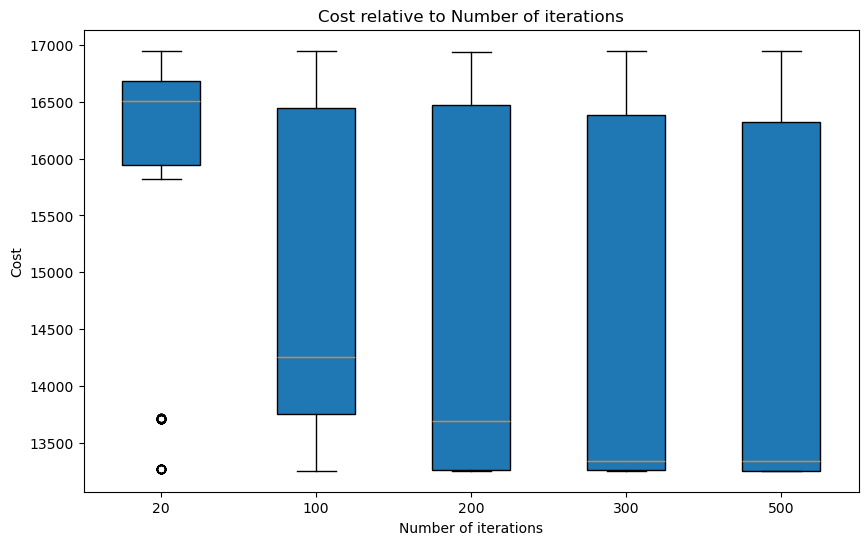

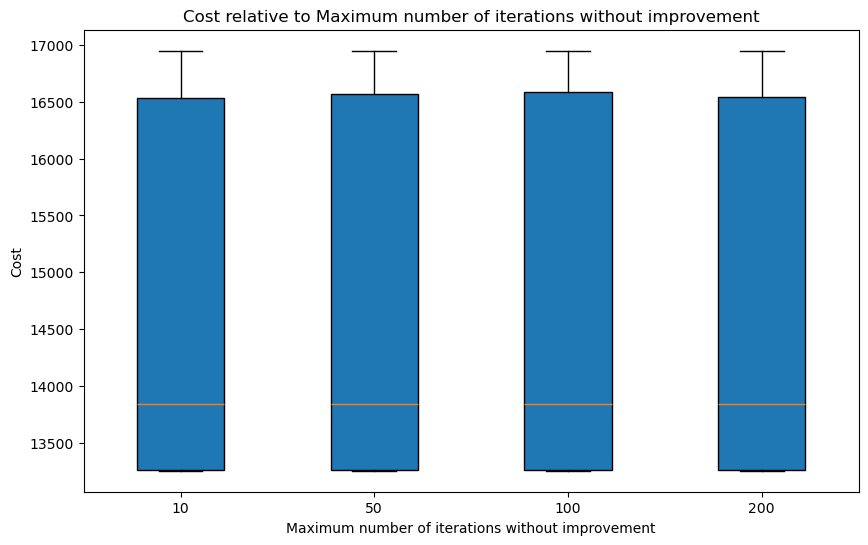

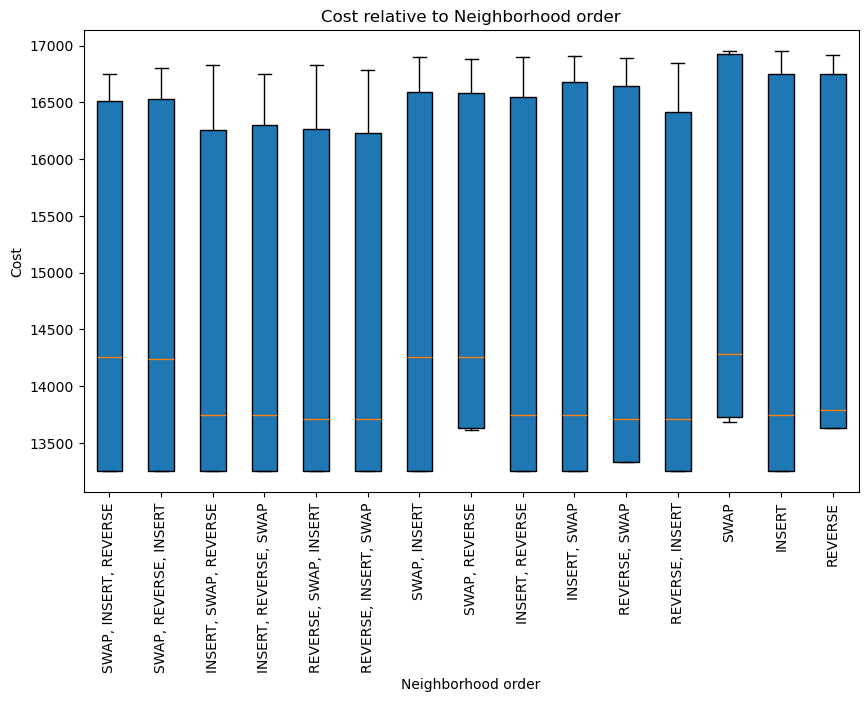

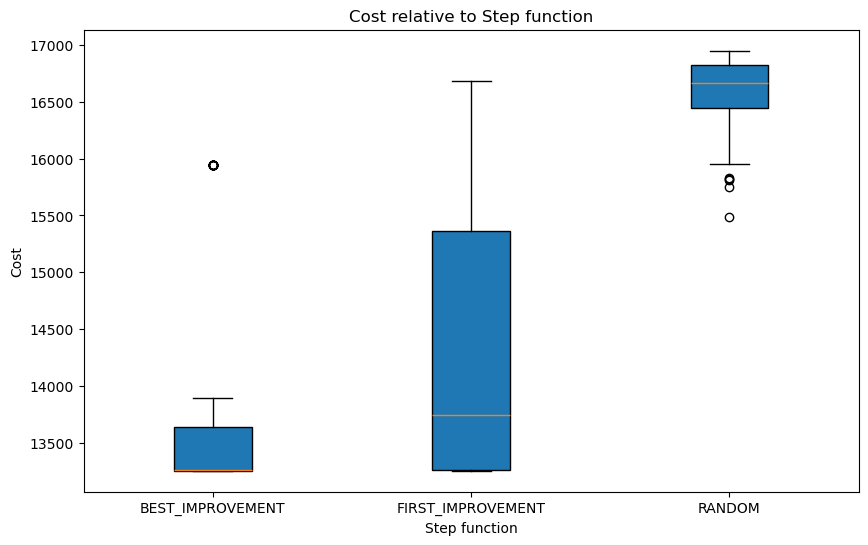

In [558]:
cost_func = lambda x: sum([result[2] for result in x]) / len(x)
#Graph the cost relative to the number of iterations
graph_results_box_plot(results, lambda x: x[0], cost_func, 'Number of iterations', 'Cost')

# Graph the cost relative to the maximum number of iterations without improvement
graph_results_box_plot(results, lambda x: x[1], cost_func, 'Maximum number of iterations without improvement', 'Cost')
    
# Graph the cost relative to the neighborhood order
neigborhood_names = {
    NeighborhoodType.SWAP: "SWAP",
    NeighborhoodType.INSERT: "INSERT",
    NeighborhoodType.REVERSE: "REVERSE"
}
graph_results_box_plot(results, (lambda x: ", ".join([neigborhood_names[neighborhood] for neighborhood in x[2]])), cost_func, 'Neighborhood order', 'Cost', x_rotation=90)
    
# Graph the cost relative to the step function
names_dict = {
        StepFunction.BEST_IMPROVEMENT: "BEST_IMPROVEMENT",
        StepFunction.FIRST_IMPROVEMENT: "FIRST_IMPROVEMENT",
        StepFunction.RANDOM: "RANDOM"
}
graph_results_box_plot(results, lambda x: names_dict[x[3]], cost_func, 'Step function', 'Cost')



From the results we can have these conclusions:
- Increasing the number of iterations above 200 doesn't have a significant impact on the cost on the small instances.
- Increasing the maximum number of iterations without improvement has no impact on the cost.
- The neighborhood order has an impact on the cost, but the impact is mostly in the number of step functions that are used. Also we can notice that REVERSE and INSERT earlier are generally better than SWAP earlier.
- The step function has a significant impact on the cost, with the best improvement step function giving the best results with first improvement being worse with the random being worst by far.

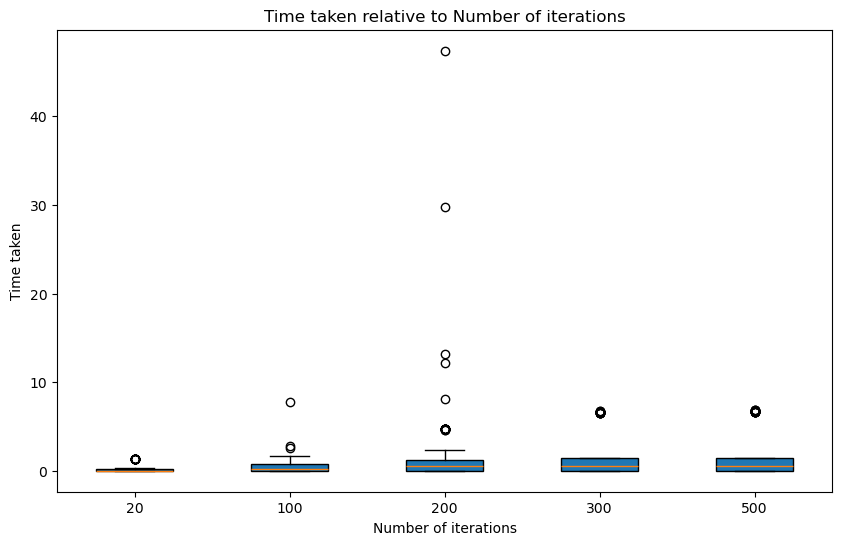

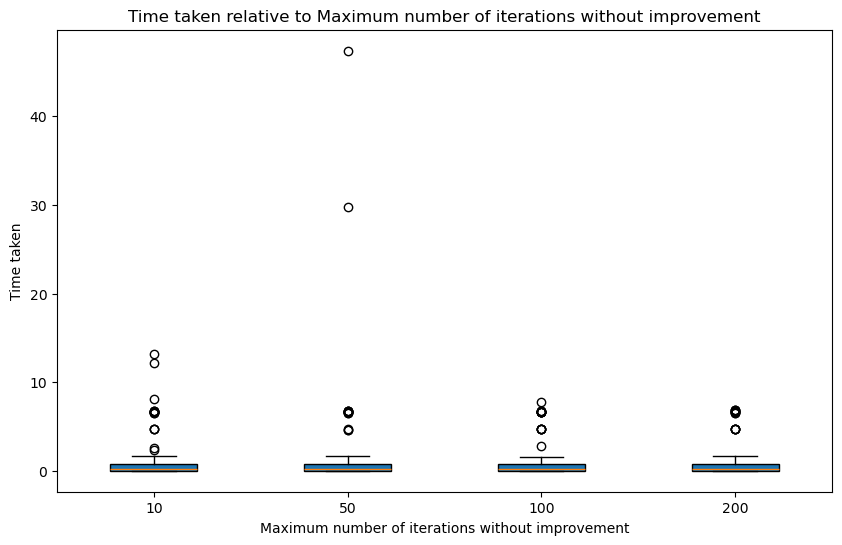

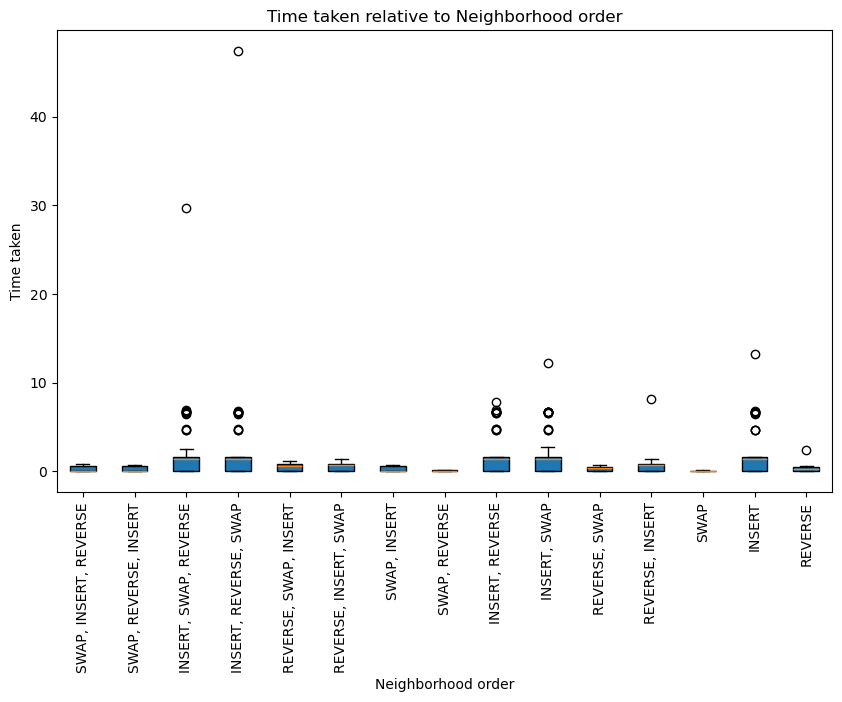

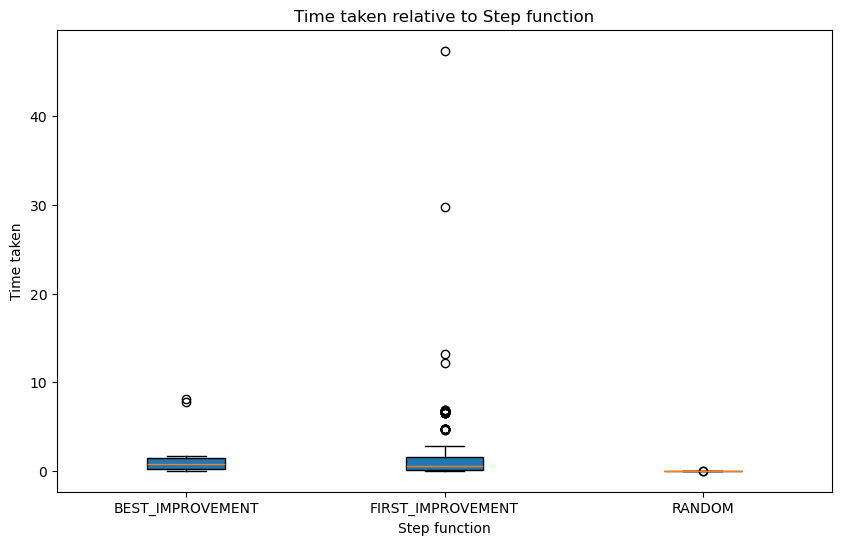

In [559]:
time_taken_func = lambda x: sum([result[3].runtime for result in x]) / len(x)
#Graph the Time taken relative to the number of iterations
graph_results_box_plot(results, lambda x: x[0], time_taken_func, 'Number of iterations', 'Time taken')

# Graph the Time taken relative to the maximum number of iterations without improvement
graph_results_box_plot(results, lambda x: x[1], time_taken_func, 'Maximum number of iterations without improvement', 'Time taken')
    
# Graph the Time taken relative to the neighborhood order
neigborhood_names = {
    NeighborhoodType.SWAP: "SWAP",
    NeighborhoodType.INSERT: "INSERT",
    NeighborhoodType.REVERSE: "REVERSE"
}
graph_results_box_plot(results, (lambda x: ", ".join([neigborhood_names[neighborhood] for neighborhood in x[2]])), time_taken_func, 'Neighborhood order', 'Time taken', x_rotation=90)
    
# Graph the Time taken relative to the step function
names_dict = {
        StepFunction.BEST_IMPROVEMENT: "BEST_IMPROVEMENT",
        StepFunction.FIRST_IMPROVEMENT: "FIRST_IMPROVEMENT",
        StepFunction.RANDOM: "RANDOM"
}
graph_results_box_plot(results, lambda x: names_dict[x[3]], time_taken_func, 'Step function', 'Time taken')

From the time results we can conclude the following:
- Increasing the number of iterations has a linear impact on the time taken until about 200 iterations, after which the effect is negligible.
- Increasing the maximum number of iterations without improvement has almost no impact on the time taken.
- The order of the neighborhood has an impact on the time taken, according to how slow the neighborhood functions are. SWAP is the fastest, REVERSE is the second fastest, and INSERT is the slowest.
- In the step function, the random step is by far the fastest but gives bad results, the first improvement is generally faster than the best improvement but is less consistent in the time taken.

The testing will continue with a more limited set of parameters and on the medium instances. The neighborhood order will be limited to the ones with the fastest performance (SWAP first) as others are note viable on larger instances.

In [580]:
parameters = {
    "max_iter": [50, 100, 300],
    "max_no_improve": [10],
    "neighborhood_order": [
        (NeighborhoodType.SWAP, NeighborhoodType.INSERT, NeighborhoodType.REVERSE),
        (NeighborhoodType.SWAP, NeighborhoodType.REVERSE, NeighborhoodType.INSERT),
        (NeighborhoodType.SWAP, NeighborhoodType.INSERT),
        (NeighborhoodType.SWAP, NeighborhoodType.REVERSE),
    ],
    "step_function": [StepFunction.BEST_IMPROVEMENT, StepFunction.FIRST_IMPROVEMENT]
}

# Generate all possible combinations of parameters
parameter_combinations = list(itertools.product(*parameters.values()))

results = defaultdict(list)

for i, combination in enumerate(parameter_combinations):
    print(f"Combination {i + 1}/{len(parameter_combinations)}")
    for item in items_tuning_med:
        graph, ordering = load_and_order_instance(item)
        constraints = [(key, item[0]) for key, item in graph.constraints.items() if len(item)>0]
    
        objective_function = cost_function_bit
    
        vnd = DeltaImprovedVND(
            graph=graph,
            initial_solution=ordering,
            step_function=combination[3],
            max_iter=combination[0],
            max_no_improve=combination[1],
            neighborhood_order=combination[2],
        )
    
        best_solution, best_cost, stats = vnd.vnd_search()
        
        results[tuple(combination)].append((item, best_solution, best_cost, stats))

Combination 1/24
Combination 2/24
Combination 3/24
Combination 4/24
Combination 5/24
Combination 6/24
Combination 7/24
Combination 8/24
Combination 9/24
Combination 10/24
Combination 11/24
Combination 12/24
Combination 13/24
Combination 14/24
Combination 15/24
Combination 16/24
Combination 17/24
Combination 18/24
Combination 19/24
Combination 20/24
Combination 21/24
Combination 22/24
Combination 23/24
Combination 24/24


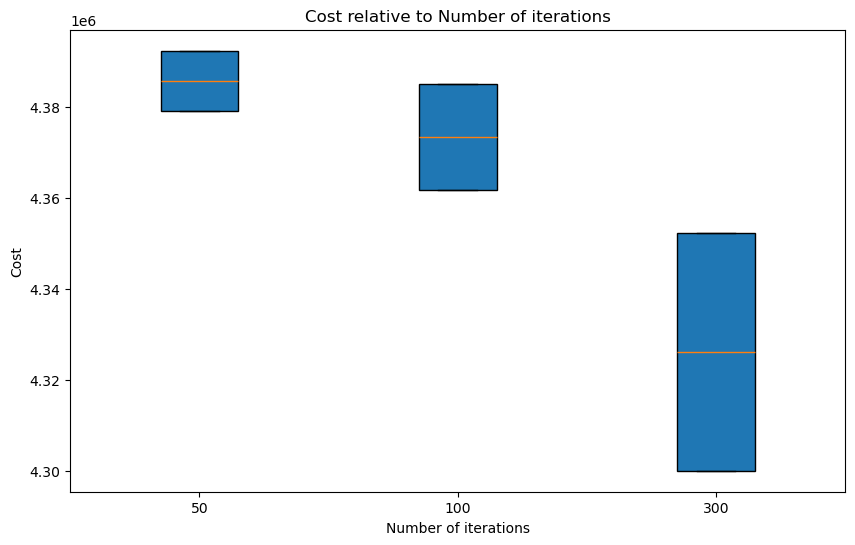

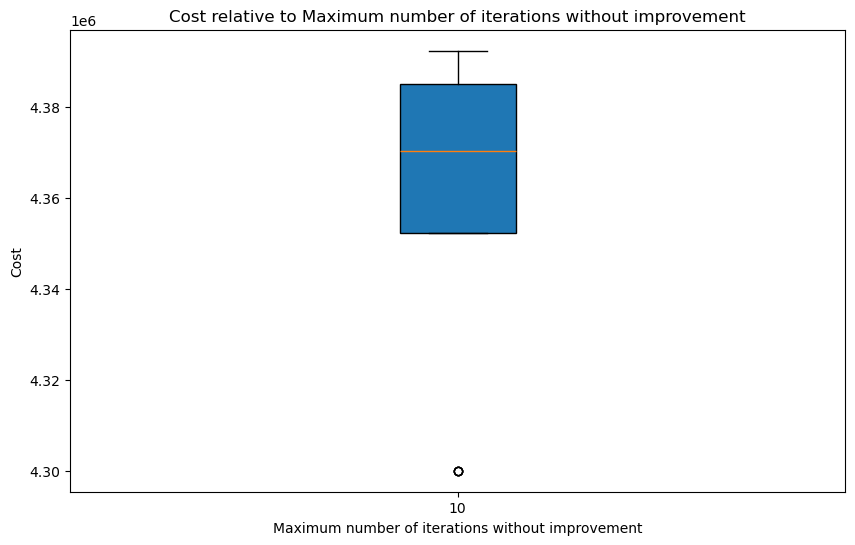

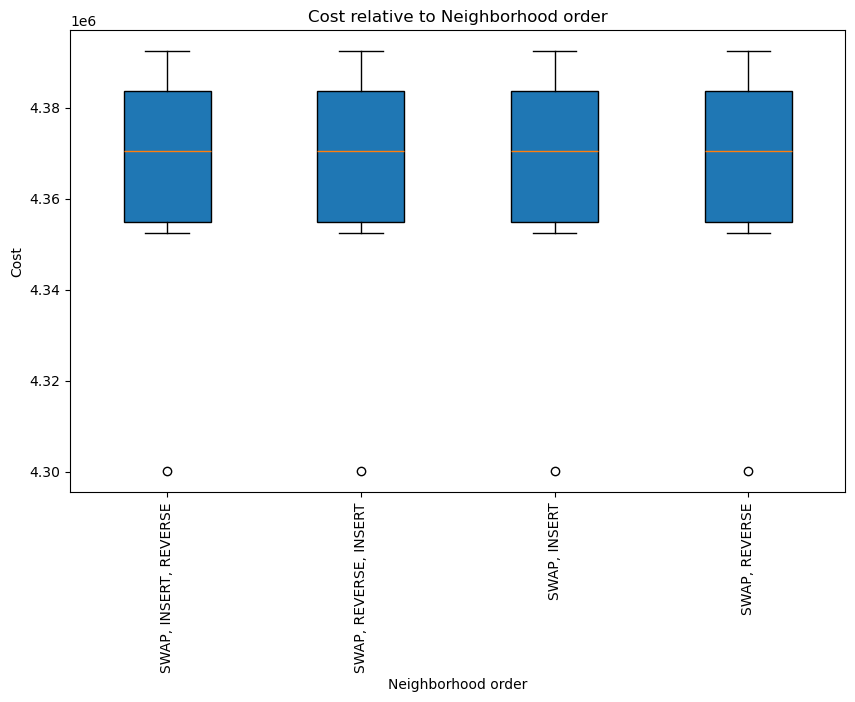

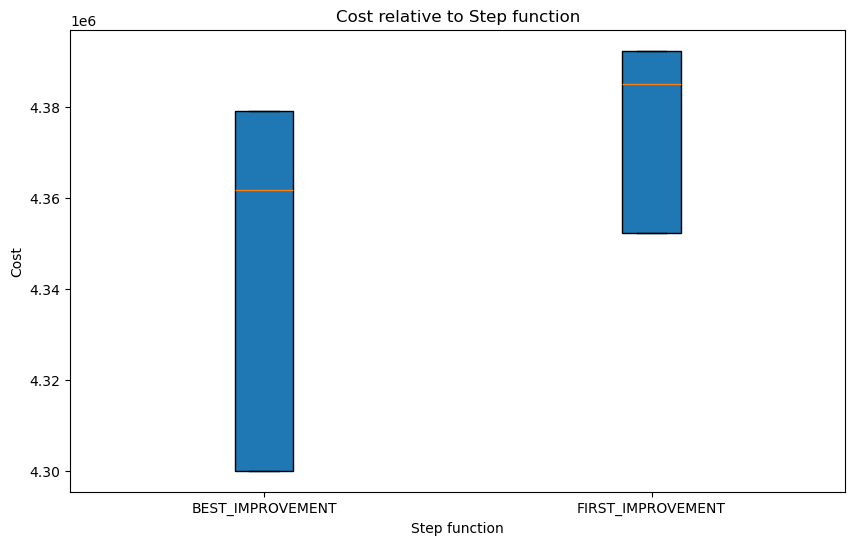

In [581]:
cost_func = lambda x: sum([result[2] for result in x]) / len(x)
#Graph the cost relative to the number of iterations
graph_results_box_plot(results, lambda x: x[0], cost_func, 'Number of iterations', 'Cost')

# Graph the cost relative to the maximum number of iterations without improvement
graph_results_box_plot(results, lambda x: x[1], cost_func, 'Maximum number of iterations without improvement', 'Cost')
    
# Graph the cost relative to the neighborhood order
neigborhood_names = {
    NeighborhoodType.SWAP: "SWAP",
    NeighborhoodType.INSERT: "INSERT",
    NeighborhoodType.REVERSE: "REVERSE"
}
graph_results_box_plot(results, (lambda x: ", ".join([neigborhood_names[neighborhood] for neighborhood in x[2]])), cost_func, 'Neighborhood order', 'Cost', x_rotation=90)
    
# Graph the cost relative to the step function
names_dict = {
        StepFunction.BEST_IMPROVEMENT: "BEST_IMPROVEMENT",
        StepFunction.FIRST_IMPROVEMENT: "FIRST_IMPROVEMENT",
        StepFunction.RANDOM: "RANDOM"
}
graph_results_box_plot(results, lambda x: names_dict[x[3]], cost_func, 'Step function', 'Cost')



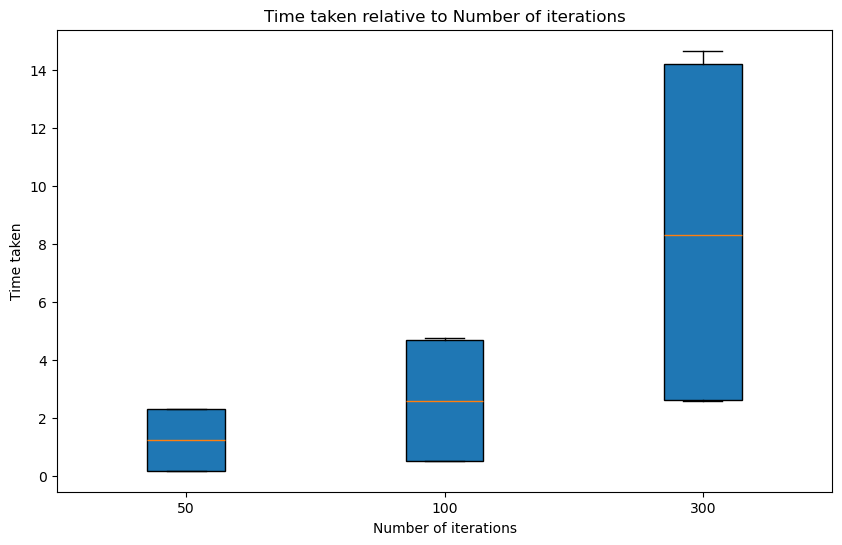

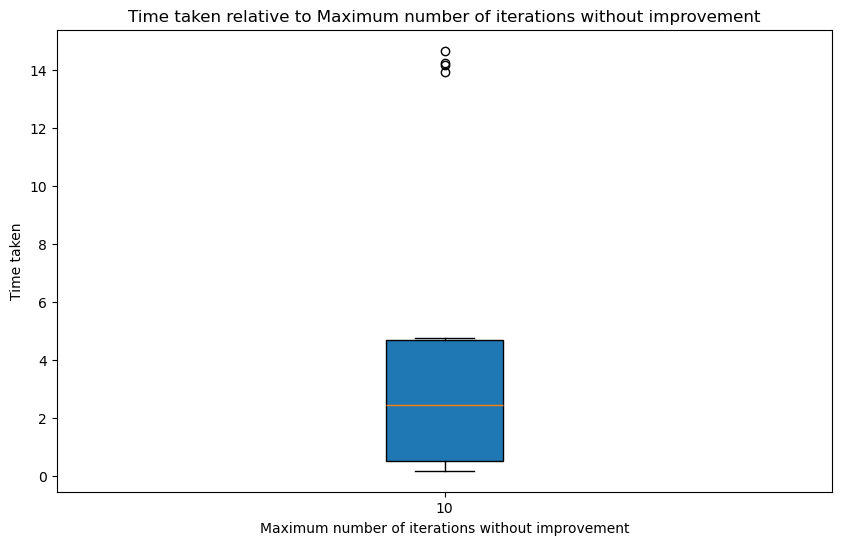

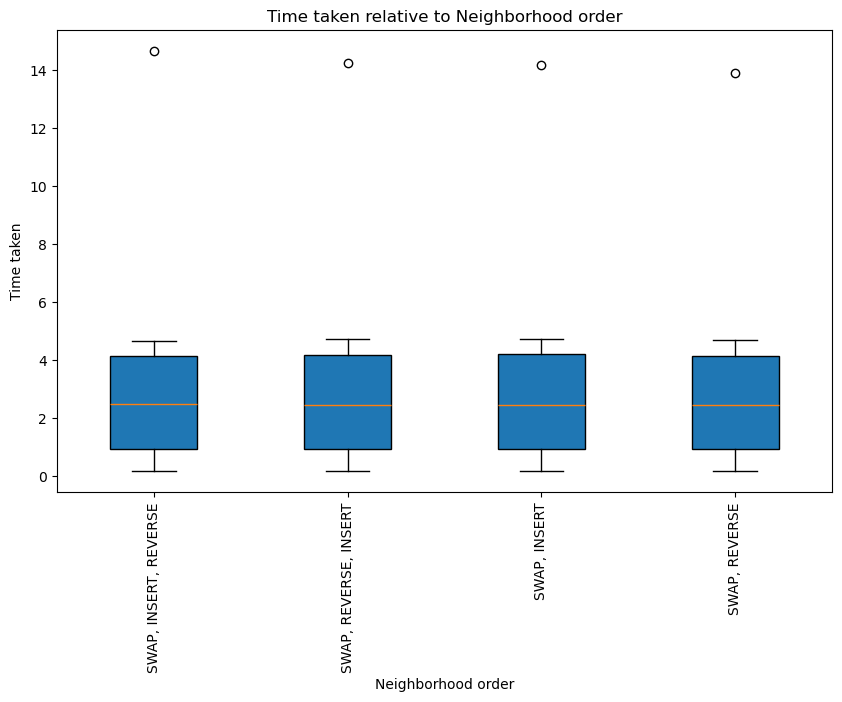

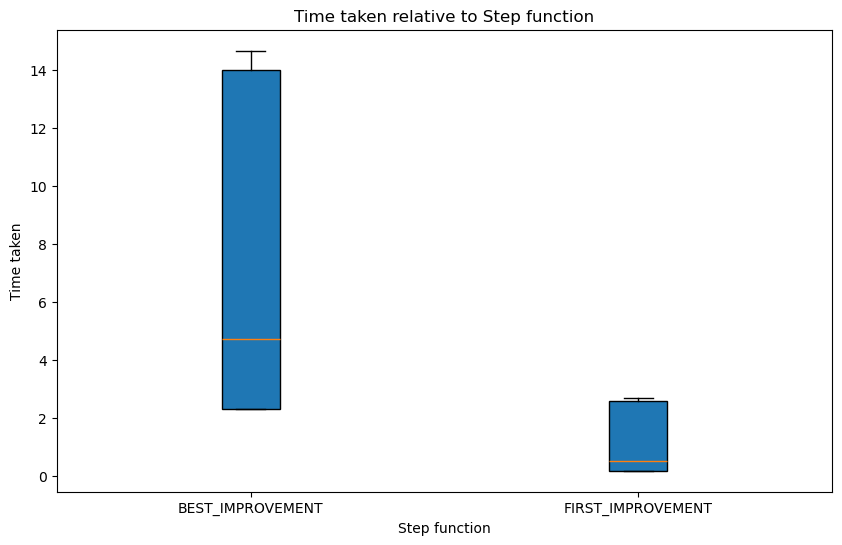

In [582]:
time_taken_func = lambda x: sum([result[3].runtime for result in x]) / len(x)
#Graph the Time taken relative to the number of iterations
graph_results_box_plot(results, lambda x: x[0], time_taken_func, 'Number of iterations', 'Time taken')

# Graph the Time taken relative to the maximum number of iterations without improvement
graph_results_box_plot(results, lambda x: x[1], time_taken_func, 'Maximum number of iterations without improvement', 'Time taken')
    
# Graph the Time taken relative to the neighborhood order
neigborhood_names = {
    NeighborhoodType.SWAP: "SWAP",
    NeighborhoodType.INSERT: "INSERT",
    NeighborhoodType.REVERSE: "REVERSE"
}
graph_results_box_plot(results, (lambda x: ", ".join([neigborhood_names[neighborhood] for neighborhood in x[2]])), time_taken_func, 'Neighborhood order', 'Time taken', x_rotation=90)
    
# Graph the Time taken relative to the step function
names_dict = {
        StepFunction.BEST_IMPROVEMENT: "BEST_IMPROVEMENT",
        StepFunction.FIRST_IMPROVEMENT: "FIRST_IMPROVEMENT",
        StepFunction.RANDOM: "RANDOM"
}
graph_results_box_plot(results, lambda x: names_dict[x[3]], time_taken_func, 'Step function', 'Time taken')

For further testing, the parameter combinations will be manually selected.

In [589]:
# Generate all possible combinations of parameters
parameter_combinations = [(50, StepFunction.BEST_IMPROVEMENT), (100, StepFunction.BEST_IMPROVEMENT), (50, StepFunction.FIRST_IMPROVEMENT), (100, StepFunction.FIRST_IMPROVEMENT), (300, StepFunction.FIRST_IMPROVEMENT)]

results = defaultdict(list)

for i, combination in enumerate(parameter_combinations):
    print(f"Combination {i + 1}/{len(parameter_combinations)}")
    for item in items_tuning_med_large:
        graph, ordering = load_and_order_instance(item)
        constraints = [(key, item[0]) for key, item in graph.constraints.items() if len(item)>0]
    
        objective_function = cost_function_bit
    
        vnd = DeltaImprovedVND(
            graph=graph,
            initial_solution=ordering,
            step_function=combination[1],
            max_iter=combination[0],
            max_no_improve=10,
            neighborhood_order=[NeighborhoodType.SWAP, NeighborhoodType.REVERSE, NeighborhoodType.INSERT],
        )
    
        best_solution, best_cost, stats = vnd.vnd_search()
        
        results[tuple(combination)].append((item, best_solution, best_cost, stats))

Combination 1/5
Combination 2/5
Combination 3/5
Combination 4/5
Combination 5/5


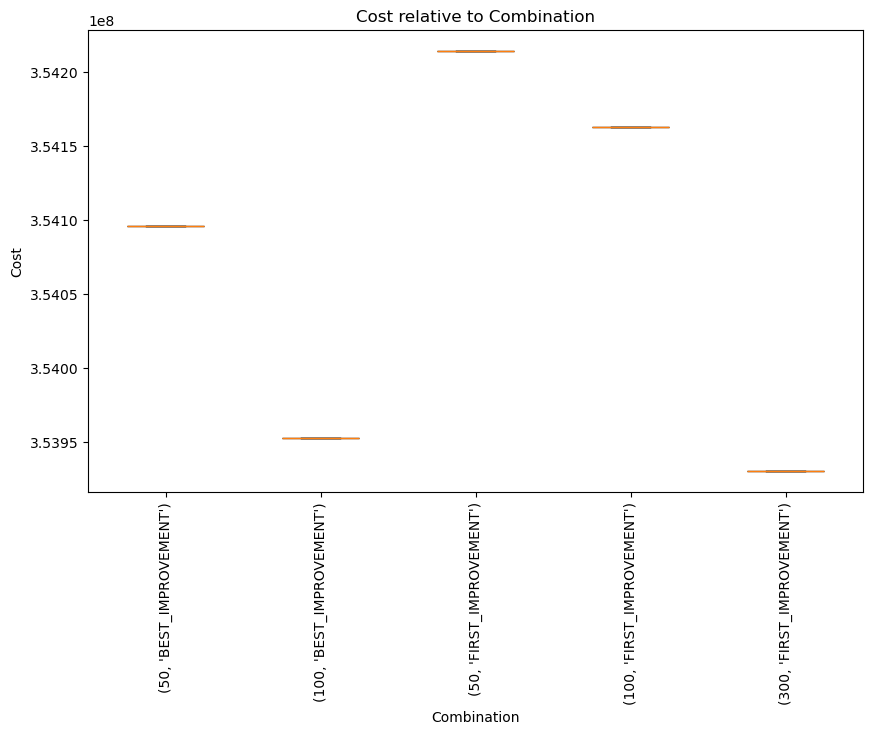

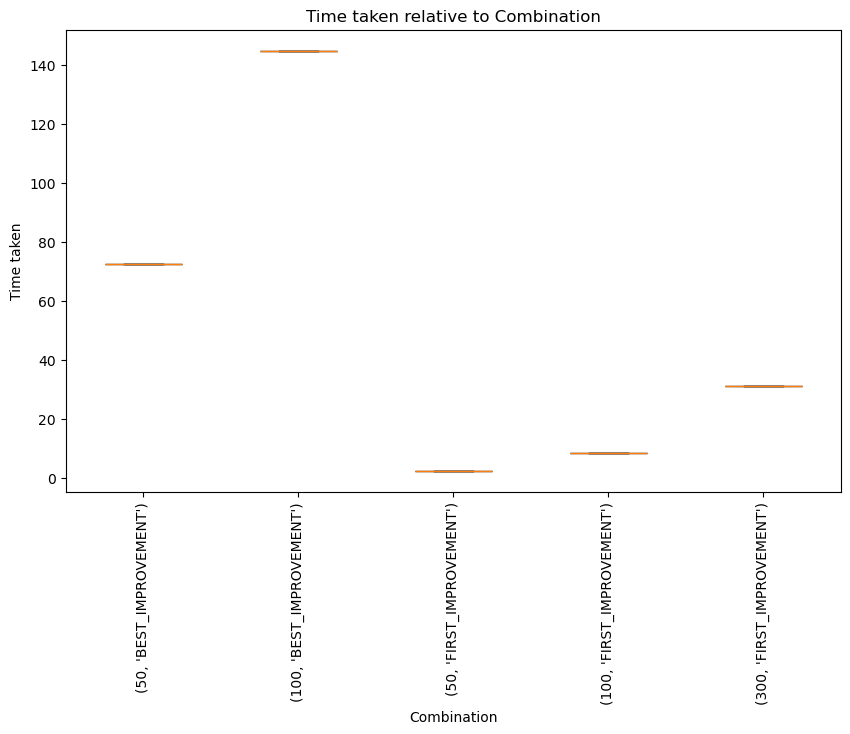

In [603]:
step_names_dict = {
        StepFunction.BEST_IMPROVEMENT: "BEST_IMPROVEMENT",
        StepFunction.FIRST_IMPROVEMENT: "FIRST_IMPROVEMENT",
        StepFunction.RANDOM: "RANDOM"
}
graph_results_box_plot(results, lambda x: (x[0], step_names_dict[x[1]]), cost_func, 'Combination', 'Cost', x_rotation=90)
graph_results_box_plot(results, lambda x: (x[0], step_names_dict[x[1]]), time_taken_func, 'Combination', 'Time taken', x_rotation=90)

In [611]:
# Generate all possible combinations of parameters
parameter_combinations = [(20, StepFunction.BEST_IMPROVEMENT), (50, StepFunction.BEST_IMPROVEMENT), (20, StepFunction.FIRST_IMPROVEMENT), (50, StepFunction.FIRST_IMPROVEMENT), (100, StepFunction.FIRST_IMPROVEMENT), (300, StepFunction.FIRST_IMPROVEMENT)]

results = defaultdict(list)

for i, combination in enumerate(parameter_combinations):
    print(f"Combination {i + 1}/{len(parameter_combinations)}")
    for item in items_tuning_large[:3]:
        graph, ordering = load_and_order_instance(item)
        constraints = [(key, item[0]) for key, item in graph.constraints.items() if len(item)>0]
    
        objective_function = cost_function_bit
    
        vnd = DeltaImprovedVND(
            graph=graph,
            initial_solution=ordering,
            step_function=combination[1],
            max_iter=combination[0],
            max_no_improve=10,
            neighborhood_order=[NeighborhoodType.SWAP, NeighborhoodType.REVERSE, NeighborhoodType.INSERT],
            verbose=True
        )
    
        best_solution, best_cost, stats = vnd.vnd_search()
        
        results[tuple(combination)].append((item, best_solution, best_cost, stats))

Combination 1/6
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Combination 2/6
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Ite

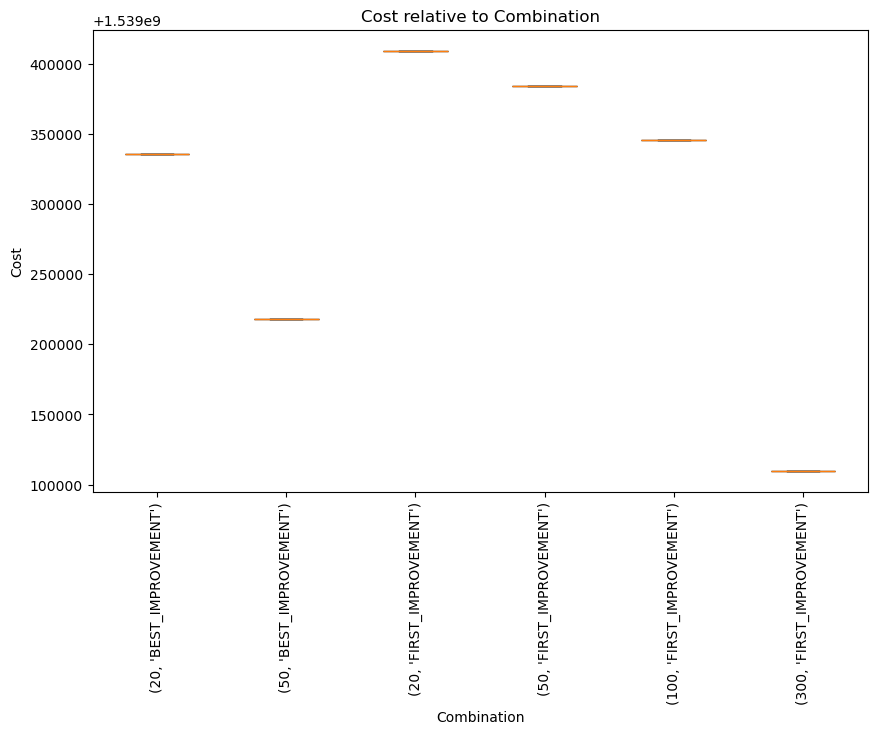

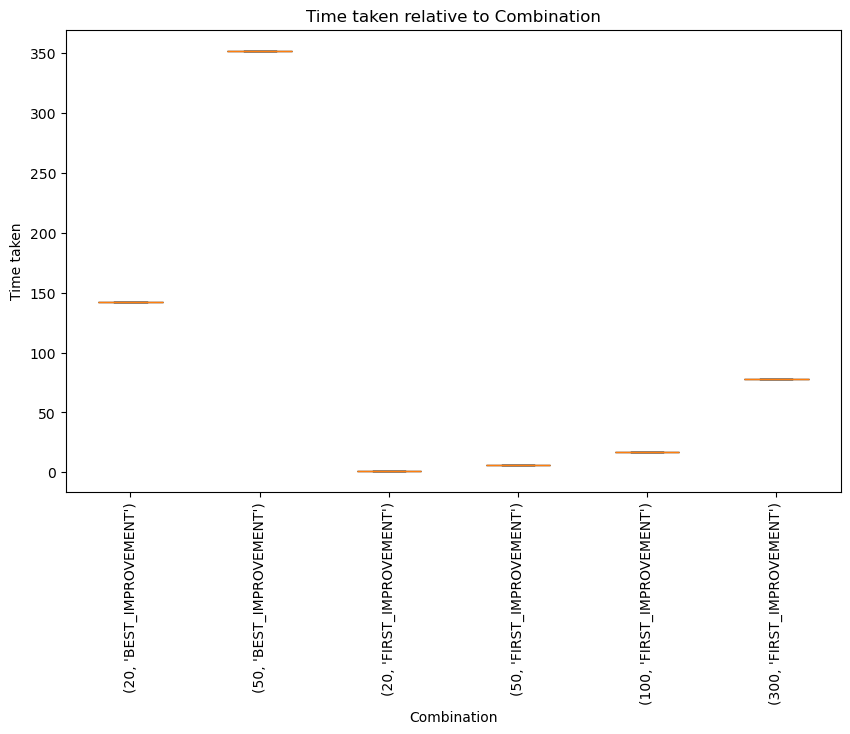

In [612]:
step_names_dict = {
        StepFunction.BEST_IMPROVEMENT: "BEST_IMPROVEMENT",
        StepFunction.FIRST_IMPROVEMENT: "FIRST_IMPROVEMENT",
        StepFunction.RANDOM: "RANDOM"
}
graph_results_box_plot(results, lambda x: (x[0], step_names_dict[x[1]]), cost_func, 'Combination', 'Cost', x_rotation=90)
graph_results_box_plot(results, lambda x: (x[0], step_names_dict[x[1]]), time_taken_func, 'Combination', 'Time taken', x_rotation=90)

### GVNS Tuning

In [75]:
# Test GVNS
parameters = {
    "max_iter": [5, 10, 25],
    "vnd_step_function": [StepFunction.BEST_IMPROVEMENT, StepFunction.FIRST_IMPROVEMENT],
    "vnd_max_iter": [10, 20, 50],
    "shaking_neighborhoods": [
        (swap_neighborhood_shake, insert_neighborhood_shake, reverse_neighborhood_shake),
        (swap_neighborhood_shake, n_swap_neighborhood_shake_generator(2), insert_neighborhood_shake, reverse_neighborhood_shake),
        (swap_neighborhood_shake, n_swap_neighborhood_shake_generator(3), insert_neighborhood_shake, reverse_neighborhood_shake),
        (swap_neighborhood_shake, n_swap_neighborhood_shake_generator(2), n_swap_neighborhood_shake_generator(4), insert_neighborhood_shake, reverse_neighborhood_shake),
        (swap_neighborhood_shake,  insert_neighborhood_shake, reverse_neighborhood_shake, n_swap_neighborhood_shake_generator(2), n_swap_neighborhood_shake_generator(3)),
        (swap_neighborhood_shake, n_swap_neighborhood_shake_generator(2), n_swap_neighborhood_shake_generator(4), n_swap_neighborhood_shake_generator(6), insert_neighborhood_shake, reverse_neighborhood_shake),
    ]
}

# Generate all possible combinations of parameters
parameter_combinations = list(itertools.product(*parameters.values()))

results = defaultdict(list)

for i, combination in enumerate(parameter_combinations):
    print(f"Combination {i + 1}/{len(parameter_combinations)}")
    for item in items_tuning_small:
        graph, ordering = load_and_order_instance(item)
        constraints = [(key, item[0]) for key, item in graph.constraints.items() if len(item)>0]
    
        objective_function = cost_function_bit
    
        gvns = GVNS(
            graph=graph,
            initial_solution=ordering,
            shaking_neighborhoods=combination[3],
            local_search_neighborhoods=[NeighborhoodType.SWAP, NeighborhoodType.REVERSE, NeighborhoodType.INSERT],
            objective_function=objective_function,
            max_iter=combination[0],
            verbose=False,
            vnd_class=DeltaImprovedVND,
            vnd_step_function=combination[1],
            vnd_max_iter=combination[2],
        )
        
        best_solution, best_cost, stats = gvns.find_solution()
        
        results[tuple(combination)].append((item, best_solution, best_cost, stats))


Combination 1/108
Combination 2/108
Combination 3/108
Combination 4/108
Combination 5/108
Combination 6/108
Combination 7/108
Combination 8/108
Combination 9/108
Combination 10/108
Combination 11/108
Combination 12/108
Combination 13/108
Combination 14/108
Combination 15/108
Combination 16/108
Combination 17/108
Combination 18/108
Combination 19/108
Combination 20/108
Combination 21/108
Combination 22/108
Combination 23/108
Combination 24/108
Combination 25/108
Combination 26/108
Combination 27/108
Combination 28/108
Combination 29/108
Combination 30/108
Combination 31/108
Combination 32/108
Combination 33/108
Combination 34/108
Combination 35/108
Combination 36/108
Combination 37/108
Combination 38/108
Combination 39/108
Combination 40/108
Combination 41/108
Combination 42/108
Combination 43/108
Combination 44/108
Combination 45/108
Combination 46/108
Combination 47/108
Combination 48/108
Combination 49/108
Combination 50/108
Combination 51/108
Combination 52/108
Combination 53/108
Co

In [40]:
print(len(results))

108


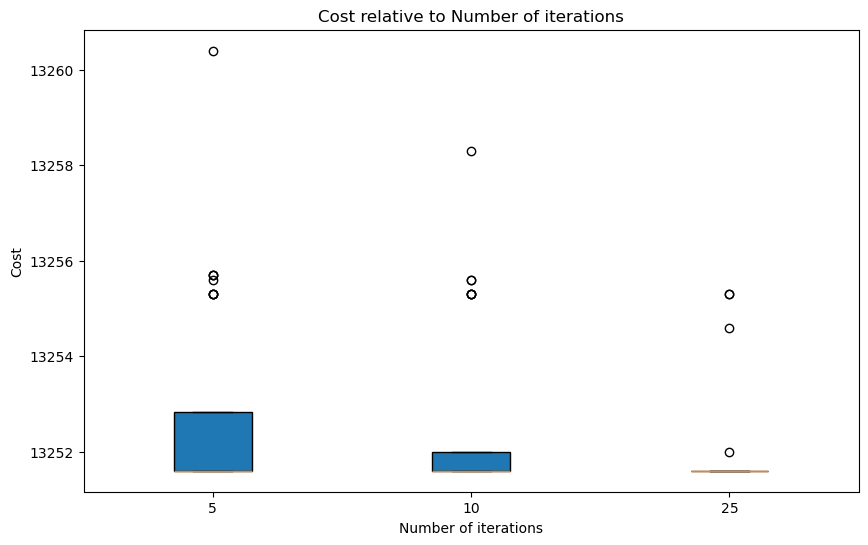

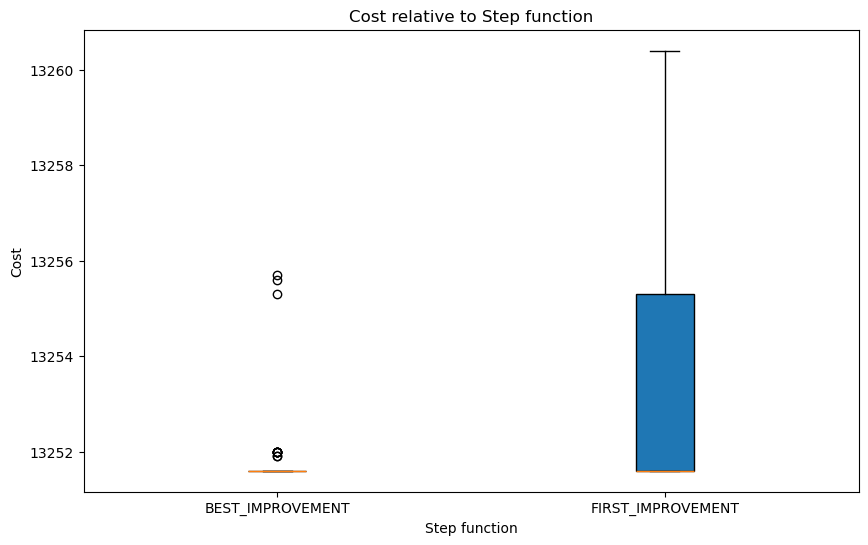

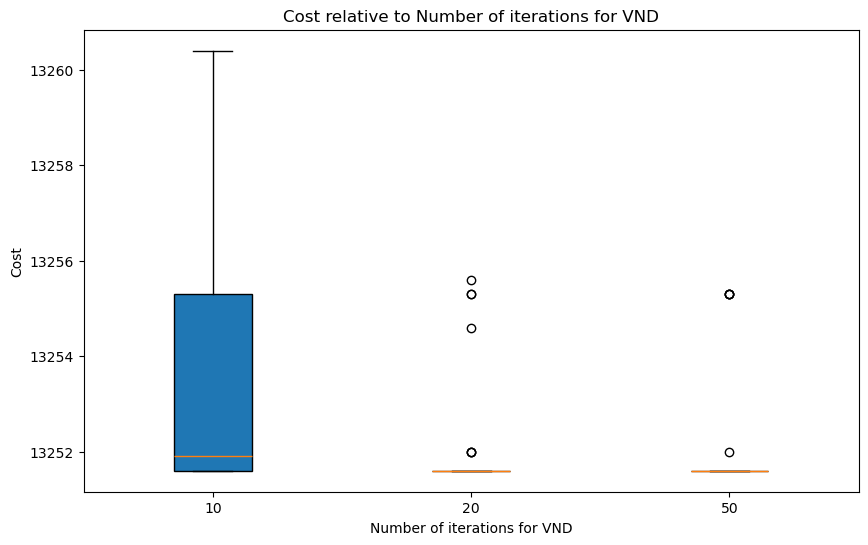

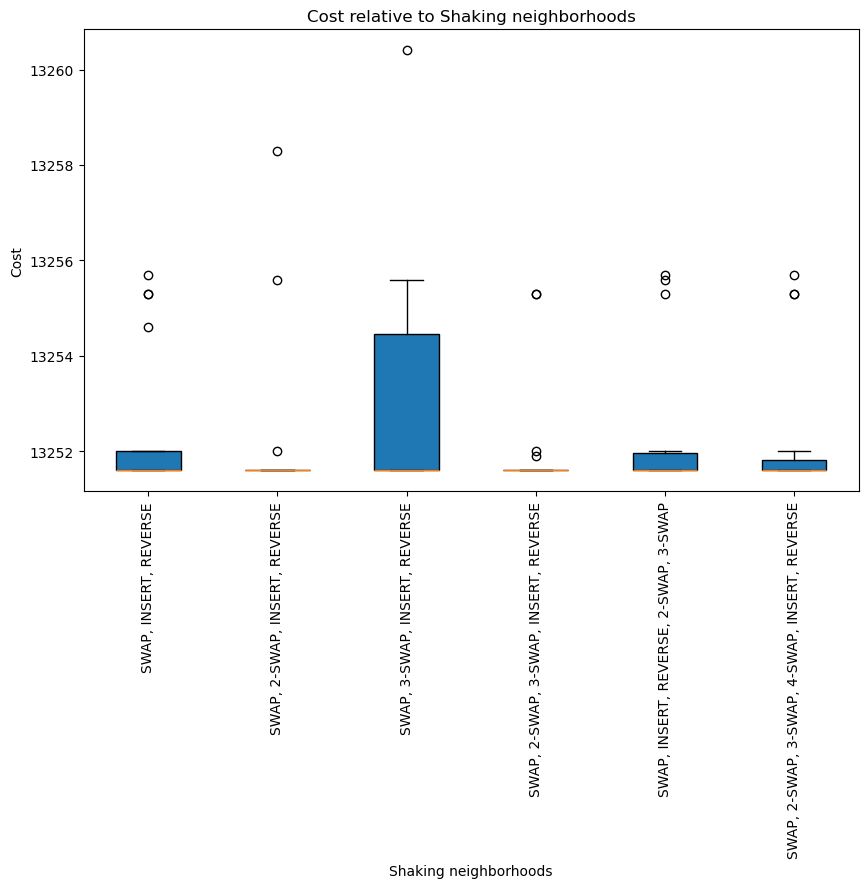

In [76]:
cost_func = lambda x: sum([result[2] for result in x]) / len(x)
#Graph the cost relative to the number of iterations
graph_results_box_plot(results, lambda x: x[0], cost_func, 'Number of iterations', 'Cost')

# Graph the cost relative to the step function
step_names_dict = {
        StepFunction.BEST_IMPROVEMENT: "BEST_IMPROVEMENT",
        StepFunction.FIRST_IMPROVEMENT: "FIRST_IMPROVEMENT",
        StepFunction.RANDOM: "RANDOM"
}
graph_results_box_plot(results, lambda x: step_names_dict[x[1]], cost_func, 'Step function', 'Cost')

#Graph the cost relative to the number of iterations
graph_results_box_plot(results, lambda x: x[2], cost_func, 'Number of iterations for VND', 'Cost')
    
# Graph the cost relative to the neighborhood order
shaking_neighborhoods_names = ["SWAP, INSERT, REVERSE", "SWAP, 2-SWAP, INSERT, REVERSE", "SWAP, 3-SWAP, INSERT, REVERSE", "SWAP, 2-SWAP, 3-SWAP, INSERT, REVERSE", "SWAP, INSERT, REVERSE, 2-SWAP, 3-SWAP", "SWAP, 2-SWAP, 3-SWAP, 4-SWAP, INSERT, REVERSE"]
graph_results_box_plot(results, (lambda x: shaking_neighborhoods_names[parameters["shaking_neighborhoods"].index(x[3])]), cost_func, 'Shaking neighborhoods', 'Cost', x_rotation=90)

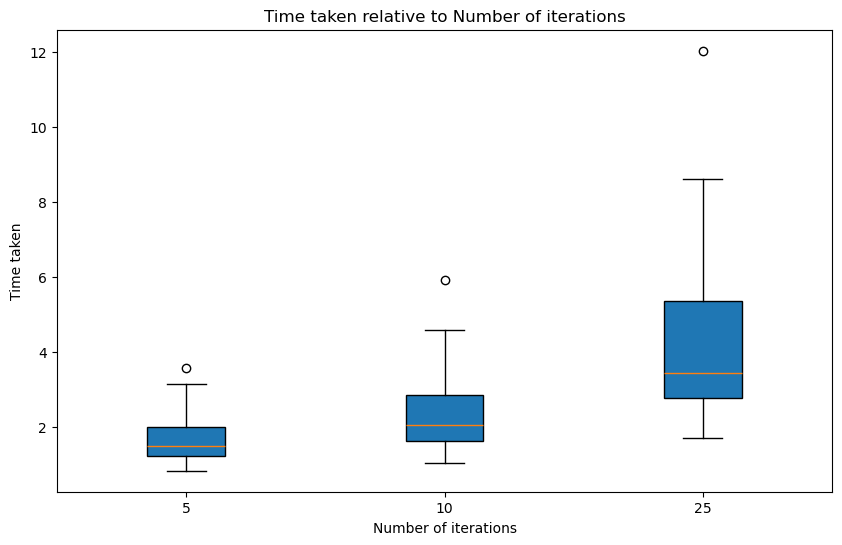

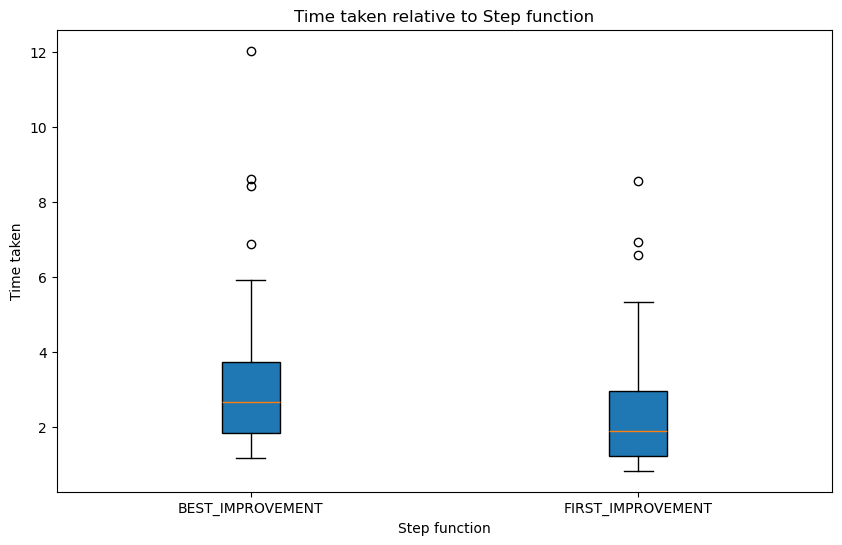

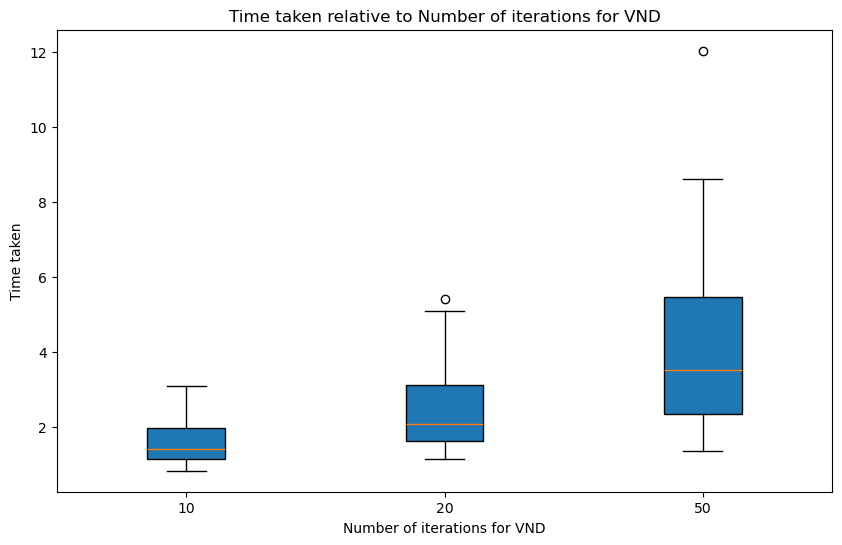

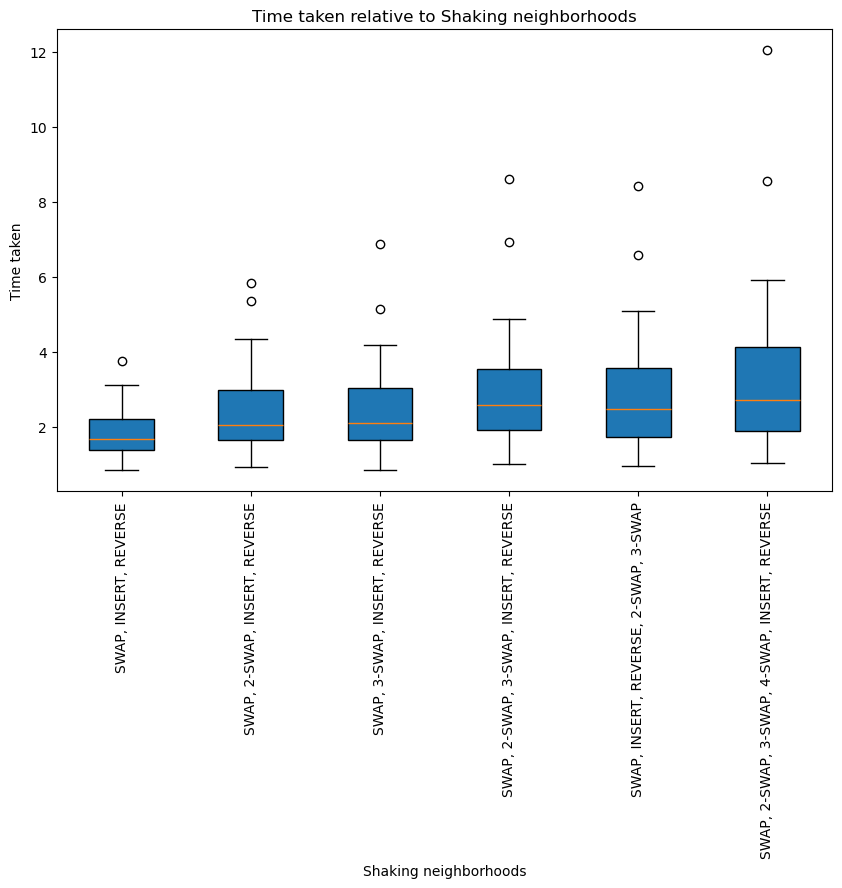

In [77]:
time_taken_func = lambda x: sum([result[3].runtime for result in x]) / len(x)
#Graph the Time taken relative to the number of iterations
graph_results_box_plot(results, lambda x: x[0], time_taken_func, 'Number of iterations', 'Time taken')

# Graph the Time taken relative to the step function
step_names_dict = {
        StepFunction.BEST_IMPROVEMENT: "BEST_IMPROVEMENT",
        StepFunction.FIRST_IMPROVEMENT: "FIRST_IMPROVEMENT",
        StepFunction.RANDOM: "RANDOM"
}
graph_results_box_plot(results, lambda x: step_names_dict[x[1]], time_taken_func, 'Step function', 'Time taken')

#Graph the Time taken relative to the number of iterations
graph_results_box_plot(results, lambda x: x[2], time_taken_func, 'Number of iterations for VND', 'Time taken')

# Graph the Time taken relative to the neighborhood order
shaking_neighborhoods_names = ["SWAP, INSERT, REVERSE", "SWAP, 2-SWAP, INSERT, REVERSE", "SWAP, 3-SWAP, INSERT, REVERSE", "SWAP, 2-SWAP, 3-SWAP, INSERT, REVERSE", "SWAP, INSERT, REVERSE, 2-SWAP, 3-SWAP", "SWAP, 2-SWAP, 3-SWAP, 4-SWAP, INSERT, REVERSE"]
graph_results_box_plot(results, (lambda x: shaking_neighborhoods_names[parameters["shaking_neighborhoods"].index(x[3])]), time_taken_func, 'Shaking neighborhoods', 'Time taken', x_rotation=90)



In [98]:
parameters = {
    "max_iter": [5, 10],
    "vnd_step_function": [StepFunction.FIRST_IMPROVEMENT],
    "vnd_max_iter": [10],
    "shaking_neighborhoods": [
        (swap_neighborhood_shake, n_swap_neighborhood_shake_generator(3), insert_neighborhood_shake, reverse_neighborhood_shake),
        (swap_neighborhood_shake,  insert_neighborhood_shake, reverse_neighborhood_shake, n_swap_neighborhood_shake_generator(2), n_swap_neighborhood_shake_generator(3)),
        (swap_neighborhood_shake, n_swap_neighborhood_shake_generator(2), insert_neighborhood_shake, reverse_neighborhood_shake, n_swap_neighborhood_shake_generator(4), n_swap_neighborhood_shake_generator(6)),
    ]
}

# Generate all possible combinations of parameters
parameter_combinations = list(itertools.product(*parameters.values()))

results = defaultdict(list)

for i, combination in enumerate(parameter_combinations):
    print(f"Combination {i + 1}/{len(parameter_combinations)}")
    for item in items_tuning_med:
        graph, ordering = load_and_order_instance(item)
        constraints = [(key, item[0]) for key, item in graph.constraints.items() if len(item)>0]
    
        objective_function = cost_function_bit
    
        gvns = GVNS(
            graph=graph,
            initial_solution=ordering,
            shaking_neighborhoods=combination[3],
            local_search_neighborhoods=[NeighborhoodType.SWAP, NeighborhoodType.REVERSE, NeighborhoodType.INSERT],
            objective_function=objective_function,
            max_iter=combination[0],
            verbose=False,
            vnd_class=DeltaImprovedVND,
            vnd_step_function=combination[1],
            vnd_max_iter=combination[2],
            vnd_max_no_improve=50
        )
        
        best_solution, best_cost, stats = gvns.find_solution()
        
        results[tuple(combination)].append((item, best_solution, best_cost, stats))

Combination 1/6
Combination 2/6
Combination 3/6
Combination 4/6
Combination 5/6
Combination 6/6


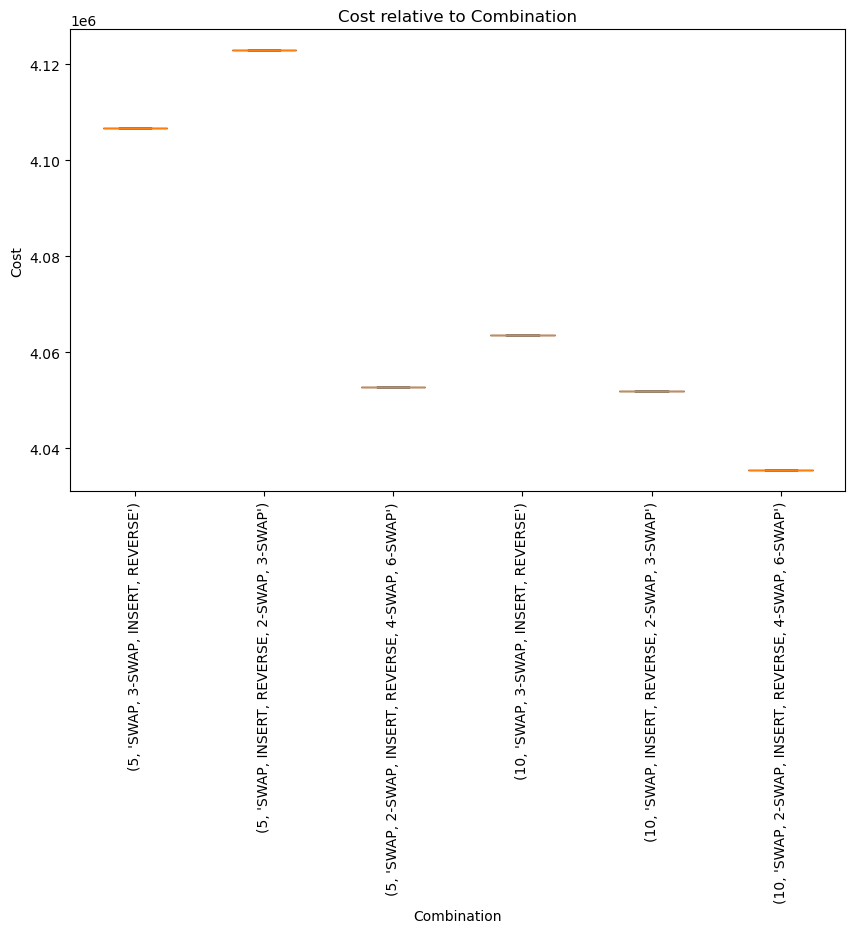

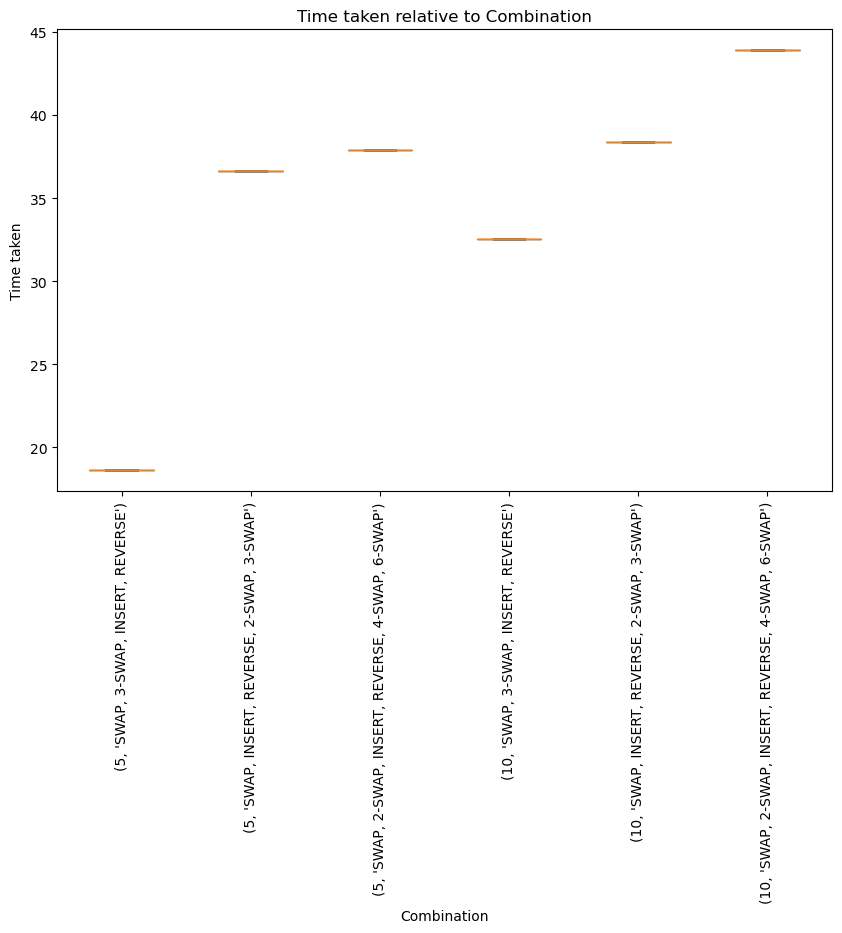

In [99]:
cost_func = lambda x: sum([result[2] for result in x]) / len(x)
time_taken_func = lambda x: sum([result[3].runtime for result in x]) / len(x)
#Graph the cost relative to the number of iterations
shaking_neighborhoods_names = ["SWAP, 3-SWAP, INSERT, REVERSE", 
                               "SWAP, INSERT, REVERSE, 2-SWAP, 3-SWAP", 
                               "SWAP, 2-SWAP, INSERT, REVERSE, 4-SWAP, 6-SWAP"]
graph_results_box_plot(results, lambda x: (x[0], shaking_neighborhoods_names[parameters["shaking_neighborhoods"].index(x[3])]), cost_func, 'Combination', 'Cost', x_rotation=90)
graph_results_box_plot(results, lambda x: (x[0], shaking_neighborhoods_names[parameters["shaking_neighborhoods"].index(x[3])]), time_taken_func, 'Combination', 'Time taken', x_rotation=90)

In [80]:
test_instances_path = "content/test_instances"
sizes = ["small", "medium", "medium_large", "large"]
test_items = {}
for size in sizes:
    test_items[size] = list_files_in_folder(f"{test_instances_path}/{size}")

In [81]:
def run_algorithm_multiple_times(item_path, algorithm_construct_func, algorithm_run_func, n=10):
    results = []
    for i in range(n):
        graph, ordering = load_and_order_instance(item_path)
        algorithm = algorithm_construct_func(graph, ordering)
        best_solution, best_cost, stats = algorithm_run_func(algorithm)
        results.append((best_solution, best_cost, stats))
    return results

def calculate_stats(results):
    costs = [result[1] for result in results]
    times = [result[2].runtime for result in results]
    
    return {
        "min_cost": min(costs),
        "max_cost": max(costs),
        "mean_cost": np.mean(costs),
        "median_cost": np.median(costs),
        "std_cost": np.std(costs),
        "min_time": min(times),
        "max_time": max(times),
        "mean_time": np.mean(times),
        "std_time": np.std(times),
        "median_time": np.median(times),
        "solution": results[np.argmin(costs)][0],
    }

def save_results_to_file(results, algorithm_name, path):
    file_name = os.path.join(path, f"{algorithm_name}.txt")
    
    with open(file_name, 'w') as f:
        average_cost = np.mean([stats['mean_cost'] for stats in results.values()])
        averate_time = np.mean([stats['mean_time'] for stats in results.values()])
        for item, stats in results.items():
            f.write(f"Instance: {item}\n")
            f.write(f"  Min cost: {stats['min_cost']}\n")
            f.write(f"  Max cost: {stats['max_cost']}\n")
            f.write(f"  Mean cost: {stats['mean_cost']}\n")
            f.write(f"  Median cost: {stats['median_cost']}\n")
            f.write(f"  Std cost: {stats['std_cost']}\n")
            f.write(f"  Min time: {stats['min_time']}\n")
            f.write(f"  Max time: {stats['max_time']}\n")
            f.write(f"  Mean time: {stats['mean_time']}\n")
            f.write(f"  Median time: {stats['median_time']}\n")
            f.write(f"  Std time: {stats['std_time']}\n")
            f.write(f"  Solution: {stats['solution']}\n")
            
        f.write(f"Average cost: {average_cost}\n")
        f.write(f"Average time: {averate_time}\n")

### VND and GVNS testing

In [74]:
algorithms = {
    "VND": (lambda graph, ordering, constraints: DeltaImprovedVND(
        graph=graph,
        initial_solution=ordering,
        step_function=StepFunction.FIRST_IMPROVEMENT,
        max_iter=250,
        neighborhood_order=[
            NeighborhoodType.SWAP,
            NeighborhoodType.REVERSE,
            NeighborhoodType.INSERT
        ]
    ), lambda algorithm: algorithm.vnd_search()),
    "GVNS": (lambda graph, ordering, constraints: GVNS(
        graph=graph,
        initial_solution=ordering,
        shaking_neighborhoods=[swap_neighborhood_shake, n_swap_neighborhood_shake_generator(3), insert_neighborhood_shake, reverse_neighborhood_shake],
        local_search_neighborhoods=[NeighborhoodType.SWAP, NeighborhoodType.REVERSE, NeighborhoodType.INSERT],
        objective_function=cost_function_bit,
        max_iter=3,
        verbose=False,
        vnd_class=DeltaImprovedVND,
        vnd_step_function=StepFunction.FIRST_IMPROVEMENT,
        vnd_max_iter=5,
    ), lambda algorithm: algorithm.find_solution())
}

for size, paths in test_items.items():
    print(f"Size: {size}")
    for algorithms_name, (construct_func, run_func) in algorithms.items():
        print(f"Algorithm: {algorithms_name}")
        algorithm_results = {}
        for path in paths:
            print(f"Instance: {path}")
            results = run_algorithm_multiple_times(path, construct_func, run_func, n=10)
            stats = calculate_stats(results)
            algorithm_results[path] = stats
        save_results_to_file(algorithm_results, algorithms_name, f"content/test_instances/{size}")
    

Size: small
Algorithm: VND
Instance: content/test_instances/small/inst_50_4_00006
Instance: content/test_instances/small/inst_50_4_00001
Instance: content/test_instances/small/inst_50_4_00008
Instance: content/test_instances/small/inst_50_4_00009
Instance: content/test_instances/small/inst_50_4_00007
Instance: content/test_instances/small/inst_50_4_00010
Instance: content/test_instances/small/inst_50_4_00002
Instance: content/test_instances/small/inst_50_4_00005
Instance: content/test_instances/small/inst_50_4_00004
Instance: content/test_instances/small/inst_50_4_00003
Algorithm: GVNS
Instance: content/test_instances/small/inst_50_4_00006
Instance: content/test_instances/small/inst_50_4_00001
Instance: content/test_instances/small/inst_50_4_00008
Instance: content/test_instances/small/inst_50_4_00009
Instance: content/test_instances/small/inst_50_4_00007
Instance: content/test_instances/small/inst_50_4_00010
Instance: content/test_instances/small/inst_50_4_00002
Instance: content/test

KeyboardInterrupt: 

In [83]:
# Large instances require different parameters
leftover_sizes = ["large"]
leftover_test_items = {}
for size in leftover_sizes:
    leftover_test_items[size] = list_files_in_folder(f"{test_instances_path}/{size}")

algorithms = {
    "VND": (lambda graph, ordering, constraints: DeltaImprovedVND(
        graph=graph,
        initial_solution=ordering,
        step_function=StepFunction.FIRST_IMPROVEMENT,
        max_iter=250,
        neighborhood_order=[
            NeighborhoodType.SWAP,
            NeighborhoodType.REVERSE,
            NeighborhoodType.INSERT
        ]
    ), lambda algorithm: algorithm.vnd_search()),
    "GVNS": (lambda graph, ordering, constraints: GVNS(
        graph=graph,
        initial_solution=ordering,
        shaking_neighborhoods=[swap_neighborhood_shake, n_swap_neighborhood_shake_generator(3), insert_neighborhood_shake, reverse_neighborhood_shake],
        local_search_neighborhoods=[NeighborhoodType.SWAP, NeighborhoodType.REVERSE, NeighborhoodType.INSERT],
        max_iter=2,
        objective_function=cost_function_bit,
        verbose=False,
        vnd_class=DeltaImprovedVND,
        vnd_step_function=StepFunction.FIRST_IMPROVEMENT,
        vnd_max_iter=3,
    ), lambda algorithm: algorithm.find_solution())
}

for size, paths in leftover_test_items.items():
    print(f"Size: {size}")
    for algorithms_name, (construct_func, run_func) in algorithms.items():
        print(f"Algorithm: {algorithms_name}")
        algorithm_results = {}
        for path in paths:
            print(f"Instance: {path}")
            results = run_algorithm_multiple_times(path, construct_func, run_func, n=1 if algorithms_name == "VND" else 5)
            stats = calculate_stats(results)
            algorithm_results[path] = stats
        save_results_to_file(algorithm_results, algorithms_name, f"content/test_instances/{size}")

Size: large
Algorithm: VND
Instance: content/test_instances/large/inst_1000_60_00010
Instance: content/test_instances/large/inst_1000_60_00003
Instance: content/test_instances/large/inst_1000_60_00004
Instance: content/test_instances/large/inst_1000_60_00005
Instance: content/test_instances/large/inst_1000_60_00002
Instance: content/test_instances/large/inst_1000_60_00009
Instance: content/test_instances/large/inst_1000_60_00007
Instance: content/test_instances/large/inst_1000_60_00001
Instance: content/test_instances/large/inst_1000_60_00006
Instance: content/test_instances/large/inst_1000_60_00008
Algorithm: GVNS
Instance: content/test_instances/large/inst_1000_60_00010
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/jurahostic/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/9v/ngk5y1xx5rx4d_zqj33qpjd80000gn/T/ipykernel_30288/3106035894.py", line 41, in <module>
    results = run_algorithm_multiple_times(path, construct_func, run_func, n=1 if algorithms_name == "VND" else 5)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/9v/ngk5y1xx5rx4d_zqj33qpjd80000gn/T/ipykernel_30288/788007537.py", line 7, in run_algorithm_multiple_times
    best_solution, best_cost, stats = algorithm_run_func(algorithm)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/9v/ngk5y1xx5rx4d_zqj33qpjd80000gn/T/ipykernel_30288/3106035894.py", line 31, in <lambda>
    ), lambda algorithm: algorithm.find_solution())
                      

### GVNS testing

In [82]:
sizes = ["small", "medium", "medium_large", "large"]

test_items = {}
for size in sizes:
    test_items[size] = list_files_in_folder(f"{test_instances_path}/{size}")

algorithms = {
    "GVNS": (lambda graph, ordering: GVNS(
        graph=graph,
        initial_solution=ordering,
        shaking_neighborhoods=[swap_neighborhood_shake, n_swap_neighborhood_shake_generator(3), insert_neighborhood_shake, reverse_neighborhood_shake],
        local_search_neighborhoods=[NeighborhoodType.SWAP, NeighborhoodType.REVERSE, NeighborhoodType.INSERT],
        max_iter=3,
        objective_function=cost_function_bit,
        verbose=False,
        vnd_class=DeltaImprovedVND,
        vnd_step_function=StepFunction.FIRST_IMPROVEMENT,
        vnd_max_iter=3,
    ), lambda algorithm: algorithm.find_solution())
}

for size, paths in test_items.items():
    print(f"Size: {size}")
    for algorithms_name, (construct_func, run_func) in algorithms.items():
        print(f"Algorithm: {algorithms_name}")
        algorithm_results = {}
        start = time.time()
        for path in paths:
            print(f"Instance: {path}")
            results = run_algorithm_multiple_times(path, construct_func, run_func, 3)
            stats = calculate_stats(results)
            algorithm_results[path] = stats
            save_results_to_file(algorithm_results, algorithms_name, f"content/test_instances/{size}")
            print(f"Time taken: {time.time() - start}")

Size: small
Algorithm: GVNS
Instance: content/test_instances/small/inst_50_4_00006
Time taken: 0.1317760944366455
Instance: content/test_instances/small/inst_50_4_00001
Time taken: 0.45114803314208984
Instance: content/test_instances/small/inst_50_4_00008
Time taken: 0.5565719604492188
Instance: content/test_instances/small/inst_50_4_00009
Time taken: 0.6635851860046387
Instance: content/test_instances/small/inst_50_4_00007
Time taken: 0.8203551769256592
Instance: content/test_instances/small/inst_50_4_00010
Time taken: 0.9133119583129883
Instance: content/test_instances/small/inst_50_4_00002
Time taken: 1.2068920135498047
Instance: content/test_instances/small/inst_50_4_00005
Time taken: 1.3146629333496094
Instance: content/test_instances/small/inst_50_4_00004
Time taken: 1.3715698719024658
Instance: content/test_instances/small/inst_50_4_00003
Time taken: 1.5188381671905518
Size: medium
Algorithm: GVNS
Instance: content/test_instances/medium/inst_200_20_00007
Time taken: 1.8107140064

### GRASP tuning

In [56]:
# GRASP on tuning instances
parameters = {
    "max_iter": [50, 100, 200],
    "alpha": [0.2, 0.4, 0.5, 0.6, 0.8],
    "step_function": [StepFunction.BEST_IMPROVEMENT, StepFunction.FIRST_IMPROVEMENT],
    "max_iter_vnd": [10, 20, 50],
}

# Generate all possible combinations of parameters
parameter_combinations = list(itertools.product(*parameters.values()))

results = defaultdict(list)
for i, combination in enumerate(parameter_combinations):
    print(f"Combination {i + 1}/{len(parameter_combinations)}")
    for item in items_tuning_small:
        graph = load_instance(item)
        constraints = [(key, item[0]) for key, item in graph.constraints.items() if len(item)>0]
    
        objective_function = cost_function_bit
    
        grasp = GRASP(
            graph=graph,
            max_iterations=combination[0],
            alpha=combination[1],
            step_function=combination[2],
            objective_function=objective_function,
            neighborhood_structures=[NeighborhoodType.SWAP, NeighborhoodType.REVERSE, NeighborhoodType.INSERT],
            max_iter_vnd=combination[3],
            local_search=DeltaImprovedVND,
        )
    
        best_solution, best_cost, stats = grasp.run()
        
        results[tuple(combination)].append((item, best_solution, best_cost, stats))

Combination 1/90


NameError: name 'stats' is not defined

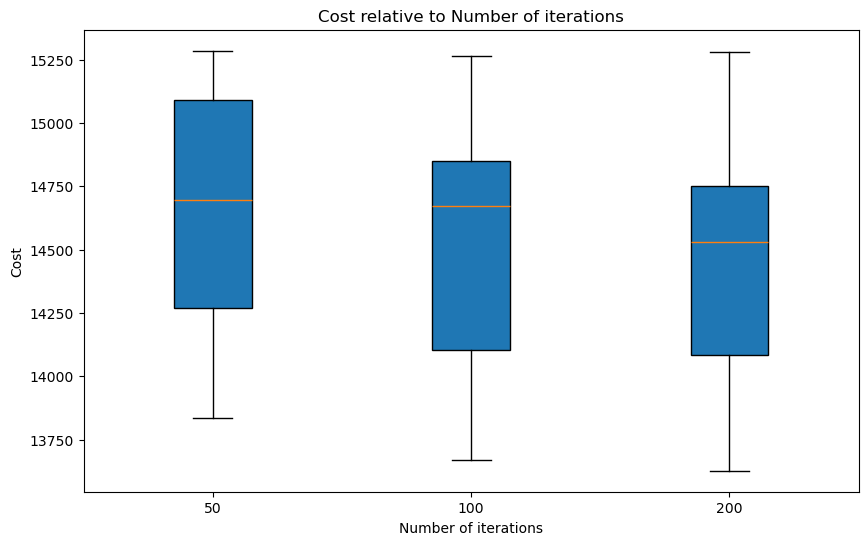

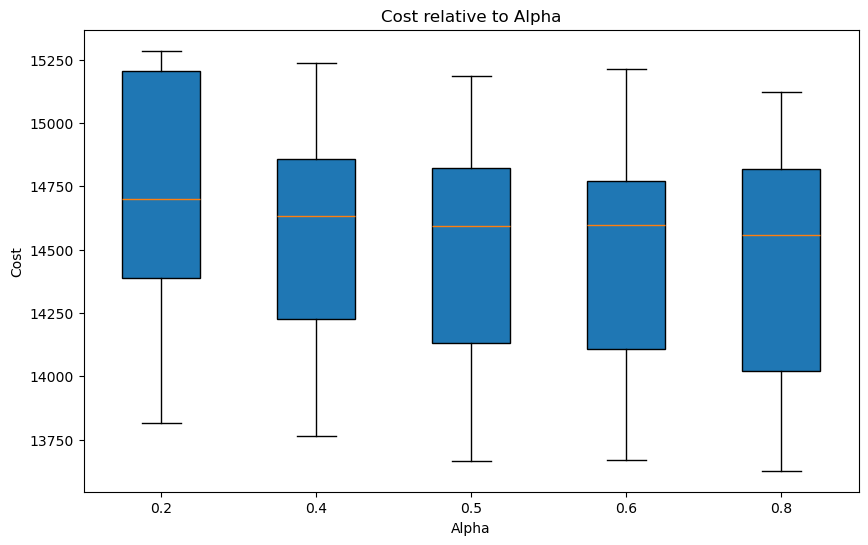

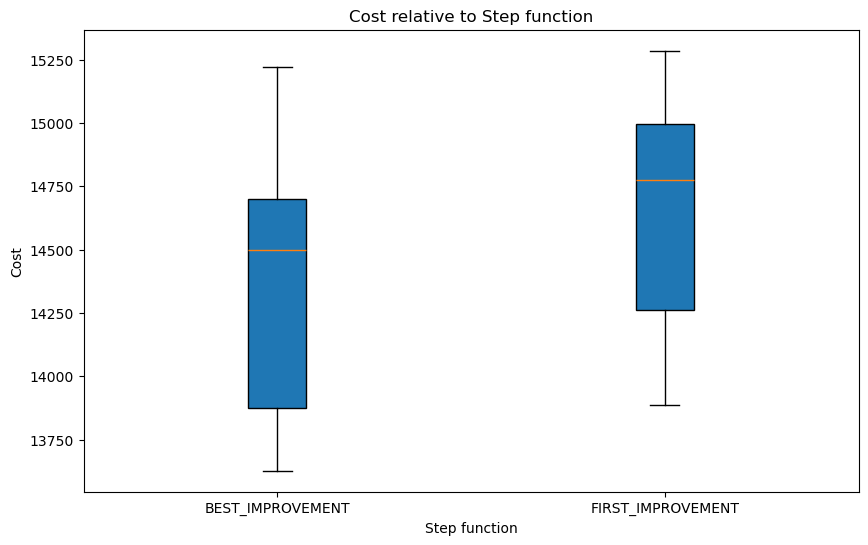

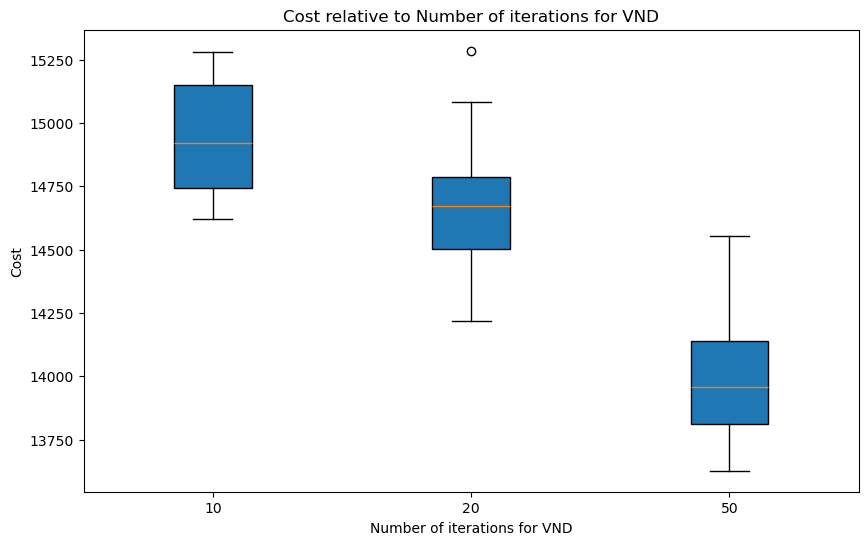

In [176]:
cost_func = lambda x: sum([result[2] for result in x]) / len(x)
#Graph the cost relative to the number of iterations
graph_results_box_plot(results, lambda x: x[0], cost_func, 'Number of iterations', 'Cost')

# Graph the cost relative to alpha
graph_results_box_plot(results, lambda x: x[1], cost_func, 'Alpha', 'Cost')

# Graph the cost relative to the step function
names_dict = {
        StepFunction.BEST_IMPROVEMENT: "BEST_IMPROVEMENT",
        StepFunction.FIRST_IMPROVEMENT: "FIRST_IMPROVEMENT",
        StepFunction.RANDOM: "RANDOM"
}

graph_results_box_plot(results, lambda x: names_dict[x[2]], cost_func, 'Step function', 'Cost')

#Graph the cost relative to the number of iterations
graph_results_box_plot(results, lambda x: x[3], cost_func, 'Number of iterations for VND', 'Cost')


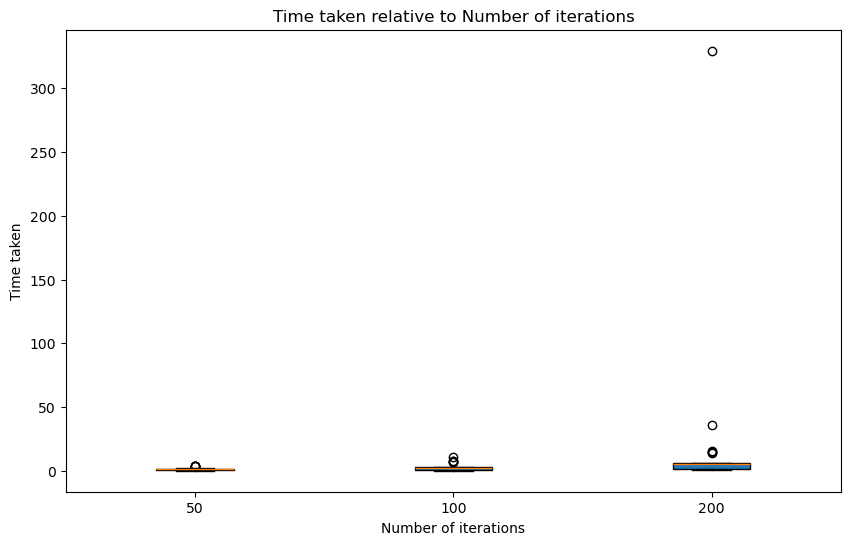

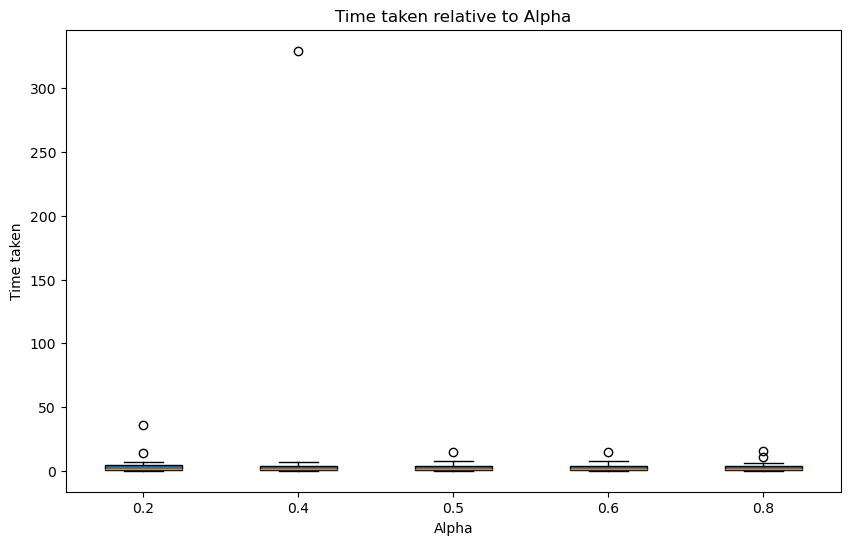

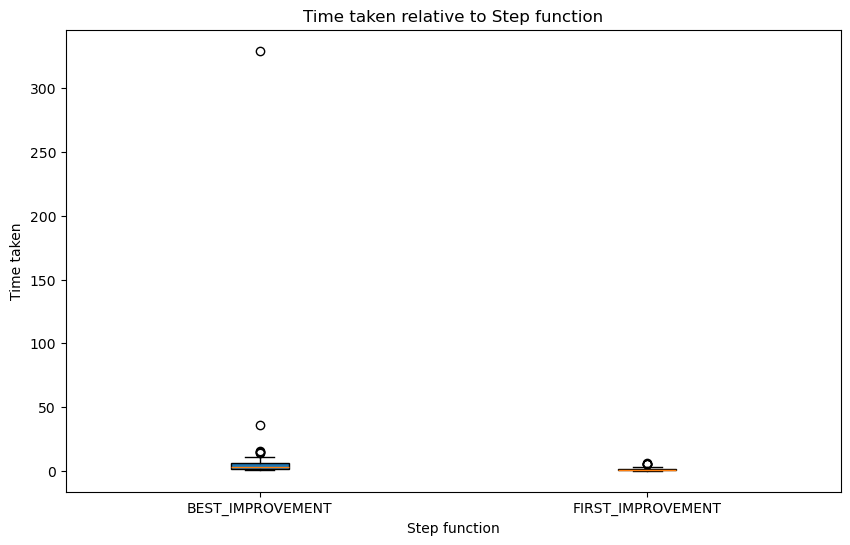

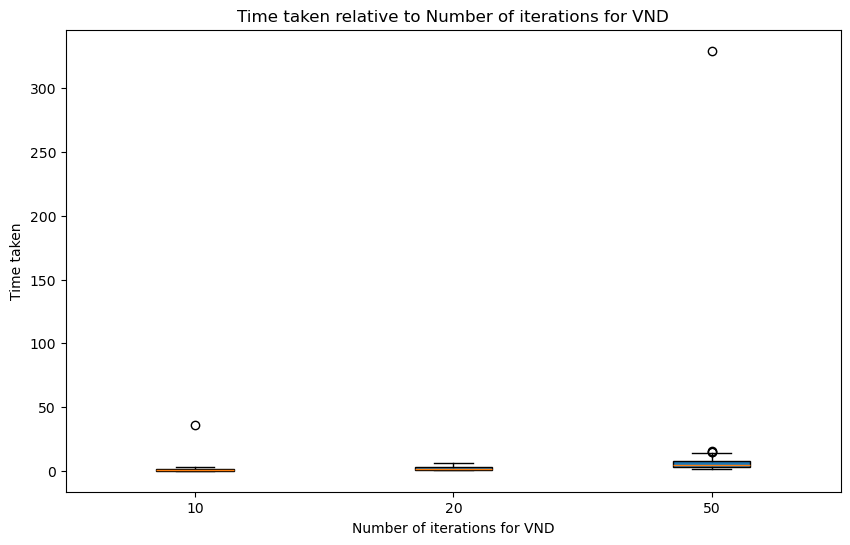

In [177]:
time_taken_func = lambda x: sum([result[3].runtime for result in x]) / len(x)

#Graph the Time taken relative to the number of iterations
graph_results_box_plot(results, lambda x: x[0], time_taken_func, 'Number of iterations', 'Time taken')

# Graph the Time taken relative to alpha
graph_results_box_plot(results, lambda x: x[1], time_taken_func, 'Alpha', 'Time taken')

# Graph the Time taken relative to the step function
names_dict = {
        StepFunction.BEST_IMPROVEMENT: "BEST_IMPROVEMENT",
        StepFunction.FIRST_IMPROVEMENT: "FIRST_IMPROVEMENT",
        StepFunction.RANDOM: "RANDOM"
}

graph_results_box_plot(results, lambda x: names_dict[x[2]], time_taken_func, 'Step function', 'Time taken')

#Graph the Time taken relative to the number of iterations
graph_results_box_plot(results, lambda x: x[3], time_taken_func, 'Number of iterations for VND', 'Time taken')


In [186]:
# GRASP on tuning instances
parameters = {
    "max_iter": [50, 30, 20, 10],
    "alpha": [0.4, 0.5],
    "step_function": [StepFunction.FIRST_IMPROVEMENT],
    "max_iter_vnd": [10, 20, 30, 50],
}

# Generate all possible combinations of parameters
parameter_combinations = list(itertools.product(*parameters.values()))

results = defaultdict(list)
for i, combination in enumerate(parameter_combinations):
    print(f"Combination {i + 1}/{len(parameter_combinations)}")
    for item in items_tuning_med:
        graph = load_instance(item)
        constraints = [(key, item[0]) for key, item in graph.constraints.items() if len(item)>0]
    
        objective_function = cost_function_bit
    
        grasp = GRASP(
            graph=graph,
            max_iterations=combination[0],
            alpha=combination[1],
            step_function=combination[2],
            objective_function=objective_function,
            neighborhood_structures=[NeighborhoodType.SWAP, NeighborhoodType.REVERSE, NeighborhoodType.INSERT],
            max_iter_vnd=combination[3],
            local_search=DeltaImprovedVND,
        )
    
        best_solution, best_cost, stats = grasp.run()
        
        results[tuple(combination)].append((item, best_solution, best_cost, stats))

Combination 1/32
Combination 2/32
Combination 3/32
Combination 4/32
Combination 5/32
Combination 6/32
Combination 7/32
Combination 8/32
Combination 9/32
Combination 10/32
Combination 11/32
Combination 12/32
Combination 13/32
Combination 14/32
Combination 15/32
Combination 16/32
Combination 17/32
Combination 18/32
Combination 19/32
Combination 20/32
Combination 21/32
Combination 22/32
Combination 23/32
Combination 24/32
Combination 25/32
Combination 26/32
Combination 27/32
Combination 28/32
Combination 29/32
Combination 30/32
Combination 31/32
Combination 32/32


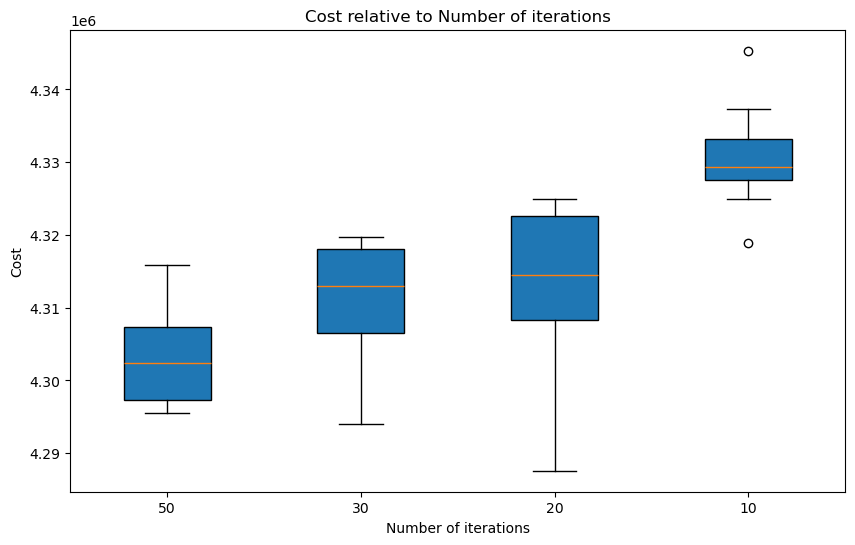

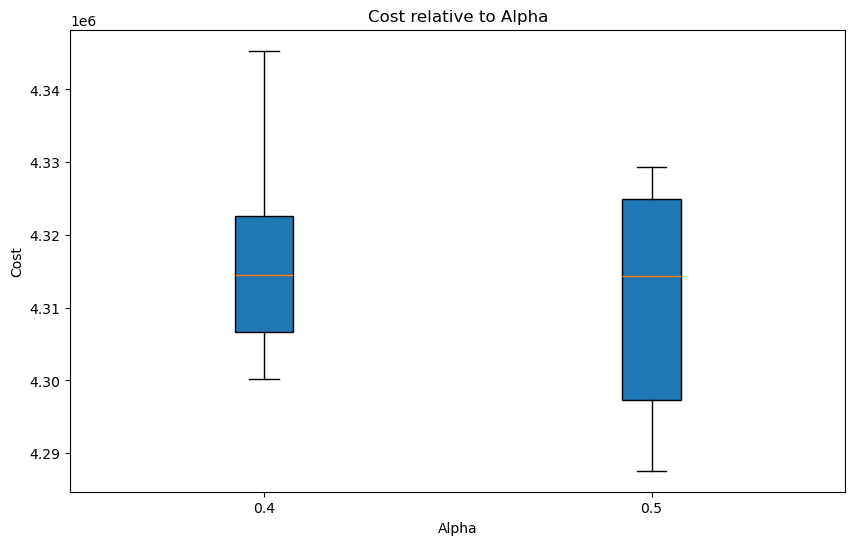

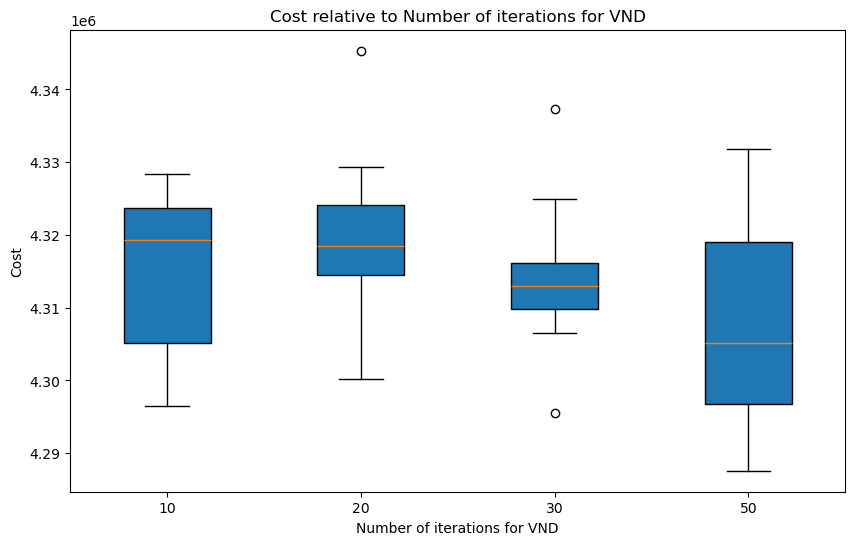

In [188]:
cost_func = lambda x: sum([result[2] for result in x]) / len(x)
#Graph the cost relative to the number of iterations
graph_results_box_plot(results, lambda x: x[0], cost_func, 'Number of iterations', 'Cost')

# Graph the cost relative to alpha
graph_results_box_plot(results, lambda x: x[1], cost_func, 'Alpha', 'Cost')

#Graph the cost relative to the number of iterations
graph_results_box_plot(results, lambda x: x[3], cost_func, 'Number of iterations for VND', 'Cost')


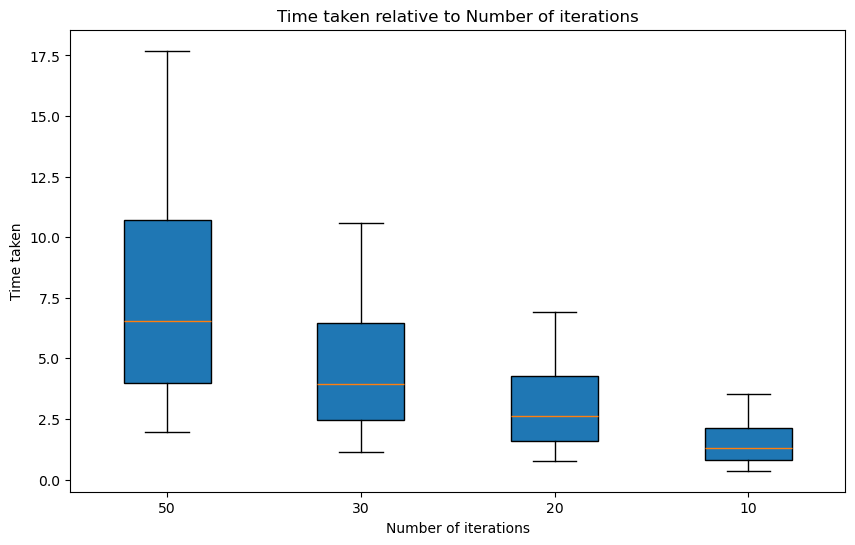

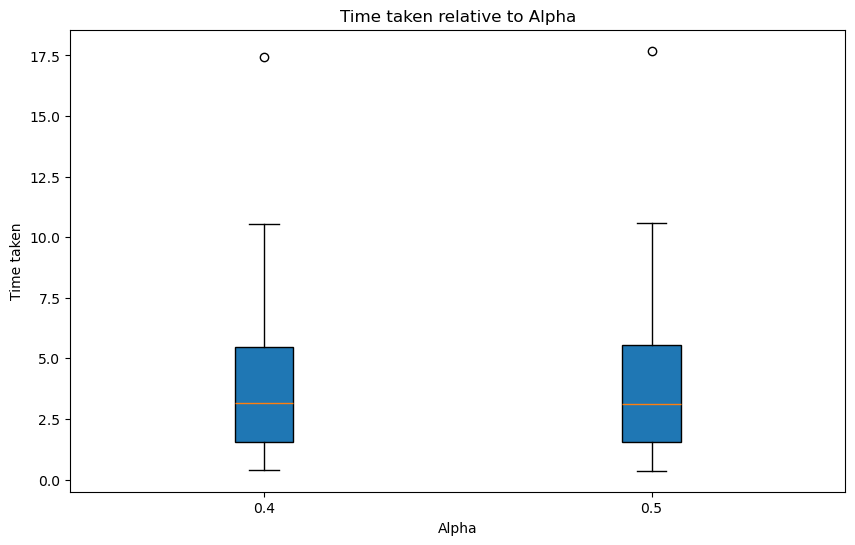

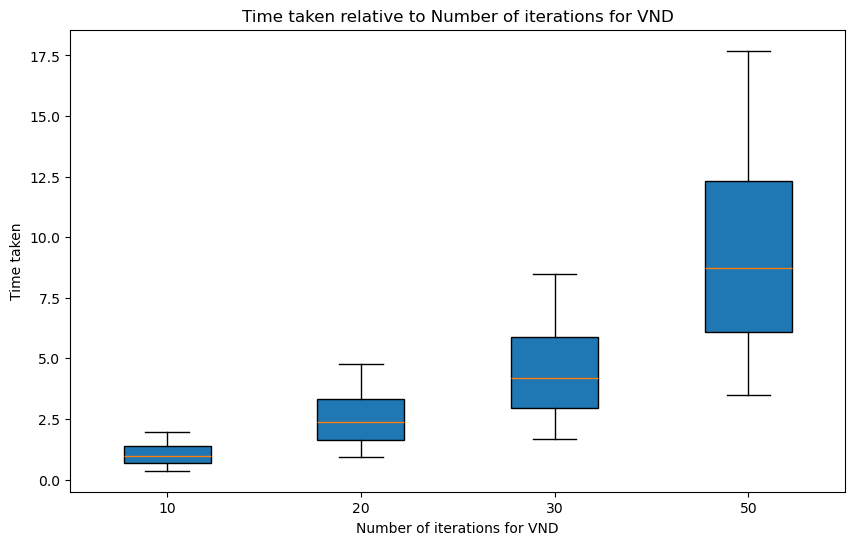

In [190]:
time_taken_func = lambda x: sum([result[3].runtime for result in x]) / len(x)

#Graph the Time taken relative to the number of iterations
graph_results_box_plot(results, lambda x: x[0], time_taken_func, 'Number of iterations', 'Time taken')

# Graph the Time taken relative to alpha
graph_results_box_plot(results, lambda x: x[1], time_taken_func, 'Alpha', 'Time taken')

#Graph the Time taken relative to the number of iterations
graph_results_box_plot(results, lambda x: x[3], time_taken_func, 'Number of iterations for VND', 'Time taken')


In [192]:
# GRASP on tuning instances
parameters = {
    "max_iter": [40, 20],
    "alpha": [0.5],
    "step_function": [StepFunction.FIRST_IMPROVEMENT],
    "max_iter_vnd": [20, 30, 50],
}

# Generate all possible combinations of parameters
parameter_combinations = list(itertools.product(*parameters.values()))

results = defaultdict(list)
for i, combination in enumerate(parameter_combinations):
    print(f"Combination {i + 1}/{len(parameter_combinations)}")
    for item in items_tuning_med_large:
        graph = load_instance(item)
        constraints = [(key, item[0]) for key, item in graph.constraints.items() if len(item)>0]
    
        objective_function = cost_function_bit
    
        grasp = GRASP(
            graph=graph,
            max_iterations=combination[0],
            alpha=combination[1],
            step_function=combination[2],
            objective_function=objective_function,
            neighborhood_structures=[NeighborhoodType.SWAP, NeighborhoodType.REVERSE, NeighborhoodType.INSERT],
            max_iter_vnd=combination[3],
            local_search=DeltaImprovedVND,
        )
    
        best_solution, best_cost, stats = grasp.run()
        
        results[tuple(combination)].append((item, best_solution, best_cost, stats))

Combination 1/6
Combination 2/6
Combination 3/6
Combination 4/6
Combination 5/6
Combination 6/6


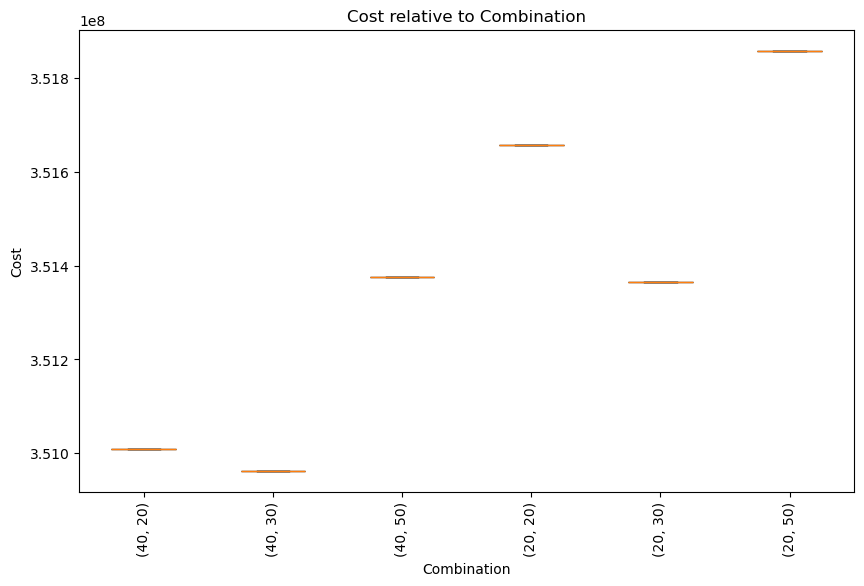

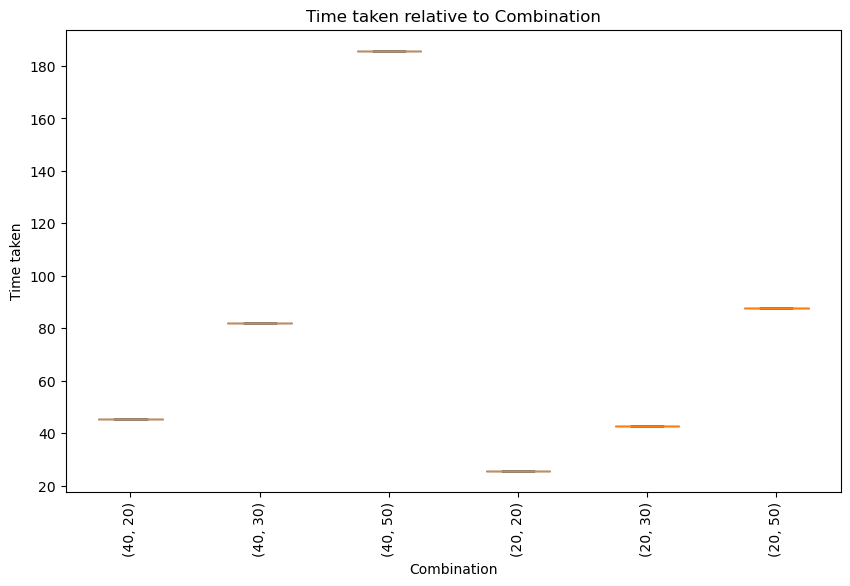

In [194]:
graph_results_box_plot(results, lambda x: (x[0], x[3]), cost_func, 'Combination', 'Cost', x_rotation=90)
graph_results_box_plot(results, lambda x: (x[0], x[3]), time_taken_func, 'Combination', 'Time taken', x_rotation=90)

### GRASP Testing

In [86]:
sizes = ["small", "medium", "medium_large", "large"]

test_items = {}
for size in sizes:
    test_items[size] = list_files_in_folder(f"{test_instances_path}/{size}")

algorithms = {
    "GRASP": (lambda graph, ordering: GRASP(
              graph=graph,
                max_iterations=10,
                alpha=0.5,
                step_function=StepFunction.FIRST_IMPROVEMENT,
                objective_function=cost_function_bit,
                neighborhood_structures=[NeighborhoodType.SWAP, NeighborhoodType.REVERSE, NeighborhoodType.INSERT],
                max_iter_vnd=30,
                local_search=DeltaImprovedVND,
            ), lambda algorithm: algorithm.run())
}

for size, paths in test_items.items():
    print(f"Size: {size}")
    for algorithms_name, (construct_func, run_func) in algorithms.items():
        print(f"Algorithm: {algorithms_name}")
        algorithm_results = {}
        start = time.time()
        for path in paths:
            print(f"Instance: {path}")
            results = run_algorithm_multiple_times(path, construct_func, run_func, 3)
            stats = calculate_stats(results)
            algorithm_results[path] = stats
            save_results_to_file(algorithm_results, algorithms_name, f"content/test_instances/{size}")
            print(f"Time taken: {time.time() - start}")

Size: small
Algorithm: GRASP
Instance: content/test_instances/small/inst_50_4_00006
Time taken: 0.26317501068115234
Instance: content/test_instances/small/inst_50_4_00001
Time taken: 1.0510590076446533
Instance: content/test_instances/small/inst_50_4_00008
Time taken: 1.4019148349761963
Instance: content/test_instances/small/inst_50_4_00009
Time taken: 1.7386698722839355
Instance: content/test_instances/small/inst_50_4_00007
Time taken: 2.1309800148010254
Instance: content/test_instances/small/inst_50_4_00010
Time taken: 2.453997850418091
Instance: content/test_instances/small/inst_50_4_00002
Time taken: 2.955824851989746
Instance: content/test_instances/small/inst_50_4_00005
Time taken: 3.2230589389801025
Instance: content/test_instances/small/inst_50_4_00004
Time taken: 3.5222160816192627
Instance: content/test_instances/small/inst_50_4_00003
Time taken: 3.872523784637451
Size: medium
Algorithm: GRASP
Instance: content/test_instances/medium/inst_200_20_00007
Time taken: 2.83718013763

### VND Competition instances

In [60]:
chosen_parameters = {
    # "inst_50_4_00001": (5000, (NeighborhoodType.INSERT, NeighborhoodType.REVERSE, NeighborhoodType.SWAP), StepFunction.BEST_IMPROVEMENT),
    "inst_200_20_00001": (1500, (NeighborhoodType.SWAP, NeighborhoodType.REVERSE, NeighborhoodType.INSERT), StepFunction.FIRST_IMPROVEMENT),
    # "inst_500_40_00003": (2000, (NeighborhoodType.SWAP, NeighborhoodType.REVERSE, NeighborhoodType.INSERT), StepFunction.FIRST_IMPROVEMENT),
    # "inst_500_40_00012": (1500, (NeighborhoodType.SWAP, NeighborhoodType.REVERSE, NeighborhoodType.INSERT), StepFunction.FIRST_IMPROVEMENT),
    # "inst_500_40_00021": (1500, (NeighborhoodType.SWAP, NeighborhoodType.REVERSE, NeighborhoodType.INSERT), StepFunction.FIRST_IMPROVEMENT),
}

competition_instances_path = "content/competition_instances"

path = "competition_VND"
os.makedirs(path, exist_ok=True)

results = defaultdict(list)
for item, combination in chosen_parameters.items():
    # print(f"Combination {combination}")
    print(f"Instance {item}")
    graph, ordering = load_and_order_instance(f"{competition_instances_path}/{item}")
    constraints = [(key, item[0]) for key, item in graph.constraints.items() if len(item)>0]

    objective_function = cost_function_bit

    vnd = DeltaImprovedVND(
        graph=graph,
        initial_solution=ordering,
        step_function=combination[2],
        max_iter=combination[0],
        max_no_improve=10,
        neighborhood_order=combination[1],
    )

    best_solution, best_cost, stats = vnd.vnd_search()
    
    if not vnd.verify_constraints(best_solution):
        print("Constraints not satisfied")

    results[item] = (best_solution, best_cost, stats)
    print(f"Best cost: {best_cost}")
    print(f"Runtime: {stats.runtime:.2f} seconds")
    print(f"Total iterations: {stats.total_iterations}")
    
    with open(f"{path}/{item}.txt", 'w') as f:
        f.write(f"Instance: {item}\n")
        f.write(f"  Best cost: {best_cost}\n")
        f.write(f"  Runtime: {stats.runtime:.2f} seconds\n")
        f.write(f"  Total iterations: {stats.total_iterations}\n")
        f.write(f"  Solution: {best_solution}\n")

Instance inst_200_20_00001


KeyboardInterrupt: 

### GVNS Competition instances

In [133]:
# Test GVNS on competition instances
chosen_parameters = {
    "inst_50_4_00001": (25, StepFunction.BEST_IMPROVEMENT, 50, (swap_neighborhood_shake, n_swap_neighborhood_shake_generator(3), insert_neighborhood_shake, reverse_neighborhood_shake)),
    "inst_200_20_00001": (10, StepFunction.FIRST_IMPROVEMENT, 30, (swap_neighborhood_shake, n_swap_neighborhood_shake_generator(3), insert_neighborhood_shake, reverse_neighborhood_shake)),
    "inst_500_40_00003": (15, StepFunction.FIRST_IMPROVEMENT, 20, (swap_neighborhood_shake, n_swap_neighborhood_shake_generator(3), insert_neighborhood_shake, reverse_neighborhood_shake)),
    "inst_500_40_00012": (5, StepFunction.FIRST_IMPROVEMENT, 15, (swap_neighborhood_shake, n_swap_neighborhood_shake_generator(3), insert_neighborhood_shake, reverse_neighborhood_shake)),
    "inst_500_40_00021": (5, StepFunction.FIRST_IMPROVEMENT, 15, (swap_neighborhood_shake, n_swap_neighborhood_shake_generator(3), insert_neighborhood_shake, reverse_neighborhood_shake)),
}

results = defaultdict(list)

path = "competition_GVNS"
os.makedirs(path, exist_ok=True)

for item, combination in chosen_parameters.items():
    print(f"Instance {item}")
    graph, ordering = load_and_order_instance(f"{competition_instances_path}/{item}")

    objective_function = cost_function_bit

    gvns = GVNS(
        graph=graph,
        initial_solution=ordering,
        shaking_neighborhoods=combination[3],
        local_search_neighborhoods=[NeighborhoodType.SWAP, NeighborhoodType.REVERSE, NeighborhoodType.INSERT],
        objective_function=objective_function,
        max_iter=combination[0],
        verbose=False,
        vnd_class=DeltaImprovedVND,
        vnd_step_function=combination[1],
        vnd_max_iter=combination[2],
        max_time=10 * 60
    )

    best_solution, best_cost, stats = gvns.find_solution()
    
    if not gvns.verify_constraints(best_solution):
        print("Constraints not satisfied")

    results[item] = (best_solution, best_cost, stats)
    print(f"Best cost: {best_cost}")
    print(f"Runtime: {stats.runtime:.2f} seconds")
    print(f"Total iterations: {stats.total_iterations}")
    
    with open(f"{path}/{item}.txt", 'w') as f:
        f.write(f"Instance: {item}\n")
        f.write(f"  Best cost: {best_cost}\n")
        f.write(f"  Runtime: {stats.runtime:.2f} seconds\n")
        f.write(f"  Total iterations: {stats.total_iterations}\n")
        f.write(f"  Solution: {best_solution}\n")

Instance inst_50_4_00001
Best cost: 76269.0
Runtime: 13.34 seconds
Total iterations: 25
Instance inst_200_20_00001
Best cost: 21638867.0
Runtime: 630.02 seconds
Total iterations: 4
Instance inst_500_40_00003
Best cost: 71002983.0
Runtime: 603.03 seconds
Total iterations: 6
Instance inst_500_40_00012
Best cost: 298033503.0
Runtime: 287.56 seconds
Total iterations: 5
Instance inst_500_40_00021
Best cost: 599080513.0
Runtime: 561.38 seconds
Total iterations: 5


### GRASP Competition instances

In [165]:
competition_instances_path = "content/competition_instances"

# Test GRASP on competition instances
chosen_parameters = {
    # "inst_50_4_00001": (500, 0.5, StepFunction.FIRST_IMPROVEMENT, 200),
    "inst_200_20_00001": (25, 0.5, StepFunction.FIRST_IMPROVEMENT, 350),
    "inst_500_40_00003": (20, 0.5, StepFunction.FIRST_IMPROVEMENT, 300),
    "inst_500_40_00012": (10, 0.5, StepFunction.FIRST_IMPROVEMENT, 250),
    "inst_500_40_00021": (10, 0.5, StepFunction.FIRST_IMPROVEMENT, 200),
}

results = defaultdict(list)

path = "competition_GRASP"
os.makedirs(path, exist_ok=True)

for item, combination in chosen_parameters.items():
    print(f"Instance {item}")
    graph = load_instance(f"{competition_instances_path}/{item}")
    constraints = [(key, item) for key, item in graph.constraints.items() if len(item)>0]

    objective_function = cost_function_bit

    grasp = GRASP(
        graph=graph,
        max_iterations=combination[0],
        alpha=combination[1],
        step_function=combination[2],
        objective_function=objective_function,
        neighborhood_structures=[NeighborhoodType.SWAP, NeighborhoodType.REVERSE, NeighborhoodType.INSERT],
        max_iter_vnd=combination[3],
        local_search=DeltaImprovedVND,
        verbose=False
    )

    best_solution, best_cost, stats = grasp.run()
    
    if not grasp.verify_constraints(best_solution):
        print("Constraints not satisfied")

    results[item] = (best_solution, best_cost, stats)
    print(f"Best cost: {best_cost}")
    print(f"Runtime: {stats.runtime:.2f} seconds")
    print(f"Total iterations: {stats.total_iterations}")
    
    with open(f"{path}/{item}.txt", 'w') as f:
        f.write(f"Instance: {item}\n")
        f.write(f"  Best cost: {best_cost}\n")
        f.write(f"  Runtime: {stats.runtime:.2f} seconds\n")
        f.write(f"  Total iterations: {stats.total_iterations}\n")
        f.write(f"  Solution: {best_solution}\n")

Instance inst_200_20_00001
Best cost: 22394685.0
Runtime: 459.95 seconds
Total iterations: 2929687500000000000000
Instance inst_500_40_00003
Best cost: 74014021.0
Runtime: 590.17 seconds
Total iterations: 58593750000000000000000
Instance inst_500_40_00012
Best cost: 302617016.0
Runtime: 456.05 seconds
Total iterations: 585937500000000000000000
Instance inst_500_40_00021
Best cost: 604914913.0
Runtime: 499.98 seconds
Total iterations: 5859375000000000000000000


In [89]:
instance_length = 12

instance_format = [("Instance", 0), ("Mean time", 8), ("Mean cost", 3), ("Min cost", 1), ("Max cost", 2), ("Std cost", 5)]



def result_to_latex_table(path):
    rows = []
    with open(path, 'r') as f:
        lines = f.readlines()
        instances = [lines[i:i+instance_length] for i in range(0, len(lines), instance_length)]
        for instance in instances:
            if len(instance) < instance_length:
                average_cost = str(round(float(instance[0].split(":")[1].strip()), 2))
                average_time = str(round(float(instance[1].split(":")[1].strip()), 2))
                rows.append("\\midrule")
                rows.append("\\textbf{Summary Statistics} & \\textbf{" + average_time + "} & \\textbf{" + average_cost + "} & - & - & - \\\\")
                continue
                
            row = []
            for name, i in instance_format:
                txt = instance[i].split(":")[1].strip()
                # Convert the txt to number and round it to 2 decimal places
                try:
                    txt = str(round(float(txt), 2))
                except:
                    pass
                if i == 0:
                    txt = txt.split("/")[-1].strip()
                    txt = txt.split("\\")[-1].strip()
                    row.append("\\texttt{" + txt + "}")
                else:
                    row.append(txt)
            rows.append(" & ".join(row) + " \\\\")
            
    return r" ".join(rows)

In [97]:
latex = result_to_latex_table("content/test_instances/large/GVNS.txt")
# Replace all the "_" with "\_" but make sure it is only one "\"
latex = latex.replace("_", r"\_")
print(latex)

\texttt{inst\_1000\_60\_00010} & 12.28 & 290236069.67 & 289196499.0 & 291399836.0 & 903785.34 \\ \texttt{inst\_1000\_60\_00003} & 34.04 & 2690400621.67 & 2680682212.0 & 2697728029.0 & 7161361.06 \\ \texttt{inst\_1000\_60\_00004} & 41.07 & 1602586794.0 & 1598857305.0 & 1608810749.0 & 4429787.98 \\ \texttt{inst\_1000\_60\_00005} & 50.41 & 1057347341.67 & 1053530753.0 & 1060451784.0 & 2870021.12 \\ \texttt{inst\_1000\_60\_00002} & 160.58 & 5312821449.0 & 5298377503.0 & 5326339581.0 & 11434226.4 \\ \texttt{inst\_1000\_60\_00009} & 17.14 & 356347833.33 & 354439227.0 & 357695882.0 & 1387352.18 \\ \texttt{inst\_1000\_60\_00007} & 32.33 & 562712547.67 & 562109354.0 & 563754014.0 & 739499.3 \\ \texttt{inst\_1000\_60\_00001} & 283.16 & 15084967364.0 & 15071720618.0 & 15096689209.0 & 10250256.14 \\ \texttt{inst\_1000\_60\_00006} & 26.24 & 761452544.67 & 760707897.0 & 762766833.0 & 932084.48 \\ \texttt{inst\_1000\_60\_00008} & 14.15 & 448442266.33 & 446978701.0 & 450526114.0 & 1513185.91 \\ \midru

In [163]:
def solutions_to_submission(path):
    # List all files in the path
    files = list_files_in_folder(path)
    for file in files:
        if "submission" in file:
            continue
        with open(file, 'r') as f:
            lines = f.readlines()
            name = lines[0].split(":")[1].strip()
            solution = lines[4].split(":")[1].strip().replace("[", "").replace("]", "").replace(",", "")
        
        with open(f"{path}/{name}_submission.txt", 'w') as f:
            f.write(name + "\n")
            f.write(solution)
            
            
        
solutions_to_submission("competition_GRASP")